<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/from_crash/main_resnextcot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 1025, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 1025 (delta 28), reused 40 (delta 13), pack-reused 960 (from 1)
Receiving objects: 100% (1025/1025), 11.65 MiB | 10.13 MiB/s, done.
Resolving deltas: 100% (673/673), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")


In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import trainer, val_epoch
from kltn.utils.metrics import DiceLossWSigmoid, DiceLossWSoftmax, DiceMetric
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results

In [4]:
drive.flush_and_unmount()
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
0.00% complete (down: 0.0 kB/s up: 0.1 kB/s peers: 3) downloading LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
1.07% complete (down: 15231.3 kB/s up: 447.3 kB/s peers: 9) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreach

## Load data

In [6]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=2)
print(len(full_train_dataset), len(val_dataset))

105 26


In [7]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

print("Train dataset number of batch:", len(train_loader))
print("Val dataset number of batch:", len(val_loader))

Train dataset number of batch: 105
Val dataset number of batch: 26


In [8]:
for batch in train_loader:
    # Assuming your input data is a 5D tensor (batch_size, channels, deep, height, width)
    data_shape = batch['image'].shape
    label_shape = batch['label'].shape
    print("Data shape in the first batch:", data_shape)
    print("Label shape in the first batch:", label_shape)
    break  # Print only the first batch

Data shape in the first batch: torch.Size([1, 1, 128, 128, 128])
Label shape in the first batch: torch.Size([1, 1, 128, 128, 128])


## Visual data

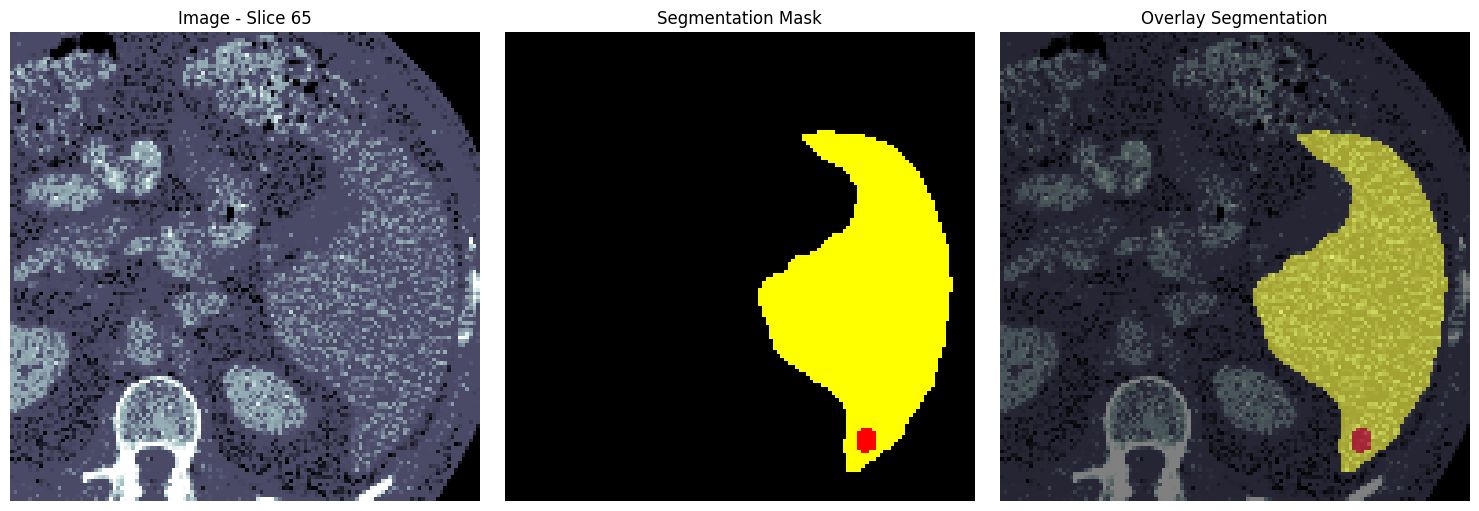

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define colormap for segmentation classes
cmap = mcolors.ListedColormap(["black", "yellow", "red", "green", "blue", "purple"])
bounds = [0, 1, 2, 3, 4, 5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for batch in train_loader:
    image_sample = batch['image']  # Shape: [1, 1, 128, 128, 128]
    label_sample = batch['label']  # Shape: [1, 1, 128, 128, 128]

    label_data = label_sample[0, 0].numpy()  # shape: [128, 128, 128]
    image_data = image_sample[0, 0].numpy()

    # Tìm tất cả slice index có tumor
    tumor_slices = np.any(label_data == 2, axis=(1, 2))


    slice_idx = np.argmax(tumor_slices)

    img_slice = image_data[slice_idx, :, :]
    label_slice = label_data[slice_idx, :, :]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_slice, cmap=plt.cm.bone)
    axes[0].set_title(f"Image - Slice {slice_idx}")
    axes[0].axis("off")

    axes[1].imshow(label_slice, cmap=cmap, norm=norm)
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")

    axes[2].imshow(img_slice, cmap=plt.cm.bone)
    axes[2].imshow(label_slice, cmap=cmap, norm=norm, alpha=0.5)
    axes[2].set_title("Overlay Segmentation")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
    break

## Model

In [ ]:
model = ModelFactory.get_model("unet3d_convnextv2_cot",in_channels=1, n_classes=3, n_channels=16).to(device)
print('Number of network parameters:', sum(param.numel() for param in model.parameters()))

Number of network parameters: 311011


## Training

In [10]:
criterion = DiceLossWSoftmax().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [11]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_liver,
    dices_tumor,
    dices_avg,
    loss_epochs,
    trains_epoch,
    ious_liver,
    ious_tumor,
    ious_avg,
    precisions_liver,
    precisions_tumor,
    precisions_avg,
    recalls_liver,
    recalls_tumor,
    recalls_avg,
    time_tmp,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    max_epochs = config["max_epochs"],
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=True,
)

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/100 1/105 loss: 0.8569 time 6.93s
Epoch 1/100 2/105 loss: 0.8212 time 0.70s
Epoch 1/100 3/105 loss: 0.7968 time 6.01s
Epoch 1/100 4/105 loss: 0.7778 time 5.46s
Epoch 1/100 5/105 loss: 0.7608 time 2.78s
Epoch 1/100 6/105 loss: 0.7493 time 6.39s
Epoch 1/100 7/105 loss: 0.7424 time 6.81s
Epoch 1/100 8/105 loss: 0.7325 time 5.07s
Epoch 1/100 9/105 loss: 0.7233 time 5.39s
Epoch 1/100 10/105 loss: 0.7145 time 5.86s
Epoch 1/100 11/105 loss: 0.7062 time 0.97s
Epoch 1/100 12/105 loss: 0.6990 time 0.95s
Epoch 1/100 13/105 loss: 0.6918 time 11.56s
Epoch 1/100 14/105 loss: 0.6846 time 4.00s
Epoch 1/100 15/105 loss: 0.6787 time 1.43s
Epoch 1/100 16/105 loss: 0.6741 time 1.03s
Epoch 1/100 17/105 loss: 0.6669 time 9.40s
Epoch 1/100 18/105 loss: 0.6617 time 3.01s
Epoch 1/100 19/105 loss: 0.6563 time 4.39s
Epoch 1/100 20/105 loss: 0.6514 time 2.47s
Epoch 1/100 21/105 loss: 0.6468 time 5.36s
Epoch 1/100 22/105 loss: 0.6420 time 7.90s
Epoch 1/100 23/105 loss: 0.6378 time 5.83s
Epoch 1/100 24/105 

Final training epochs: 1/100 ---[loss: 0.4860] ---[time 434.85s]
INFO:kltn.utils.logger:Final training epochs: 1/100 ---[loss: 0.4860] ---[time 434.85s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/100 105/105 loss: 0.4860 time 4.87s


Val 1/100 1/26, Dice_Liver: 0.797341, Dice_Tumor: 0.000000, Dice_Avg: 0.398671, time 8.99s
INFO:kltn.utils.logger:Val 1/100 1/26, Dice_Liver: 0.797341, Dice_Tumor: 0.000000, Dice_Avg: 0.398671, time 8.99s
Val 1/100 2/26, Dice_Liver: 0.764909, Dice_Tumor: 0.000000, Dice_Avg: 0.382454, time 3.00s
INFO:kltn.utils.logger:Val 1/100 2/26, Dice_Liver: 0.764909, Dice_Tumor: 0.000000, Dice_Avg: 0.382454, time 3.00s
Val 1/100 3/26, Dice_Liver: 0.798841, Dice_Tumor: 0.000000, Dice_Avg: 0.399421, time 1.89s
INFO:kltn.utils.logger:Val 1/100 3/26, Dice_Liver: 0.798841, Dice_Tumor: 0.000000, Dice_Avg: 0.399421, time 1.89s
Val 1/100 4/26, Dice_Liver: 0.775528, Dice_Tumor: 0.000000, Dice_Avg: 0.387764, time 1.65s
INFO:kltn.utils.logger:Val 1/100 4/26, Dice_Liver: 0.775528, Dice_Tumor: 0.000000, Dice_Avg: 0.387764, time 1.65s
Val 1/100 5/26, Dice_Liver: 0.791300, Dice_Tumor: 0.000000, Dice_Avg: 0.395650, time 7.77s
INFO:kltn.utils.logger:Val 1/100 5/26, Dice_Liver: 0.791300, Dice_Tumor: 0.000000, Dice_A

New best (0.000000 --> 0.395772). At epoch 1
Epoch 2/100 1/105 loss: 0.3843 time 2.29s
Epoch 2/100 2/105 loss: 0.3807 time 1.62s
Epoch 2/100 3/105 loss: 0.3857 time 5.78s
Epoch 2/100 4/105 loss: 0.3883 time 7.75s
Epoch 2/100 5/105 loss: 0.3921 time 5.12s
Epoch 2/100 6/105 loss: 0.3909 time 6.21s
Epoch 2/100 7/105 loss: 0.3915 time 6.54s
Epoch 2/100 8/105 loss: 0.3956 time 2.47s
Epoch 2/100 9/105 loss: 0.3959 time 3.02s
Epoch 2/100 10/105 loss: 0.3960 time 5.06s
Epoch 2/100 11/105 loss: 0.3963 time 0.97s
Epoch 2/100 12/105 loss: 0.3955 time 5.78s
Epoch 2/100 13/105 loss: 0.3962 time 1.40s
Epoch 2/100 14/105 loss: 0.3960 time 1.07s
Epoch 2/100 15/105 loss: 0.3955 time 5.58s
Epoch 2/100 16/105 loss: 0.3961 time 0.76s
Epoch 2/100 17/105 loss: 0.3991 time 1.02s
Epoch 2/100 18/105 loss: 0.3995 time 7.86s
Epoch 2/100 19/105 loss: 0.3994 time 0.80s
Epoch 2/100 20/105 loss: 0.3988 time 4.83s
Epoch 2/100 21/105 loss: 0.3987 time 5.76s
Epoch 2/100 22/105 loss: 0.4001 time 2.69s
Epoch 2/100 23/105

Final training epochs: 2/100 ---[loss: 0.3888] ---[time 431.31s]
INFO:kltn.utils.logger:Final training epochs: 2/100 ---[loss: 0.3888] ---[time 431.31s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/100 105/105 loss: 0.3888 time 6.46s


Val 2/100 1/26, Dice_Liver: 0.812618, Dice_Tumor: 0.362465, Dice_Avg: 0.587542, time 5.77s
INFO:kltn.utils.logger:Val 2/100 1/26, Dice_Liver: 0.812618, Dice_Tumor: 0.362465, Dice_Avg: 0.587542, time 5.77s
Val 2/100 2/26, Dice_Liver: 0.796702, Dice_Tumor: 0.456637, Dice_Avg: 0.626669, time 5.27s
INFO:kltn.utils.logger:Val 2/100 2/26, Dice_Liver: 0.796702, Dice_Tumor: 0.456637, Dice_Avg: 0.626669, time 5.27s
Val 2/100 3/26, Dice_Liver: 0.802251, Dice_Tumor: 0.445428, Dice_Avg: 0.623840, time 2.20s
INFO:kltn.utils.logger:Val 2/100 3/26, Dice_Liver: 0.802251, Dice_Tumor: 0.445428, Dice_Avg: 0.623840, time 2.20s
Val 2/100 4/26, Dice_Liver: 0.811596, Dice_Tumor: 0.334071, Dice_Avg: 0.572834, time 1.40s
INFO:kltn.utils.logger:Val 2/100 4/26, Dice_Liver: 0.811596, Dice_Tumor: 0.334071, Dice_Avg: 0.572834, time 1.40s
Val 2/100 5/26, Dice_Liver: 0.811565, Dice_Tumor: 0.311449, Dice_Avg: 0.561507, time 7.39s
INFO:kltn.utils.logger:Val 2/100 5/26, Dice_Liver: 0.811565, Dice_Tumor: 0.311449, Dice_A

New best (0.395772 --> 0.460602). At epoch 2
Epoch 3/100 1/105 loss: 0.3074 time 6.65s
Epoch 3/100 2/105 loss: 0.3480 time 4.46s
Epoch 3/100 3/105 loss: 0.3616 time 7.43s
Epoch 3/100 4/105 loss: 0.3499 time 6.22s
Epoch 3/100 5/105 loss: 0.3431 time 3.56s
Epoch 3/100 6/105 loss: 0.3540 time 4.58s
Epoch 3/100 7/105 loss: 0.3588 time 5.73s
Epoch 3/100 8/105 loss: 0.3652 time 6.15s
Epoch 3/100 9/105 loss: 0.3676 time 6.08s
Epoch 3/100 10/105 loss: 0.3683 time 2.08s
Epoch 3/100 11/105 loss: 0.3698 time 5.56s
Epoch 3/100 12/105 loss: 0.3731 time 8.63s
Epoch 3/100 13/105 loss: 0.3688 time 3.10s
Epoch 3/100 14/105 loss: 0.3697 time 0.92s
Epoch 3/100 15/105 loss: 0.3708 time 5.02s
Epoch 3/100 16/105 loss: 0.3697 time 5.17s
Epoch 3/100 17/105 loss: 0.3705 time 5.58s
Epoch 3/100 18/105 loss: 0.3713 time 6.05s
Epoch 3/100 19/105 loss: 0.3717 time 1.27s
Epoch 3/100 20/105 loss: 0.3721 time 1.47s
Epoch 3/100 21/105 loss: 0.3696 time 10.76s
Epoch 3/100 22/105 loss: 0.3701 time 5.05s
Epoch 3/100 23/10

Final training epochs: 3/100 ---[loss: 0.3643] ---[time 426.87s]
INFO:kltn.utils.logger:Final training epochs: 3/100 ---[loss: 0.3643] ---[time 426.87s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/100 105/105 loss: 0.3643 time 1.85s


Val 3/100 1/26, Dice_Liver: 0.879139, Dice_Tumor: 0.551199, Dice_Avg: 0.715169, time 6.22s
INFO:kltn.utils.logger:Val 3/100 1/26, Dice_Liver: 0.879139, Dice_Tumor: 0.551199, Dice_Avg: 0.715169, time 6.22s
Val 3/100 2/26, Dice_Liver: 0.868863, Dice_Tumor: 0.578313, Dice_Avg: 0.723588, time 5.12s
INFO:kltn.utils.logger:Val 3/100 2/26, Dice_Liver: 0.868863, Dice_Tumor: 0.578313, Dice_Avg: 0.723588, time 5.12s
Val 3/100 3/26, Dice_Liver: 0.868166, Dice_Tumor: 0.595943, Dice_Avg: 0.732054, time 1.71s
INFO:kltn.utils.logger:Val 3/100 3/26, Dice_Liver: 0.868166, Dice_Tumor: 0.595943, Dice_Avg: 0.732054, time 1.71s
Val 3/100 4/26, Dice_Liver: 0.875745, Dice_Tumor: 0.446957, Dice_Avg: 0.661351, time 1.38s
INFO:kltn.utils.logger:Val 3/100 4/26, Dice_Liver: 0.875745, Dice_Tumor: 0.446957, Dice_Avg: 0.661351, time 1.38s
Val 3/100 5/26, Dice_Liver: 0.875225, Dice_Tumor: 0.456491, Dice_Avg: 0.665858, time 7.83s
INFO:kltn.utils.logger:Val 3/100 5/26, Dice_Liver: 0.875225, Dice_Tumor: 0.456491, Dice_A

New best (0.460602 --> 0.542522). At epoch 3
Epoch 4/100 1/105 loss: 0.2740 time 2.26s
Epoch 4/100 2/105 loss: 0.3288 time 1.05s
Epoch 4/100 3/105 loss: 0.3318 time 6.68s
Epoch 4/100 4/105 loss: 0.3440 time 5.63s
Epoch 4/100 5/105 loss: 0.3310 time 3.85s
Epoch 4/100 6/105 loss: 0.3407 time 5.53s
Epoch 4/100 7/105 loss: 0.3482 time 1.17s
Epoch 4/100 8/105 loss: 0.3520 time 1.37s
Epoch 4/100 9/105 loss: 0.3516 time 7.27s
Epoch 4/100 10/105 loss: 0.3441 time 1.47s
Epoch 4/100 11/105 loss: 0.3455 time 0.93s
Epoch 4/100 12/105 loss: 0.3463 time 5.82s
Epoch 4/100 13/105 loss: 0.3483 time 5.60s
Epoch 4/100 14/105 loss: 0.3505 time 5.15s
Epoch 4/100 15/105 loss: 0.3527 time 1.38s
Epoch 4/100 16/105 loss: 0.3523 time 1.23s
Epoch 4/100 17/105 loss: 0.3548 time 6.35s
Epoch 4/100 18/105 loss: 0.3543 time 5.98s
Epoch 4/100 19/105 loss: 0.3556 time 3.14s
Epoch 4/100 20/105 loss: 0.3565 time 2.34s
Epoch 4/100 21/105 loss: 0.3494 time 1.51s
Epoch 4/100 22/105 loss: 0.3524 time 3.02s
Epoch 4/100 23/105

Final training epochs: 4/100 ---[loss: 0.3527] ---[time 421.00s]
INFO:kltn.utils.logger:Final training epochs: 4/100 ---[loss: 0.3527] ---[time 421.00s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/100 105/105 loss: 0.3527 time 6.84s


Val 4/100 1/26, Dice_Liver: 0.871882, Dice_Tumor: 0.671045, Dice_Avg: 0.771463, time 5.78s
INFO:kltn.utils.logger:Val 4/100 1/26, Dice_Liver: 0.871882, Dice_Tumor: 0.671045, Dice_Avg: 0.771463, time 5.78s
Val 4/100 2/26, Dice_Liver: 0.881455, Dice_Tumor: 0.706739, Dice_Avg: 0.794097, time 5.90s
INFO:kltn.utils.logger:Val 4/100 2/26, Dice_Liver: 0.881455, Dice_Tumor: 0.706739, Dice_Avg: 0.794097, time 5.90s
Val 4/100 3/26, Dice_Liver: 0.874638, Dice_Tumor: 0.609186, Dice_Avg: 0.741912, time 1.96s
INFO:kltn.utils.logger:Val 4/100 3/26, Dice_Liver: 0.874638, Dice_Tumor: 0.609186, Dice_Avg: 0.741912, time 1.96s
Val 4/100 4/26, Dice_Liver: 0.872244, Dice_Tumor: 0.456890, Dice_Avg: 0.664567, time 1.32s
INFO:kltn.utils.logger:Val 4/100 4/26, Dice_Liver: 0.872244, Dice_Tumor: 0.456890, Dice_Avg: 0.664567, time 1.32s
Val 4/100 5/26, Dice_Liver: 0.876166, Dice_Tumor: 0.490194, Dice_Avg: 0.683180, time 7.37s
INFO:kltn.utils.logger:Val 4/100 5/26, Dice_Liver: 0.876166, Dice_Tumor: 0.490194, Dice_A

New best (0.542522 --> 0.566418). At epoch 4
Epoch 5/100 1/105 loss: 0.3716 time 1.51s
Epoch 5/100 2/105 loss: 0.3537 time 1.65s
Epoch 5/100 3/105 loss: 0.3467 time 2.96s
Epoch 5/100 4/105 loss: 0.3435 time 0.87s
Epoch 5/100 5/105 loss: 0.3512 time 7.40s
Epoch 5/100 6/105 loss: 0.3408 time 5.61s
Epoch 5/100 7/105 loss: 0.3494 time 7.54s
Epoch 5/100 8/105 loss: 0.3509 time 0.80s
Epoch 5/100 9/105 loss: 0.3551 time 5.32s
Epoch 5/100 10/105 loss: 0.3487 time 3.51s
Epoch 5/100 11/105 loss: 0.3517 time 5.76s
Epoch 5/100 12/105 loss: 0.3542 time 4.44s
Epoch 5/100 13/105 loss: 0.3558 time 6.49s
Epoch 5/100 14/105 loss: 0.3581 time 2.02s
Epoch 5/100 15/105 loss: 0.3581 time 6.51s
Epoch 5/100 16/105 loss: 0.3600 time 0.72s
Epoch 5/100 17/105 loss: 0.3513 time 2.11s
Epoch 5/100 18/105 loss: 0.3416 time 1.77s
Epoch 5/100 19/105 loss: 0.3437 time 6.04s
Epoch 5/100 20/105 loss: 0.3432 time 6.91s
Epoch 5/100 21/105 loss: 0.3457 time 1.13s
Epoch 5/100 22/105 loss: 0.3447 time 6.27s
Epoch 5/100 23/105

Final training epochs: 5/100 ---[loss: 0.3424] ---[time 426.55s]
INFO:kltn.utils.logger:Final training epochs: 5/100 ---[loss: 0.3424] ---[time 426.55s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/100 105/105 loss: 0.3424 time 2.51s


Val 5/100 1/26, Dice_Liver: 0.875923, Dice_Tumor: 0.522749, Dice_Avg: 0.699336, time 5.80s
INFO:kltn.utils.logger:Val 5/100 1/26, Dice_Liver: 0.875923, Dice_Tumor: 0.522749, Dice_Avg: 0.699336, time 5.80s
Val 5/100 2/26, Dice_Liver: 0.882155, Dice_Tumor: 0.549489, Dice_Avg: 0.715822, time 5.39s
INFO:kltn.utils.logger:Val 5/100 2/26, Dice_Liver: 0.882155, Dice_Tumor: 0.549489, Dice_Avg: 0.715822, time 5.39s
Val 5/100 3/26, Dice_Liver: 0.886493, Dice_Tumor: 0.609515, Dice_Avg: 0.748004, time 2.30s
INFO:kltn.utils.logger:Val 5/100 3/26, Dice_Liver: 0.886493, Dice_Tumor: 0.609515, Dice_Avg: 0.748004, time 2.30s
Val 5/100 4/26, Dice_Liver: 0.867582, Dice_Tumor: 0.457136, Dice_Avg: 0.662359, time 1.38s
INFO:kltn.utils.logger:Val 5/100 4/26, Dice_Liver: 0.867582, Dice_Tumor: 0.457136, Dice_Avg: 0.662359, time 1.38s
Val 5/100 5/26, Dice_Liver: 0.874938, Dice_Tumor: 0.497703, Dice_Avg: 0.686321, time 7.56s
INFO:kltn.utils.logger:Val 5/100 5/26, Dice_Liver: 0.874938, Dice_Tumor: 0.497703, Dice_A

New best (0.566418 --> 0.581289). At epoch 5
Epoch 6/100 1/105 loss: 0.2267 time 5.75s
Epoch 6/100 2/105 loss: 0.2524 time 1.92s
Epoch 6/100 3/105 loss: 0.2985 time 5.49s
Epoch 6/100 4/105 loss: 0.3220 time 5.83s
Epoch 6/100 5/105 loss: 0.3076 time 4.57s
Epoch 6/100 6/105 loss: 0.3193 time 6.51s
Epoch 6/100 7/105 loss: 0.3110 time 4.27s
Epoch 6/100 8/105 loss: 0.3195 time 1.17s
Epoch 6/100 9/105 loss: 0.3172 time 0.96s
Epoch 6/100 10/105 loss: 0.3207 time 0.80s
Epoch 6/100 11/105 loss: 0.3213 time 5.79s
Epoch 6/100 12/105 loss: 0.3256 time 5.79s
Epoch 6/100 13/105 loss: 0.3305 time 5.62s
Epoch 6/100 14/105 loss: 0.3352 time 6.03s
Epoch 6/100 15/105 loss: 0.3363 time 8.54s
Epoch 6/100 16/105 loss: 0.3297 time 1.59s
Epoch 6/100 17/105 loss: 0.3326 time 5.18s
Epoch 6/100 18/105 loss: 0.3309 time 1.41s
Epoch 6/100 19/105 loss: 0.3299 time 6.40s
Epoch 6/100 20/105 loss: 0.3273 time 1.00s
Epoch 6/100 21/105 loss: 0.3278 time 4.66s
Epoch 6/100 22/105 loss: 0.3287 time 2.91s
Epoch 6/100 23/105

Final training epochs: 6/100 ---[loss: 0.3413] ---[time 426.00s]
INFO:kltn.utils.logger:Final training epochs: 6/100 ---[loss: 0.3413] ---[time 426.00s]

********************Epoch 6 Validation********************
INFO:kltn.utils.logger:
********************Epoch 6 Validation********************


Epoch 6/100 105/105 loss: 0.3413 time 6.70s


Val 6/100 1/26, Dice_Liver: 0.867908, Dice_Tumor: 0.480881, Dice_Avg: 0.674395, time 5.62s
INFO:kltn.utils.logger:Val 6/100 1/26, Dice_Liver: 0.867908, Dice_Tumor: 0.480881, Dice_Avg: 0.674395, time 5.62s
Val 6/100 2/26, Dice_Liver: 0.880683, Dice_Tumor: 0.548290, Dice_Avg: 0.714486, time 5.27s
INFO:kltn.utils.logger:Val 6/100 2/26, Dice_Liver: 0.880683, Dice_Tumor: 0.548290, Dice_Avg: 0.714486, time 5.27s
Val 6/100 3/26, Dice_Liver: 0.884493, Dice_Tumor: 0.452083, Dice_Avg: 0.668288, time 1.99s
INFO:kltn.utils.logger:Val 6/100 3/26, Dice_Liver: 0.884493, Dice_Tumor: 0.452083, Dice_Avg: 0.668288, time 1.99s
Val 6/100 4/26, Dice_Liver: 0.885751, Dice_Tumor: 0.344060, Dice_Avg: 0.614906, time 1.35s
INFO:kltn.utils.logger:Val 6/100 4/26, Dice_Liver: 0.885751, Dice_Tumor: 0.344060, Dice_Avg: 0.614906, time 1.35s
Val 6/100 5/26, Dice_Liver: 0.888582, Dice_Tumor: 0.305893, Dice_Avg: 0.597238, time 7.62s
INFO:kltn.utils.logger:Val 6/100 5/26, Dice_Liver: 0.888582, Dice_Tumor: 0.305893, Dice_A

Epoch 7/100 1/105 loss: 0.3780 time 1.88s
Epoch 7/100 2/105 loss: 0.3707 time 4.37s
Epoch 7/100 3/105 loss: 0.3434 time 3.35s
Epoch 7/100 4/105 loss: 0.3088 time 1.55s
Epoch 7/100 5/105 loss: 0.2956 time 5.69s
Epoch 7/100 6/105 loss: 0.3062 time 6.46s
Epoch 7/100 7/105 loss: 0.3150 time 2.60s
Epoch 7/100 8/105 loss: 0.3175 time 0.70s
Epoch 7/100 9/105 loss: 0.3177 time 5.22s
Epoch 7/100 10/105 loss: 0.3248 time 1.03s
Epoch 7/100 11/105 loss: 0.3251 time 6.57s
Epoch 7/100 12/105 loss: 0.3230 time 1.63s
Epoch 7/100 13/105 loss: 0.3281 time 5.86s
Epoch 7/100 14/105 loss: 0.3248 time 6.25s
Epoch 7/100 15/105 loss: 0.3215 time 3.81s
Epoch 7/100 16/105 loss: 0.3238 time 1.00s
Epoch 7/100 17/105 loss: 0.3240 time 1.55s
Epoch 7/100 18/105 loss: 0.3271 time 6.08s
Epoch 7/100 19/105 loss: 0.3312 time 2.85s
Epoch 7/100 20/105 loss: 0.3296 time 1.53s
Epoch 7/100 21/105 loss: 0.3238 time 2.71s
Epoch 7/100 22/105 loss: 0.3263 time 1.56s
Epoch 7/100 23/105 loss: 0.3280 time 5.73s
Epoch 7/100 24/105 l

Final training epochs: 7/100 ---[loss: 0.3348] ---[time 431.63s]
INFO:kltn.utils.logger:Final training epochs: 7/100 ---[loss: 0.3348] ---[time 431.63s]

********************Epoch 7 Validation********************
INFO:kltn.utils.logger:
********************Epoch 7 Validation********************


Epoch 7/100 105/105 loss: 0.3348 time 5.13s


Val 7/100 1/26, Dice_Liver: 0.869403, Dice_Tumor: 0.619467, Dice_Avg: 0.744435, time 5.95s
INFO:kltn.utils.logger:Val 7/100 1/26, Dice_Liver: 0.869403, Dice_Tumor: 0.619467, Dice_Avg: 0.744435, time 5.95s
Val 7/100 2/26, Dice_Liver: 0.878422, Dice_Tumor: 0.698404, Dice_Avg: 0.788413, time 5.36s
INFO:kltn.utils.logger:Val 7/100 2/26, Dice_Liver: 0.878422, Dice_Tumor: 0.698404, Dice_Avg: 0.788413, time 5.36s
Val 7/100 3/26, Dice_Liver: 0.880003, Dice_Tumor: 0.612375, Dice_Avg: 0.746189, time 2.19s
INFO:kltn.utils.logger:Val 7/100 3/26, Dice_Liver: 0.880003, Dice_Tumor: 0.612375, Dice_Avg: 0.746189, time 2.19s
Val 7/100 4/26, Dice_Liver: 0.881210, Dice_Tumor: 0.464889, Dice_Avg: 0.673050, time 1.66s
INFO:kltn.utils.logger:Val 7/100 4/26, Dice_Liver: 0.881210, Dice_Tumor: 0.464889, Dice_Avg: 0.673050, time 1.66s
Val 7/100 5/26, Dice_Liver: 0.884470, Dice_Tumor: 0.488681, Dice_Avg: 0.686576, time 7.49s
INFO:kltn.utils.logger:Val 7/100 5/26, Dice_Liver: 0.884470, Dice_Tumor: 0.488681, Dice_A

Epoch 8/100 1/105 loss: 0.3280 time 1.65s
Epoch 8/100 2/105 loss: 0.3322 time 1.34s
Epoch 8/100 3/105 loss: 0.3400 time 5.36s
Epoch 8/100 4/105 loss: 0.3098 time 10.80s
Epoch 8/100 5/105 loss: 0.2937 time 1.71s
Epoch 8/100 6/105 loss: 0.2801 time 1.82s
Epoch 8/100 7/105 loss: 0.2903 time 3.62s
Epoch 8/100 8/105 loss: 0.2866 time 5.26s
Epoch 8/100 9/105 loss: 0.2822 time 4.84s
Epoch 8/100 10/105 loss: 0.2918 time 1.50s
Epoch 8/100 11/105 loss: 0.2982 time 6.48s
Epoch 8/100 12/105 loss: 0.3025 time 2.24s
Epoch 8/100 13/105 loss: 0.3000 time 7.00s
Epoch 8/100 14/105 loss: 0.3062 time 3.04s
Epoch 8/100 15/105 loss: 0.3025 time 1.39s
Epoch 8/100 16/105 loss: 0.3084 time 3.08s
Epoch 8/100 17/105 loss: 0.3088 time 1.71s
Epoch 8/100 18/105 loss: 0.3068 time 9.14s
Epoch 8/100 19/105 loss: 0.3109 time 5.98s
Epoch 8/100 20/105 loss: 0.3148 time 0.72s
Epoch 8/100 21/105 loss: 0.3185 time 2.24s
Epoch 8/100 22/105 loss: 0.3210 time 0.93s
Epoch 8/100 23/105 loss: 0.3232 time 2.87s
Epoch 8/100 24/105 

Final training epochs: 8/100 ---[loss: 0.3336] ---[time 422.65s]
INFO:kltn.utils.logger:Final training epochs: 8/100 ---[loss: 0.3336] ---[time 422.65s]

********************Epoch 8 Validation********************
INFO:kltn.utils.logger:
********************Epoch 8 Validation********************


Epoch 8/100 105/105 loss: 0.3336 time 1.38s


Val 8/100 1/26, Dice_Liver: 0.865880, Dice_Tumor: 0.516929, Dice_Avg: 0.691405, time 5.79s
INFO:kltn.utils.logger:Val 8/100 1/26, Dice_Liver: 0.865880, Dice_Tumor: 0.516929, Dice_Avg: 0.691405, time 5.79s
Val 8/100 2/26, Dice_Liver: 0.886970, Dice_Tumor: 0.586133, Dice_Avg: 0.736551, time 5.67s
INFO:kltn.utils.logger:Val 8/100 2/26, Dice_Liver: 0.886970, Dice_Tumor: 0.586133, Dice_Avg: 0.736551, time 5.67s
Val 8/100 3/26, Dice_Liver: 0.889979, Dice_Tumor: 0.487804, Dice_Avg: 0.688892, time 1.91s
INFO:kltn.utils.logger:Val 8/100 3/26, Dice_Liver: 0.889979, Dice_Tumor: 0.487804, Dice_Avg: 0.688892, time 1.91s
Val 8/100 4/26, Dice_Liver: 0.892368, Dice_Tumor: 0.369422, Dice_Avg: 0.630895, time 1.29s
INFO:kltn.utils.logger:Val 8/100 4/26, Dice_Liver: 0.892368, Dice_Tumor: 0.369422, Dice_Avg: 0.630895, time 1.29s
Val 8/100 5/26, Dice_Liver: 0.891596, Dice_Tumor: 0.392200, Dice_Avg: 0.641898, time 8.07s
INFO:kltn.utils.logger:Val 8/100 5/26, Dice_Liver: 0.891596, Dice_Tumor: 0.392200, Dice_A

Epoch 9/100 1/105 loss: 0.3134 time 4.63s
Epoch 9/100 2/105 loss: 0.3189 time 4.26s
Epoch 9/100 3/105 loss: 0.3243 time 0.98s
Epoch 9/100 4/105 loss: 0.3380 time 6.53s
Epoch 9/100 5/105 loss: 0.3440 time 6.04s
Epoch 9/100 6/105 loss: 0.3389 time 5.81s
Epoch 9/100 7/105 loss: 0.3291 time 3.63s
Epoch 9/100 8/105 loss: 0.3232 time 1.00s
Epoch 9/100 9/105 loss: 0.3179 time 3.44s
Epoch 9/100 10/105 loss: 0.3257 time 5.96s
Epoch 9/100 11/105 loss: 0.3337 time 1.11s
Epoch 9/100 12/105 loss: 0.3351 time 6.57s
Epoch 9/100 13/105 loss: 0.3388 time 2.39s
Epoch 9/100 14/105 loss: 0.3329 time 4.67s
Epoch 9/100 15/105 loss: 0.3366 time 5.59s
Epoch 9/100 16/105 loss: 0.3370 time 5.76s
Epoch 9/100 17/105 loss: 0.3392 time 0.80s
Epoch 9/100 18/105 loss: 0.3408 time 6.83s
Epoch 9/100 19/105 loss: 0.3429 time 9.64s
Epoch 9/100 20/105 loss: 0.3442 time 4.42s
Epoch 9/100 21/105 loss: 0.3410 time 4.42s
Epoch 9/100 22/105 loss: 0.3341 time 1.47s
Epoch 9/100 23/105 loss: 0.3312 time 1.51s
Epoch 9/100 24/105 l

Final training epochs: 9/100 ---[loss: 0.3351] ---[time 425.68s]
INFO:kltn.utils.logger:Final training epochs: 9/100 ---[loss: 0.3351] ---[time 425.68s]

********************Epoch 9 Validation********************
INFO:kltn.utils.logger:
********************Epoch 9 Validation********************


Epoch 9/100 105/105 loss: 0.3351 time 7.91s


Val 9/100 1/26, Dice_Liver: 0.881861, Dice_Tumor: 0.655133, Dice_Avg: 0.768497, time 5.50s
INFO:kltn.utils.logger:Val 9/100 1/26, Dice_Liver: 0.881861, Dice_Tumor: 0.655133, Dice_Avg: 0.768497, time 5.50s
Val 9/100 2/26, Dice_Liver: 0.887019, Dice_Tumor: 0.719968, Dice_Avg: 0.803493, time 6.16s
INFO:kltn.utils.logger:Val 9/100 2/26, Dice_Liver: 0.887019, Dice_Tumor: 0.719968, Dice_Avg: 0.803493, time 6.16s
Val 9/100 3/26, Dice_Liver: 0.889737, Dice_Tumor: 0.690481, Dice_Avg: 0.790109, time 1.84s
INFO:kltn.utils.logger:Val 9/100 3/26, Dice_Liver: 0.889737, Dice_Tumor: 0.690481, Dice_Avg: 0.790109, time 1.84s
Val 9/100 4/26, Dice_Liver: 0.888446, Dice_Tumor: 0.518398, Dice_Avg: 0.703422, time 1.35s
INFO:kltn.utils.logger:Val 9/100 4/26, Dice_Liver: 0.888446, Dice_Tumor: 0.518398, Dice_Avg: 0.703422, time 1.35s
Val 9/100 5/26, Dice_Liver: 0.889285, Dice_Tumor: 0.509045, Dice_Avg: 0.699165, time 7.38s
INFO:kltn.utils.logger:Val 9/100 5/26, Dice_Liver: 0.889285, Dice_Tumor: 0.509045, Dice_A

Epoch 10/100 1/105 loss: 0.3193 time 6.03s
Epoch 10/100 2/105 loss: 0.3509 time 5.51s
Epoch 10/100 3/105 loss: 0.3410 time 1.13s
Epoch 10/100 4/105 loss: 0.3477 time 6.67s
Epoch 10/100 5/105 loss: 0.3253 time 5.62s
Epoch 10/100 6/105 loss: 0.3269 time 6.32s
Epoch 10/100 7/105 loss: 0.3363 time 6.10s
Epoch 10/100 8/105 loss: 0.3459 time 3.50s
Epoch 10/100 9/105 loss: 0.3544 time 0.71s
Epoch 10/100 10/105 loss: 0.3512 time 4.91s
Epoch 10/100 11/105 loss: 0.3498 time 2.59s
Epoch 10/100 12/105 loss: 0.3447 time 5.71s
Epoch 10/100 13/105 loss: 0.3443 time 5.99s
Epoch 10/100 14/105 loss: 0.3369 time 1.92s
Epoch 10/100 15/105 loss: 0.3396 time 5.69s
Epoch 10/100 16/105 loss: 0.3380 time 0.89s
Epoch 10/100 17/105 loss: 0.3360 time 5.71s
Epoch 10/100 18/105 loss: 0.3381 time 6.05s
Epoch 10/100 19/105 loss: 0.3397 time 5.99s
Epoch 10/100 20/105 loss: 0.3373 time 5.98s
Epoch 10/100 21/105 loss: 0.3376 time 5.77s
Epoch 10/100 22/105 loss: 0.3348 time 7.06s
Epoch 10/100 23/105 loss: 0.3372 time 5.8

Final training epochs: 10/100 ---[loss: 0.3268] ---[time 432.51s]
INFO:kltn.utils.logger:Final training epochs: 10/100 ---[loss: 0.3268] ---[time 432.51s]

********************Epoch 10 Validation********************
INFO:kltn.utils.logger:
********************Epoch 10 Validation********************


Epoch 10/100 105/105 loss: 0.3268 time 1.67s


Val 10/100 1/26, Dice_Liver: 0.854535, Dice_Tumor: 0.444936, Dice_Avg: 0.649735, time 6.02s
INFO:kltn.utils.logger:Val 10/100 1/26, Dice_Liver: 0.854535, Dice_Tumor: 0.444936, Dice_Avg: 0.649735, time 6.02s
Val 10/100 2/26, Dice_Liver: 0.858863, Dice_Tumor: 0.582797, Dice_Avg: 0.720830, time 5.81s
INFO:kltn.utils.logger:Val 10/100 2/26, Dice_Liver: 0.858863, Dice_Tumor: 0.582797, Dice_Avg: 0.720830, time 5.81s
Val 10/100 3/26, Dice_Liver: 0.866397, Dice_Tumor: 0.477759, Dice_Avg: 0.672078, time 1.91s
INFO:kltn.utils.logger:Val 10/100 3/26, Dice_Liver: 0.866397, Dice_Tumor: 0.477759, Dice_Avg: 0.672078, time 1.91s
Val 10/100 4/26, Dice_Liver: 0.865251, Dice_Tumor: 0.358319, Dice_Avg: 0.611785, time 1.34s
INFO:kltn.utils.logger:Val 10/100 4/26, Dice_Liver: 0.865251, Dice_Tumor: 0.358319, Dice_Avg: 0.611785, time 1.34s
Val 10/100 5/26, Dice_Liver: 0.869061, Dice_Tumor: 0.322877, Dice_Avg: 0.595969, time 8.17s
INFO:kltn.utils.logger:Val 10/100 5/26, Dice_Liver: 0.869061, Dice_Tumor: 0.3228

Epoch 11/100 1/105 loss: 0.3732 time 1.57s
Epoch 11/100 2/105 loss: 0.3680 time 5.29s
Epoch 11/100 3/105 loss: 0.3730 time 5.84s
Epoch 11/100 4/105 loss: 0.3750 time 5.11s
Epoch 11/100 5/105 loss: 0.3748 time 4.56s
Epoch 11/100 6/105 loss: 0.3578 time 5.59s
Epoch 11/100 7/105 loss: 0.3597 time 2.39s
Epoch 11/100 8/105 loss: 0.3654 time 0.76s
Epoch 11/100 9/105 loss: 0.3674 time 6.72s
Epoch 11/100 10/105 loss: 0.3682 time 2.02s
Epoch 11/100 11/105 loss: 0.3630 time 5.75s
Epoch 11/100 12/105 loss: 0.3582 time 1.73s
Epoch 11/100 13/105 loss: 0.3595 time 6.21s
Epoch 11/100 14/105 loss: 0.3513 time 4.59s
Epoch 11/100 15/105 loss: 0.3471 time 0.96s
Epoch 11/100 16/105 loss: 0.3518 time 1.25s
Epoch 11/100 17/105 loss: 0.3519 time 5.50s
Epoch 11/100 18/105 loss: 0.3530 time 4.28s
Epoch 11/100 19/105 loss: 0.3475 time 0.95s
Epoch 11/100 20/105 loss: 0.3504 time 6.69s
Epoch 11/100 21/105 loss: 0.3509 time 7.09s
Epoch 11/100 22/105 loss: 0.3494 time 6.61s
Epoch 11/100 23/105 loss: 0.3449 time 1.6

Final training epochs: 11/100 ---[loss: 0.3317] ---[time 427.65s]
INFO:kltn.utils.logger:Final training epochs: 11/100 ---[loss: 0.3317] ---[time 427.65s]

********************Epoch 11 Validation********************
INFO:kltn.utils.logger:
********************Epoch 11 Validation********************


Epoch 11/100 105/105 loss: 0.3317 time 3.58s


Val 11/100 1/26, Dice_Liver: 0.880227, Dice_Tumor: 0.564223, Dice_Avg: 0.722225, time 6.03s
INFO:kltn.utils.logger:Val 11/100 1/26, Dice_Liver: 0.880227, Dice_Tumor: 0.564223, Dice_Avg: 0.722225, time 6.03s
Val 11/100 2/26, Dice_Liver: 0.873567, Dice_Tumor: 0.668780, Dice_Avg: 0.771173, time 6.45s
INFO:kltn.utils.logger:Val 11/100 2/26, Dice_Liver: 0.873567, Dice_Tumor: 0.668780, Dice_Avg: 0.771173, time 6.45s
Val 11/100 3/26, Dice_Liver: 0.872172, Dice_Tumor: 0.573243, Dice_Avg: 0.722708, time 1.89s
INFO:kltn.utils.logger:Val 11/100 3/26, Dice_Liver: 0.872172, Dice_Tumor: 0.573243, Dice_Avg: 0.722708, time 1.89s
Val 11/100 4/26, Dice_Liver: 0.875683, Dice_Tumor: 0.429932, Dice_Avg: 0.652808, time 1.35s
INFO:kltn.utils.logger:Val 11/100 4/26, Dice_Liver: 0.875683, Dice_Tumor: 0.429932, Dice_Avg: 0.652808, time 1.35s
Val 11/100 5/26, Dice_Liver: 0.873264, Dice_Tumor: 0.417411, Dice_Avg: 0.645337, time 8.18s
INFO:kltn.utils.logger:Val 11/100 5/26, Dice_Liver: 0.873264, Dice_Tumor: 0.4174

Epoch 12/100 1/105 loss: 0.2616 time 6.40s
Epoch 12/100 2/105 loss: 0.3220 time 0.97s
Epoch 12/100 3/105 loss: 0.3414 time 1.09s
Epoch 12/100 4/105 loss: 0.3133 time 5.26s
Epoch 12/100 5/105 loss: 0.3135 time 5.79s
Epoch 12/100 6/105 loss: 0.3230 time 1.04s
Epoch 12/100 7/105 loss: 0.3286 time 6.10s
Epoch 12/100 8/105 loss: 0.3357 time 5.94s
Epoch 12/100 9/105 loss: 0.3361 time 0.77s
Epoch 12/100 10/105 loss: 0.3276 time 0.96s
Epoch 12/100 11/105 loss: 0.3232 time 5.25s
Epoch 12/100 12/105 loss: 0.3236 time 0.84s
Epoch 12/100 13/105 loss: 0.3259 time 5.63s
Epoch 12/100 14/105 loss: 0.3243 time 0.81s
Epoch 12/100 15/105 loss: 0.3210 time 7.61s
Epoch 12/100 16/105 loss: 0.3246 time 1.17s
Epoch 12/100 17/105 loss: 0.3271 time 2.11s
Epoch 12/100 18/105 loss: 0.3251 time 1.61s
Epoch 12/100 19/105 loss: 0.3285 time 5.60s
Epoch 12/100 20/105 loss: 0.3308 time 1.43s
Epoch 12/100 21/105 loss: 0.3316 time 5.89s
Epoch 12/100 22/105 loss: 0.3338 time 3.70s
Epoch 12/100 23/105 loss: 0.3358 time 2.1

Final training epochs: 12/100 ---[loss: 0.3217] ---[time 433.13s]
INFO:kltn.utils.logger:Final training epochs: 12/100 ---[loss: 0.3217] ---[time 433.13s]

********************Epoch 12 Validation********************
INFO:kltn.utils.logger:
********************Epoch 12 Validation********************


Epoch 12/100 105/105 loss: 0.3217 time 6.34s


Val 12/100 1/26, Dice_Liver: 0.842595, Dice_Tumor: 0.565866, Dice_Avg: 0.704230, time 6.37s
INFO:kltn.utils.logger:Val 12/100 1/26, Dice_Liver: 0.842595, Dice_Tumor: 0.565866, Dice_Avg: 0.704230, time 6.37s
Val 12/100 2/26, Dice_Liver: 0.866457, Dice_Tumor: 0.606686, Dice_Avg: 0.736572, time 5.42s
INFO:kltn.utils.logger:Val 12/100 2/26, Dice_Liver: 0.866457, Dice_Tumor: 0.606686, Dice_Avg: 0.736572, time 5.42s
Val 12/100 3/26, Dice_Liver: 0.871793, Dice_Tumor: 0.605307, Dice_Avg: 0.738550, time 1.80s
INFO:kltn.utils.logger:Val 12/100 3/26, Dice_Liver: 0.871793, Dice_Tumor: 0.605307, Dice_Avg: 0.738550, time 1.80s
Val 12/100 4/26, Dice_Liver: 0.873080, Dice_Tumor: 0.453981, Dice_Avg: 0.663530, time 1.37s
INFO:kltn.utils.logger:Val 12/100 4/26, Dice_Liver: 0.873080, Dice_Tumor: 0.453981, Dice_Avg: 0.663530, time 1.37s
Val 12/100 5/26, Dice_Liver: 0.874304, Dice_Tumor: 0.434628, Dice_Avg: 0.654466, time 8.26s
INFO:kltn.utils.logger:Val 12/100 5/26, Dice_Liver: 0.874304, Dice_Tumor: 0.4346

Epoch 13/100 1/105 loss: 0.2523 time 1.60s
Epoch 13/100 2/105 loss: 0.3124 time 1.72s
Epoch 13/100 3/105 loss: 0.3373 time 3.76s
Epoch 13/100 4/105 loss: 0.3451 time 0.80s
Epoch 13/100 5/105 loss: 0.3543 time 6.19s
Epoch 13/100 6/105 loss: 0.3458 time 0.88s
Epoch 13/100 7/105 loss: 0.3495 time 4.34s
Epoch 13/100 8/105 loss: 0.3391 time 5.24s
Epoch 13/100 9/105 loss: 0.3277 time 1.33s
Epoch 13/100 10/105 loss: 0.3226 time 3.72s
Epoch 13/100 11/105 loss: 0.3288 time 0.71s
Epoch 13/100 12/105 loss: 0.3335 time 1.14s
Epoch 13/100 13/105 loss: 0.3390 time 6.65s
Epoch 13/100 14/105 loss: 0.3279 time 4.74s
Epoch 13/100 15/105 loss: 0.3315 time 3.76s
Epoch 13/100 16/105 loss: 0.3310 time 0.94s
Epoch 13/100 17/105 loss: 0.3271 time 3.38s
Epoch 13/100 18/105 loss: 0.3240 time 1.41s
Epoch 13/100 19/105 loss: 0.3223 time 5.93s
Epoch 13/100 20/105 loss: 0.3207 time 6.03s
Epoch 13/100 21/105 loss: 0.3225 time 6.46s
Epoch 13/100 22/105 loss: 0.3219 time 8.34s
Epoch 13/100 23/105 loss: 0.3243 time 4.9

Final training epochs: 13/100 ---[loss: 0.3175] ---[time 428.04s]
INFO:kltn.utils.logger:Final training epochs: 13/100 ---[loss: 0.3175] ---[time 428.04s]

********************Epoch 13 Validation********************
INFO:kltn.utils.logger:
********************Epoch 13 Validation********************


Epoch 13/100 105/105 loss: 0.3175 time 0.99s


Val 13/100 1/26, Dice_Liver: 0.883996, Dice_Tumor: 0.488986, Dice_Avg: 0.686491, time 5.68s
INFO:kltn.utils.logger:Val 13/100 1/26, Dice_Liver: 0.883996, Dice_Tumor: 0.488986, Dice_Avg: 0.686491, time 5.68s
Val 13/100 2/26, Dice_Liver: 0.898492, Dice_Tumor: 0.587839, Dice_Avg: 0.743166, time 5.34s
INFO:kltn.utils.logger:Val 13/100 2/26, Dice_Liver: 0.898492, Dice_Tumor: 0.587839, Dice_Avg: 0.743166, time 5.34s
Val 13/100 3/26, Dice_Liver: 0.896453, Dice_Tumor: 0.416100, Dice_Avg: 0.656276, time 1.79s
INFO:kltn.utils.logger:Val 13/100 3/26, Dice_Liver: 0.896453, Dice_Tumor: 0.416100, Dice_Avg: 0.656276, time 1.79s
Val 13/100 4/26, Dice_Liver: 0.897450, Dice_Tumor: 0.315914, Dice_Avg: 0.606682, time 1.35s
INFO:kltn.utils.logger:Val 13/100 4/26, Dice_Liver: 0.897450, Dice_Tumor: 0.315914, Dice_Avg: 0.606682, time 1.35s
Val 13/100 5/26, Dice_Liver: 0.899004, Dice_Tumor: 0.316492, Dice_Avg: 0.607748, time 8.05s
INFO:kltn.utils.logger:Val 13/100 5/26, Dice_Liver: 0.899004, Dice_Tumor: 0.3164

Epoch 14/100 1/105 loss: 0.3836 time 4.29s
Epoch 14/100 2/105 loss: 0.3883 time 1.66s
Epoch 14/100 3/105 loss: 0.3804 time 0.97s
Epoch 14/100 4/105 loss: 0.3751 time 5.70s
Epoch 14/100 5/105 loss: 0.3508 time 5.03s
Epoch 14/100 6/105 loss: 0.3479 time 6.91s
Epoch 14/100 7/105 loss: 0.3312 time 5.44s
Epoch 14/100 8/105 loss: 0.3345 time 2.73s
Epoch 14/100 9/105 loss: 0.3432 time 1.49s
Epoch 14/100 10/105 loss: 0.3303 time 1.90s
Epoch 14/100 11/105 loss: 0.3358 time 2.83s
Epoch 14/100 12/105 loss: 0.3329 time 0.88s
Epoch 14/100 13/105 loss: 0.3368 time 4.37s
Epoch 14/100 14/105 loss: 0.3310 time 1.00s
Epoch 14/100 15/105 loss: 0.3247 time 0.92s
Epoch 14/100 16/105 loss: 0.3211 time 6.52s
Epoch 14/100 17/105 loss: 0.3164 time 5.49s
Epoch 14/100 18/105 loss: 0.3196 time 5.08s
Epoch 14/100 19/105 loss: 0.3226 time 4.08s
Epoch 14/100 20/105 loss: 0.3251 time 6.48s
Epoch 14/100 21/105 loss: 0.3275 time 2.44s
Epoch 14/100 22/105 loss: 0.3223 time 2.06s
Epoch 14/100 23/105 loss: 0.3248 time 6.3

Final training epochs: 14/100 ---[loss: 0.3137] ---[time 418.74s]
INFO:kltn.utils.logger:Final training epochs: 14/100 ---[loss: 0.3137] ---[time 418.74s]

********************Epoch 14 Validation********************
INFO:kltn.utils.logger:
********************Epoch 14 Validation********************


Epoch 14/100 105/105 loss: 0.3137 time 1.08s


Val 14/100 1/26, Dice_Liver: 0.878760, Dice_Tumor: 0.659756, Dice_Avg: 0.769258, time 6.06s
INFO:kltn.utils.logger:Val 14/100 1/26, Dice_Liver: 0.878760, Dice_Tumor: 0.659756, Dice_Avg: 0.769258, time 6.06s
Val 14/100 2/26, Dice_Liver: 0.893544, Dice_Tumor: 0.707061, Dice_Avg: 0.800302, time 5.03s
INFO:kltn.utils.logger:Val 14/100 2/26, Dice_Liver: 0.893544, Dice_Tumor: 0.707061, Dice_Avg: 0.800302, time 5.03s
Val 14/100 3/26, Dice_Liver: 0.894140, Dice_Tumor: 0.644437, Dice_Avg: 0.769289, time 1.78s
INFO:kltn.utils.logger:Val 14/100 3/26, Dice_Liver: 0.894140, Dice_Tumor: 0.644437, Dice_Avg: 0.769289, time 1.78s
Val 14/100 4/26, Dice_Liver: 0.896177, Dice_Tumor: 0.484275, Dice_Avg: 0.690226, time 1.40s
INFO:kltn.utils.logger:Val 14/100 4/26, Dice_Liver: 0.896177, Dice_Tumor: 0.484275, Dice_Avg: 0.690226, time 1.40s
Val 14/100 5/26, Dice_Liver: 0.897551, Dice_Tumor: 0.471206, Dice_Avg: 0.684379, time 8.10s
INFO:kltn.utils.logger:Val 14/100 5/26, Dice_Liver: 0.897551, Dice_Tumor: 0.4712

New best (0.581289 --> 0.588385). At epoch 14
Epoch 15/100 1/105 loss: 0.3424 time 1.53s
Epoch 15/100 2/105 loss: 0.3084 time 1.24s
Epoch 15/100 3/105 loss: 0.3328 time 3.45s
Epoch 15/100 4/105 loss: 0.3248 time 0.87s
Epoch 15/100 5/105 loss: 0.3386 time 5.45s
Epoch 15/100 6/105 loss: 0.3364 time 0.91s
Epoch 15/100 7/105 loss: 0.3336 time 4.64s
Epoch 15/100 8/105 loss: 0.3287 time 9.20s
Epoch 15/100 9/105 loss: 0.3213 time 6.22s
Epoch 15/100 10/105 loss: 0.3242 time 4.82s
Epoch 15/100 11/105 loss: 0.3192 time 3.04s
Epoch 15/100 12/105 loss: 0.3260 time 6.05s
Epoch 15/100 13/105 loss: 0.3326 time 3.18s
Epoch 15/100 14/105 loss: 0.3354 time 2.43s
Epoch 15/100 15/105 loss: 0.3375 time 5.34s
Epoch 15/100 16/105 loss: 0.3391 time 6.35s
Epoch 15/100 17/105 loss: 0.3419 time 5.66s
Epoch 15/100 18/105 loss: 0.3364 time 5.07s
Epoch 15/100 19/105 loss: 0.3311 time 1.54s
Epoch 15/100 20/105 loss: 0.3338 time 5.58s
Epoch 15/100 21/105 loss: 0.3353 time 2.77s
Epoch 15/100 22/105 loss: 0.3373 time 1

Final training epochs: 15/100 ---[loss: 0.3177] ---[time 423.16s]
INFO:kltn.utils.logger:Final training epochs: 15/100 ---[loss: 0.3177] ---[time 423.16s]

********************Epoch 15 Validation********************
INFO:kltn.utils.logger:
********************Epoch 15 Validation********************


Epoch 15/100 105/105 loss: 0.3177 time 7.33s


Val 15/100 1/26, Dice_Liver: 0.885768, Dice_Tumor: 0.380207, Dice_Avg: 0.632988, time 5.73s
INFO:kltn.utils.logger:Val 15/100 1/26, Dice_Liver: 0.885768, Dice_Tumor: 0.380207, Dice_Avg: 0.632988, time 5.73s
Val 15/100 2/26, Dice_Liver: 0.903194, Dice_Tumor: 0.525944, Dice_Avg: 0.714569, time 5.20s
INFO:kltn.utils.logger:Val 15/100 2/26, Dice_Liver: 0.903194, Dice_Tumor: 0.525944, Dice_Avg: 0.714569, time 5.20s
Val 15/100 3/26, Dice_Liver: 0.899674, Dice_Tumor: 0.449497, Dice_Avg: 0.674586, time 2.21s
INFO:kltn.utils.logger:Val 15/100 3/26, Dice_Liver: 0.899674, Dice_Tumor: 0.449497, Dice_Avg: 0.674586, time 2.21s
Val 15/100 4/26, Dice_Liver: 0.902552, Dice_Tumor: 0.337254, Dice_Avg: 0.619903, time 1.42s
INFO:kltn.utils.logger:Val 15/100 4/26, Dice_Liver: 0.902552, Dice_Tumor: 0.337254, Dice_Avg: 0.619903, time 1.42s
Val 15/100 5/26, Dice_Liver: 0.905168, Dice_Tumor: 0.336811, Dice_Avg: 0.620990, time 7.42s
INFO:kltn.utils.logger:Val 15/100 5/26, Dice_Liver: 0.905168, Dice_Tumor: 0.3368

Epoch 16/100 1/105 loss: 0.3805 time 2.26s
Epoch 16/100 2/105 loss: 0.3170 time 6.01s
Epoch 16/100 3/105 loss: 0.3295 time 2.71s
Epoch 16/100 4/105 loss: 0.3392 time 7.63s
Epoch 16/100 5/105 loss: 0.3536 time 6.33s
Epoch 16/100 6/105 loss: 0.3334 time 1.76s
Epoch 16/100 7/105 loss: 0.3398 time 1.25s
Epoch 16/100 8/105 loss: 0.3390 time 1.25s
Epoch 16/100 9/105 loss: 0.3357 time 5.71s
Epoch 16/100 10/105 loss: 0.3261 time 5.32s
Epoch 16/100 11/105 loss: 0.3297 time 6.30s
Epoch 16/100 12/105 loss: 0.3291 time 9.31s
Epoch 16/100 13/105 loss: 0.3297 time 6.11s
Epoch 16/100 14/105 loss: 0.3324 time 1.54s
Epoch 16/100 15/105 loss: 0.3265 time 5.89s
Epoch 16/100 16/105 loss: 0.3312 time 2.74s
Epoch 16/100 17/105 loss: 0.3273 time 6.51s
Epoch 16/100 18/105 loss: 0.3284 time 1.40s
Epoch 16/100 19/105 loss: 0.3317 time 2.69s
Epoch 16/100 20/105 loss: 0.3302 time 6.75s
Epoch 16/100 21/105 loss: 0.3300 time 3.15s
Epoch 16/100 22/105 loss: 0.3330 time 4.90s
Epoch 16/100 23/105 loss: 0.3358 time 2.7

Final training epochs: 16/100 ---[loss: 0.3206] ---[time 422.80s]
INFO:kltn.utils.logger:Final training epochs: 16/100 ---[loss: 0.3206] ---[time 422.80s]

********************Epoch 16 Validation********************
INFO:kltn.utils.logger:
********************Epoch 16 Validation********************


Epoch 16/100 105/105 loss: 0.3206 time 4.31s


Val 16/100 1/26, Dice_Liver: 0.844634, Dice_Tumor: 0.347925, Dice_Avg: 0.596279, time 6.45s
INFO:kltn.utils.logger:Val 16/100 1/26, Dice_Liver: 0.844634, Dice_Tumor: 0.347925, Dice_Avg: 0.596279, time 6.45s
Val 16/100 2/26, Dice_Liver: 0.871122, Dice_Tumor: 0.450152, Dice_Avg: 0.660637, time 5.40s
INFO:kltn.utils.logger:Val 16/100 2/26, Dice_Liver: 0.871122, Dice_Tumor: 0.450152, Dice_Avg: 0.660637, time 5.40s
Val 16/100 3/26, Dice_Liver: 0.880302, Dice_Tumor: 0.455585, Dice_Avg: 0.667944, time 1.72s
INFO:kltn.utils.logger:Val 16/100 3/26, Dice_Liver: 0.880302, Dice_Tumor: 0.455585, Dice_Avg: 0.667944, time 1.72s
Val 16/100 4/26, Dice_Liver: 0.878549, Dice_Tumor: 0.341689, Dice_Avg: 0.610119, time 1.34s
INFO:kltn.utils.logger:Val 16/100 4/26, Dice_Liver: 0.878549, Dice_Tumor: 0.341689, Dice_Avg: 0.610119, time 1.34s
Val 16/100 5/26, Dice_Liver: 0.884387, Dice_Tumor: 0.336109, Dice_Avg: 0.610248, time 8.11s
INFO:kltn.utils.logger:Val 16/100 5/26, Dice_Liver: 0.884387, Dice_Tumor: 0.3361

Epoch 17/100 1/105 loss: 0.2215 time 2.57s
Epoch 17/100 2/105 loss: 0.3147 time 0.83s
Epoch 17/100 3/105 loss: 0.3331 time 3.49s
Epoch 17/100 4/105 loss: 0.3070 time 1.51s
Epoch 17/100 5/105 loss: 0.2955 time 6.93s
Epoch 17/100 6/105 loss: 0.2763 time 4.49s
Epoch 17/100 7/105 loss: 0.2903 time 1.26s
Epoch 17/100 8/105 loss: 0.2810 time 1.95s
Epoch 17/100 9/105 loss: 0.2923 time 3.04s
Epoch 17/100 10/105 loss: 0.3037 time 5.13s
Epoch 17/100 11/105 loss: 0.3052 time 0.92s
Epoch 17/100 12/105 loss: 0.3091 time 1.04s
Epoch 17/100 13/105 loss: 0.3034 time 5.68s
Epoch 17/100 14/105 loss: 0.3081 time 0.83s
Epoch 17/100 15/105 loss: 0.3121 time 5.71s
Epoch 17/100 16/105 loss: 0.3173 time 6.75s
Epoch 17/100 17/105 loss: 0.3128 time 5.69s
Epoch 17/100 18/105 loss: 0.3154 time 1.31s
Epoch 17/100 19/105 loss: 0.3134 time 5.75s
Epoch 17/100 20/105 loss: 0.3170 time 1.29s
Epoch 17/100 21/105 loss: 0.3118 time 3.24s
Epoch 17/100 22/105 loss: 0.3147 time 5.09s
Epoch 17/100 23/105 loss: 0.3113 time 4.3

Final training epochs: 17/100 ---[loss: 0.3243] ---[time 427.70s]
INFO:kltn.utils.logger:Final training epochs: 17/100 ---[loss: 0.3243] ---[time 427.70s]

********************Epoch 17 Validation********************
INFO:kltn.utils.logger:
********************Epoch 17 Validation********************


Epoch 17/100 105/105 loss: 0.3243 time 4.16s


Val 17/100 1/26, Dice_Liver: 0.847423, Dice_Tumor: 0.619482, Dice_Avg: 0.733453, time 5.68s
INFO:kltn.utils.logger:Val 17/100 1/26, Dice_Liver: 0.847423, Dice_Tumor: 0.619482, Dice_Avg: 0.733453, time 5.68s
Val 17/100 2/26, Dice_Liver: 0.865038, Dice_Tumor: 0.661963, Dice_Avg: 0.763501, time 5.29s
INFO:kltn.utils.logger:Val 17/100 2/26, Dice_Liver: 0.865038, Dice_Tumor: 0.661963, Dice_Avg: 0.763501, time 5.29s
Val 17/100 3/26, Dice_Liver: 0.868765, Dice_Tumor: 0.449464, Dice_Avg: 0.659114, time 2.26s
INFO:kltn.utils.logger:Val 17/100 3/26, Dice_Liver: 0.868765, Dice_Tumor: 0.449464, Dice_Avg: 0.659114, time 2.26s
Val 17/100 4/26, Dice_Liver: 0.855719, Dice_Tumor: 0.337098, Dice_Avg: 0.596409, time 1.49s
INFO:kltn.utils.logger:Val 17/100 4/26, Dice_Liver: 0.855719, Dice_Tumor: 0.337098, Dice_Avg: 0.596409, time 1.49s
Val 17/100 5/26, Dice_Liver: 0.863457, Dice_Tumor: 0.320823, Dice_Avg: 0.592140, time 7.33s
INFO:kltn.utils.logger:Val 17/100 5/26, Dice_Liver: 0.863457, Dice_Tumor: 0.3208

Epoch 18/100 1/105 loss: 0.3774 time 2.08s
Epoch 18/100 2/105 loss: 0.2893 time 2.36s
Epoch 18/100 3/105 loss: 0.2611 time 1.71s
Epoch 18/100 4/105 loss: 0.2780 time 6.03s
Epoch 18/100 5/105 loss: 0.2852 time 4.95s
Epoch 18/100 6/105 loss: 0.2986 time 5.43s
Epoch 18/100 7/105 loss: 0.3105 time 7.09s
Epoch 18/100 8/105 loss: 0.3134 time 0.80s
Epoch 18/100 9/105 loss: 0.3235 time 3.20s
Epoch 18/100 10/105 loss: 0.3291 time 1.49s
Epoch 18/100 11/105 loss: 0.3191 time 2.34s
Epoch 18/100 12/105 loss: 0.3243 time 6.14s
Epoch 18/100 13/105 loss: 0.3180 time 10.71s
Epoch 18/100 14/105 loss: 0.3160 time 4.42s
Epoch 18/100 15/105 loss: 0.3221 time 0.95s
Epoch 18/100 16/105 loss: 0.3257 time 1.15s
Epoch 18/100 17/105 loss: 0.3255 time 9.08s
Epoch 18/100 18/105 loss: 0.3290 time 5.70s
Epoch 18/100 19/105 loss: 0.3256 time 5.74s
Epoch 18/100 20/105 loss: 0.3220 time 0.97s
Epoch 18/100 21/105 loss: 0.3165 time 6.01s
Epoch 18/100 22/105 loss: 0.3130 time 5.34s
Epoch 18/100 23/105 loss: 0.3096 time 3.

Final training epochs: 18/100 ---[loss: 0.3069] ---[time 424.45s]
INFO:kltn.utils.logger:Final training epochs: 18/100 ---[loss: 0.3069] ---[time 424.45s]

********************Epoch 18 Validation********************
INFO:kltn.utils.logger:
********************Epoch 18 Validation********************


Epoch 18/100 105/105 loss: 0.3069 time 1.68s


Val 18/100 1/26, Dice_Liver: 0.858592, Dice_Tumor: 0.426358, Dice_Avg: 0.642475, time 5.72s
INFO:kltn.utils.logger:Val 18/100 1/26, Dice_Liver: 0.858592, Dice_Tumor: 0.426358, Dice_Avg: 0.642475, time 5.72s
Val 18/100 2/26, Dice_Liver: 0.885100, Dice_Tumor: 0.576325, Dice_Avg: 0.730712, time 6.07s
INFO:kltn.utils.logger:Val 18/100 2/26, Dice_Liver: 0.885100, Dice_Tumor: 0.576325, Dice_Avg: 0.730712, time 6.07s
Val 18/100 3/26, Dice_Liver: 0.887684, Dice_Tumor: 0.555479, Dice_Avg: 0.721582, time 1.78s
INFO:kltn.utils.logger:Val 18/100 3/26, Dice_Liver: 0.887684, Dice_Tumor: 0.555479, Dice_Avg: 0.721582, time 1.78s
Val 18/100 4/26, Dice_Liver: 0.889612, Dice_Tumor: 0.416609, Dice_Avg: 0.653111, time 1.32s
INFO:kltn.utils.logger:Val 18/100 4/26, Dice_Liver: 0.889612, Dice_Tumor: 0.416609, Dice_Avg: 0.653111, time 1.32s
Val 18/100 5/26, Dice_Liver: 0.894096, Dice_Tumor: 0.417125, Dice_Avg: 0.655611, time 8.05s
INFO:kltn.utils.logger:Val 18/100 5/26, Dice_Liver: 0.894096, Dice_Tumor: 0.4171

New best (0.588385 --> 0.599321). At epoch 18
Epoch 19/100 1/105 loss: 0.2225 time 7.55s
Epoch 19/100 2/105 loss: 0.2206 time 4.89s
Epoch 19/100 3/105 loss: 0.2769 time 1.99s
Epoch 19/100 4/105 loss: 0.2671 time 5.87s
Epoch 19/100 5/105 loss: 0.2606 time 1.47s
Epoch 19/100 6/105 loss: 0.2689 time 6.07s
Epoch 19/100 7/105 loss: 0.2833 time 5.30s
Epoch 19/100 8/105 loss: 0.2770 time 6.13s
Epoch 19/100 9/105 loss: 0.2706 time 1.88s
Epoch 19/100 10/105 loss: 0.2800 time 7.58s
Epoch 19/100 11/105 loss: 0.2719 time 5.65s
Epoch 19/100 12/105 loss: 0.2701 time 2.29s
Epoch 19/100 13/105 loss: 0.2764 time 7.25s
Epoch 19/100 14/105 loss: 0.2839 time 4.95s
Epoch 19/100 15/105 loss: 0.2822 time 5.78s
Epoch 19/100 16/105 loss: 0.2823 time 5.73s
Epoch 19/100 17/105 loss: 0.2786 time 3.32s
Epoch 19/100 18/105 loss: 0.2848 time 6.80s
Epoch 19/100 19/105 loss: 0.2810 time 5.87s
Epoch 19/100 20/105 loss: 0.2853 time 5.43s
Epoch 19/100 21/105 loss: 0.2798 time 1.45s
Epoch 19/100 22/105 loss: 0.2846 time 4

Final training epochs: 19/100 ---[loss: 0.3104] ---[time 417.40s]
INFO:kltn.utils.logger:Final training epochs: 19/100 ---[loss: 0.3104] ---[time 417.40s]

********************Epoch 19 Validation********************
INFO:kltn.utils.logger:
********************Epoch 19 Validation********************


Epoch 19/100 105/105 loss: 0.3104 time 2.44s


Val 19/100 1/26, Dice_Liver: 0.890731, Dice_Tumor: 0.603623, Dice_Avg: 0.747177, time 5.97s
INFO:kltn.utils.logger:Val 19/100 1/26, Dice_Liver: 0.890731, Dice_Tumor: 0.603623, Dice_Avg: 0.747177, time 5.97s
Val 19/100 2/26, Dice_Liver: 0.902526, Dice_Tumor: 0.679482, Dice_Avg: 0.791004, time 5.23s
INFO:kltn.utils.logger:Val 19/100 2/26, Dice_Liver: 0.902526, Dice_Tumor: 0.679482, Dice_Avg: 0.791004, time 5.23s
Val 19/100 3/26, Dice_Liver: 0.897825, Dice_Tumor: 0.592124, Dice_Avg: 0.744975, time 1.76s
INFO:kltn.utils.logger:Val 19/100 3/26, Dice_Liver: 0.897825, Dice_Tumor: 0.592124, Dice_Avg: 0.744975, time 1.76s
Val 19/100 4/26, Dice_Liver: 0.899317, Dice_Tumor: 0.444093, Dice_Avg: 0.671705, time 1.60s
INFO:kltn.utils.logger:Val 19/100 4/26, Dice_Liver: 0.899317, Dice_Tumor: 0.444093, Dice_Avg: 0.671705, time 1.60s
Val 19/100 5/26, Dice_Liver: 0.901426, Dice_Tumor: 0.431786, Dice_Avg: 0.666606, time 7.29s
INFO:kltn.utils.logger:Val 19/100 5/26, Dice_Liver: 0.901426, Dice_Tumor: 0.4317

Epoch 20/100 1/105 loss: 0.3569 time 2.19s
Epoch 20/100 2/105 loss: 0.3102 time 3.92s
Epoch 20/100 3/105 loss: 0.2884 time 3.68s
Epoch 20/100 4/105 loss: 0.2669 time 1.45s
Epoch 20/100 5/105 loss: 0.2965 time 3.05s
Epoch 20/100 6/105 loss: 0.3086 time 2.15s
Epoch 20/100 7/105 loss: 0.2986 time 3.78s
Epoch 20/100 8/105 loss: 0.3080 time 0.99s
Epoch 20/100 9/105 loss: 0.3021 time 0.96s
Epoch 20/100 10/105 loss: 0.3109 time 5.29s
Epoch 20/100 11/105 loss: 0.3037 time 5.87s
Epoch 20/100 12/105 loss: 0.3076 time 2.17s
Epoch 20/100 13/105 loss: 0.3132 time 5.16s
Epoch 20/100 14/105 loss: 0.3180 time 6.30s
Epoch 20/100 15/105 loss: 0.3139 time 0.87s
Epoch 20/100 16/105 loss: 0.3131 time 7.02s
Epoch 20/100 17/105 loss: 0.3113 time 5.43s
Epoch 20/100 18/105 loss: 0.3166 time 10.41s
Epoch 20/100 19/105 loss: 0.3143 time 1.08s
Epoch 20/100 20/105 loss: 0.3148 time 5.35s
Epoch 20/100 21/105 loss: 0.3145 time 6.20s
Epoch 20/100 22/105 loss: 0.3145 time 2.41s
Epoch 20/100 23/105 loss: 0.3071 time 1.

Final training epochs: 20/100 ---[loss: 0.3134] ---[time 413.40s]
INFO:kltn.utils.logger:Final training epochs: 20/100 ---[loss: 0.3134] ---[time 413.40s]

********************Epoch 20 Validation********************
INFO:kltn.utils.logger:
********************Epoch 20 Validation********************


Epoch 20/100 105/105 loss: 0.3134 time 1.27s


Val 20/100 1/26, Dice_Liver: 0.878957, Dice_Tumor: 0.501928, Dice_Avg: 0.690443, time 5.69s
INFO:kltn.utils.logger:Val 20/100 1/26, Dice_Liver: 0.878957, Dice_Tumor: 0.501928, Dice_Avg: 0.690443, time 5.69s
Val 20/100 2/26, Dice_Liver: 0.892729, Dice_Tumor: 0.551236, Dice_Avg: 0.721982, time 5.84s
INFO:kltn.utils.logger:Val 20/100 2/26, Dice_Liver: 0.892729, Dice_Tumor: 0.551236, Dice_Avg: 0.721982, time 5.84s
Val 20/100 3/26, Dice_Liver: 0.892753, Dice_Tumor: 0.572565, Dice_Avg: 0.732659, time 1.88s
INFO:kltn.utils.logger:Val 20/100 3/26, Dice_Liver: 0.892753, Dice_Tumor: 0.572565, Dice_Avg: 0.732659, time 1.88s
Val 20/100 4/26, Dice_Liver: 0.893462, Dice_Tumor: 0.430422, Dice_Avg: 0.661942, time 1.36s
INFO:kltn.utils.logger:Val 20/100 4/26, Dice_Liver: 0.893462, Dice_Tumor: 0.430422, Dice_Avg: 0.661942, time 1.36s
Val 20/100 5/26, Dice_Liver: 0.895027, Dice_Tumor: 0.417274, Dice_Avg: 0.656150, time 7.02s
INFO:kltn.utils.logger:Val 20/100 5/26, Dice_Liver: 0.895027, Dice_Tumor: 0.4172

Epoch 21/100 1/105 loss: 0.2678 time 6.53s
Epoch 21/100 2/105 loss: 0.2649 time 0.91s
Epoch 21/100 3/105 loss: 0.2605 time 5.37s
Epoch 21/100 4/105 loss: 0.2895 time 5.85s
Epoch 21/100 5/105 loss: 0.3096 time 2.76s
Epoch 21/100 6/105 loss: 0.2991 time 9.98s
Epoch 21/100 7/105 loss: 0.3047 time 2.02s
Epoch 21/100 8/105 loss: 0.2998 time 0.93s
Epoch 21/100 9/105 loss: 0.3002 time 2.14s
Epoch 21/100 10/105 loss: 0.3071 time 4.80s
Epoch 21/100 11/105 loss: 0.3122 time 6.25s
Epoch 21/100 12/105 loss: 0.3167 time 6.21s
Epoch 21/100 13/105 loss: 0.3220 time 6.01s
Epoch 21/100 14/105 loss: 0.3184 time 6.46s
Epoch 21/100 15/105 loss: 0.3163 time 0.79s
Epoch 21/100 16/105 loss: 0.3161 time 7.71s
Epoch 21/100 17/105 loss: 0.3123 time 4.20s
Epoch 21/100 18/105 loss: 0.3080 time 1.81s
Epoch 21/100 19/105 loss: 0.3099 time 5.46s
Epoch 21/100 20/105 loss: 0.3112 time 5.41s
Epoch 21/100 21/105 loss: 0.3118 time 6.29s
Epoch 21/100 22/105 loss: 0.3149 time 6.13s
Epoch 21/100 23/105 loss: 0.3176 time 1.6

Final training epochs: 21/100 ---[loss: 0.3062] ---[time 413.28s]
INFO:kltn.utils.logger:Final training epochs: 21/100 ---[loss: 0.3062] ---[time 413.28s]

********************Epoch 21 Validation********************
INFO:kltn.utils.logger:
********************Epoch 21 Validation********************


Epoch 21/100 105/105 loss: 0.3062 time 3.01s


Val 21/100 1/26, Dice_Liver: 0.873947, Dice_Tumor: 0.557390, Dice_Avg: 0.715668, time 5.51s
INFO:kltn.utils.logger:Val 21/100 1/26, Dice_Liver: 0.873947, Dice_Tumor: 0.557390, Dice_Avg: 0.715668, time 5.51s
Val 21/100 2/26, Dice_Liver: 0.892920, Dice_Tumor: 0.596429, Dice_Avg: 0.744675, time 6.23s
INFO:kltn.utils.logger:Val 21/100 2/26, Dice_Liver: 0.892920, Dice_Tumor: 0.596429, Dice_Avg: 0.744675, time 6.23s
Val 21/100 3/26, Dice_Liver: 0.894221, Dice_Tumor: 0.593895, Dice_Avg: 0.744058, time 1.78s
INFO:kltn.utils.logger:Val 21/100 3/26, Dice_Liver: 0.894221, Dice_Tumor: 0.593895, Dice_Avg: 0.744058, time 1.78s
Val 21/100 4/26, Dice_Liver: 0.896506, Dice_Tumor: 0.445422, Dice_Avg: 0.670964, time 1.29s
INFO:kltn.utils.logger:Val 21/100 4/26, Dice_Liver: 0.896506, Dice_Tumor: 0.445422, Dice_Avg: 0.670964, time 1.29s
Val 21/100 5/26, Dice_Liver: 0.899957, Dice_Tumor: 0.454540, Dice_Avg: 0.677249, time 7.62s
INFO:kltn.utils.logger:Val 21/100 5/26, Dice_Liver: 0.899957, Dice_Tumor: 0.4545

Epoch 22/100 1/105 loss: 0.2069 time 7.41s
Epoch 22/100 2/105 loss: 0.2432 time 6.37s
Epoch 22/100 3/105 loss: 0.2884 time 2.54s
Epoch 22/100 4/105 loss: 0.2783 time 3.72s
Epoch 22/100 5/105 loss: 0.2974 time 7.55s
Epoch 22/100 6/105 loss: 0.2827 time 4.10s
Epoch 22/100 7/105 loss: 0.2759 time 0.91s
Epoch 22/100 8/105 loss: 0.2891 time 4.93s
Epoch 22/100 9/105 loss: 0.2982 time 2.75s
Epoch 22/100 10/105 loss: 0.3061 time 4.22s
Epoch 22/100 11/105 loss: 0.3118 time 0.91s
Epoch 22/100 12/105 loss: 0.3104 time 6.37s
Epoch 22/100 13/105 loss: 0.3027 time 4.79s
Epoch 22/100 14/105 loss: 0.3091 time 3.06s
Epoch 22/100 15/105 loss: 0.3129 time 7.25s
Epoch 22/100 16/105 loss: 0.3166 time 1.25s
Epoch 22/100 17/105 loss: 0.3134 time 3.19s
Epoch 22/100 18/105 loss: 0.3174 time 2.03s
Epoch 22/100 19/105 loss: 0.3150 time 6.01s
Epoch 22/100 20/105 loss: 0.3156 time 6.53s
Epoch 22/100 21/105 loss: 0.3179 time 5.61s
Epoch 22/100 22/105 loss: 0.3193 time 2.36s
Epoch 22/100 23/105 loss: 0.3224 time 2.9

Final training epochs: 22/100 ---[loss: 0.3027] ---[time 413.67s]
INFO:kltn.utils.logger:Final training epochs: 22/100 ---[loss: 0.3027] ---[time 413.67s]

********************Epoch 22 Validation********************
INFO:kltn.utils.logger:
********************Epoch 22 Validation********************


Epoch 22/100 105/105 loss: 0.3027 time 0.95s


Val 22/100 1/26, Dice_Liver: 0.869004, Dice_Tumor: 0.687439, Dice_Avg: 0.778222, time 5.71s
INFO:kltn.utils.logger:Val 22/100 1/26, Dice_Liver: 0.869004, Dice_Tumor: 0.687439, Dice_Avg: 0.778222, time 5.71s
Val 22/100 2/26, Dice_Liver: 0.888539, Dice_Tumor: 0.721877, Dice_Avg: 0.805208, time 5.94s
INFO:kltn.utils.logger:Val 22/100 2/26, Dice_Liver: 0.888539, Dice_Tumor: 0.721877, Dice_Avg: 0.805208, time 5.94s
Val 22/100 3/26, Dice_Liver: 0.886719, Dice_Tumor: 0.658654, Dice_Avg: 0.772686, time 1.78s
INFO:kltn.utils.logger:Val 22/100 3/26, Dice_Liver: 0.886719, Dice_Tumor: 0.658654, Dice_Avg: 0.772686, time 1.78s
Val 22/100 4/26, Dice_Liver: 0.887730, Dice_Tumor: 0.493991, Dice_Avg: 0.690860, time 1.33s
INFO:kltn.utils.logger:Val 22/100 4/26, Dice_Liver: 0.887730, Dice_Tumor: 0.493991, Dice_Avg: 0.690860, time 1.33s
Val 22/100 5/26, Dice_Liver: 0.891229, Dice_Tumor: 0.504022, Dice_Avg: 0.697626, time 8.17s
INFO:kltn.utils.logger:Val 22/100 5/26, Dice_Liver: 0.891229, Dice_Tumor: 0.5040

New best (0.599321 --> 0.608924). At epoch 22
Epoch 23/100 1/105 loss: 0.2688 time 1.51s
Epoch 23/100 2/105 loss: 0.2539 time 1.06s
Epoch 23/100 3/105 loss: 0.2473 time 4.92s
Epoch 23/100 4/105 loss: 0.2753 time 1.89s
Epoch 23/100 5/105 loss: 0.2767 time 6.33s
Epoch 23/100 6/105 loss: 0.2932 time 1.27s
Epoch 23/100 7/105 loss: 0.2835 time 4.34s
Epoch 23/100 8/105 loss: 0.2928 time 6.30s
Epoch 23/100 9/105 loss: 0.2867 time 1.39s
Epoch 23/100 10/105 loss: 0.2943 time 0.77s
Epoch 23/100 11/105 loss: 0.3014 time 2.61s
Epoch 23/100 12/105 loss: 0.3080 time 6.71s
Epoch 23/100 13/105 loss: 0.3144 time 2.91s
Epoch 23/100 14/105 loss: 0.3106 time 6.25s
Epoch 23/100 15/105 loss: 0.3153 time 5.15s
Epoch 23/100 16/105 loss: 0.3116 time 4.88s
Epoch 23/100 17/105 loss: 0.3095 time 0.85s
Epoch 23/100 18/105 loss: 0.3042 time 4.62s
Epoch 23/100 19/105 loss: 0.3001 time 2.59s
Epoch 23/100 20/105 loss: 0.2996 time 6.34s
Epoch 23/100 21/105 loss: 0.2982 time 3.54s
Epoch 23/100 22/105 loss: 0.2971 time 8

Final training epochs: 23/100 ---[loss: 0.3018] ---[time 415.44s]
INFO:kltn.utils.logger:Final training epochs: 23/100 ---[loss: 0.3018] ---[time 415.44s]

********************Epoch 23 Validation********************
INFO:kltn.utils.logger:
********************Epoch 23 Validation********************


Epoch 23/100 105/105 loss: 0.3018 time 4.12s


Val 23/100 1/26, Dice_Liver: 0.842280, Dice_Tumor: 0.619970, Dice_Avg: 0.731125, time 6.49s
INFO:kltn.utils.logger:Val 23/100 1/26, Dice_Liver: 0.842280, Dice_Tumor: 0.619970, Dice_Avg: 0.731125, time 6.49s
Val 23/100 2/26, Dice_Liver: 0.868948, Dice_Tumor: 0.661941, Dice_Avg: 0.765445, time 5.30s
INFO:kltn.utils.logger:Val 23/100 2/26, Dice_Liver: 0.868948, Dice_Tumor: 0.661941, Dice_Avg: 0.765445, time 5.30s
Val 23/100 3/26, Dice_Liver: 0.871522, Dice_Tumor: 0.685314, Dice_Avg: 0.778418, time 1.73s
INFO:kltn.utils.logger:Val 23/100 3/26, Dice_Liver: 0.871522, Dice_Tumor: 0.685314, Dice_Avg: 0.778418, time 1.73s
Val 23/100 4/26, Dice_Liver: 0.872712, Dice_Tumor: 0.514070, Dice_Avg: 0.693391, time 1.30s
INFO:kltn.utils.logger:Val 23/100 4/26, Dice_Liver: 0.872712, Dice_Tumor: 0.514070, Dice_Avg: 0.693391, time 1.30s
Val 23/100 5/26, Dice_Liver: 0.877207, Dice_Tumor: 0.483636, Dice_Avg: 0.680422, time 7.46s
INFO:kltn.utils.logger:Val 23/100 5/26, Dice_Liver: 0.877207, Dice_Tumor: 0.4836

Epoch 24/100 1/105 loss: 0.2305 time 6.17s
Epoch 24/100 2/105 loss: 0.2979 time 6.81s
Epoch 24/100 3/105 loss: 0.3089 time 2.27s
Epoch 24/100 4/105 loss: 0.3025 time 0.75s
Epoch 24/100 5/105 loss: 0.2791 time 5.62s
Epoch 24/100 6/105 loss: 0.2796 time 5.59s
Epoch 24/100 7/105 loss: 0.2918 time 7.08s
Epoch 24/100 8/105 loss: 0.2861 time 3.44s
Epoch 24/100 9/105 loss: 0.2960 time 5.81s
Epoch 24/100 10/105 loss: 0.2878 time 4.86s
Epoch 24/100 11/105 loss: 0.2946 time 5.02s
Epoch 24/100 12/105 loss: 0.3014 time 3.42s
Epoch 24/100 13/105 loss: 0.3015 time 0.97s
Epoch 24/100 14/105 loss: 0.2949 time 9.79s
Epoch 24/100 15/105 loss: 0.2896 time 4.53s
Epoch 24/100 16/105 loss: 0.2945 time 2.07s
Epoch 24/100 17/105 loss: 0.3000 time 1.18s
Epoch 24/100 18/105 loss: 0.2976 time 0.80s
Epoch 24/100 19/105 loss: 0.2910 time 1.44s
Epoch 24/100 20/105 loss: 0.2951 time 1.51s
Epoch 24/100 21/105 loss: 0.2937 time 7.05s
Epoch 24/100 22/105 loss: 0.2971 time 1.94s
Epoch 24/100 23/105 loss: 0.3008 time 3.0

Final training epochs: 24/100 ---[loss: 0.3035] ---[time 419.97s]
INFO:kltn.utils.logger:Final training epochs: 24/100 ---[loss: 0.3035] ---[time 419.97s]

********************Epoch 24 Validation********************
INFO:kltn.utils.logger:
********************Epoch 24 Validation********************


Epoch 24/100 105/105 loss: 0.3035 time 1.96s


Val 24/100 1/26, Dice_Liver: 0.846810, Dice_Tumor: 0.529493, Dice_Avg: 0.688152, time 5.41s
INFO:kltn.utils.logger:Val 24/100 1/26, Dice_Liver: 0.846810, Dice_Tumor: 0.529493, Dice_Avg: 0.688152, time 5.41s
Val 24/100 2/26, Dice_Liver: 0.863987, Dice_Tumor: 0.578267, Dice_Avg: 0.721127, time 5.35s
INFO:kltn.utils.logger:Val 24/100 2/26, Dice_Liver: 0.863987, Dice_Tumor: 0.578267, Dice_Avg: 0.721127, time 5.35s
Val 24/100 3/26, Dice_Liver: 0.876060, Dice_Tumor: 0.639539, Dice_Avg: 0.757799, time 1.83s
INFO:kltn.utils.logger:Val 24/100 3/26, Dice_Liver: 0.876060, Dice_Tumor: 0.639539, Dice_Avg: 0.757799, time 1.83s
Val 24/100 4/26, Dice_Liver: 0.878127, Dice_Tumor: 0.479654, Dice_Avg: 0.678891, time 1.31s
INFO:kltn.utils.logger:Val 24/100 4/26, Dice_Liver: 0.878127, Dice_Tumor: 0.479654, Dice_Avg: 0.678891, time 1.31s
Val 24/100 5/26, Dice_Liver: 0.883405, Dice_Tumor: 0.464826, Dice_Avg: 0.674116, time 8.04s
INFO:kltn.utils.logger:Val 24/100 5/26, Dice_Liver: 0.883405, Dice_Tumor: 0.4648

Epoch 25/100 1/105 loss: 0.3770 time 4.20s
Epoch 25/100 2/105 loss: 0.3058 time 8.16s
Epoch 25/100 3/105 loss: 0.3255 time 6.46s
Epoch 25/100 4/105 loss: 0.3116 time 6.76s
Epoch 25/100 5/105 loss: 0.3108 time 0.85s
Epoch 25/100 6/105 loss: 0.2934 time 3.15s
Epoch 25/100 7/105 loss: 0.2882 time 5.05s
Epoch 25/100 8/105 loss: 0.2875 time 1.08s
Epoch 25/100 9/105 loss: 0.2867 time 2.82s
Epoch 25/100 10/105 loss: 0.2868 time 1.47s
Epoch 25/100 11/105 loss: 0.2834 time 1.77s
Epoch 25/100 12/105 loss: 0.2795 time 6.53s
Epoch 25/100 13/105 loss: 0.2746 time 4.78s
Epoch 25/100 14/105 loss: 0.2697 time 9.88s
Epoch 25/100 15/105 loss: 0.2778 time 5.25s
Epoch 25/100 16/105 loss: 0.2754 time 1.13s
Epoch 25/100 17/105 loss: 0.2767 time 2.84s
Epoch 25/100 18/105 loss: 0.2757 time 0.73s
Epoch 25/100 19/105 loss: 0.2716 time 1.83s
Epoch 25/100 20/105 loss: 0.2758 time 6.77s
Epoch 25/100 21/105 loss: 0.2776 time 0.91s
Epoch 25/100 22/105 loss: 0.2748 time 4.32s
Epoch 25/100 23/105 loss: 0.2722 time 4.7

Final training epochs: 25/100 ---[loss: 0.3101] ---[time 421.63s]
INFO:kltn.utils.logger:Final training epochs: 25/100 ---[loss: 0.3101] ---[time 421.63s]

********************Epoch 25 Validation********************
INFO:kltn.utils.logger:
********************Epoch 25 Validation********************


Epoch 25/100 105/105 loss: 0.3101 time 4.98s


Val 25/100 1/26, Dice_Liver: 0.865954, Dice_Tumor: 0.521935, Dice_Avg: 0.693944, time 6.11s
INFO:kltn.utils.logger:Val 25/100 1/26, Dice_Liver: 0.865954, Dice_Tumor: 0.521935, Dice_Avg: 0.693944, time 6.11s
Val 25/100 2/26, Dice_Liver: 0.890039, Dice_Tumor: 0.583992, Dice_Avg: 0.737015, time 5.20s
INFO:kltn.utils.logger:Val 25/100 2/26, Dice_Liver: 0.890039, Dice_Tumor: 0.583992, Dice_Avg: 0.737015, time 5.20s
Val 25/100 3/26, Dice_Liver: 0.889090, Dice_Tumor: 0.568097, Dice_Avg: 0.728594, time 1.82s
INFO:kltn.utils.logger:Val 25/100 3/26, Dice_Liver: 0.889090, Dice_Tumor: 0.568097, Dice_Avg: 0.728594, time 1.82s
Val 25/100 4/26, Dice_Liver: 0.892352, Dice_Tumor: 0.426073, Dice_Avg: 0.659212, time 1.54s
INFO:kltn.utils.logger:Val 25/100 4/26, Dice_Liver: 0.892352, Dice_Tumor: 0.426073, Dice_Avg: 0.659212, time 1.54s
Val 25/100 5/26, Dice_Liver: 0.895277, Dice_Tumor: 0.421606, Dice_Avg: 0.658441, time 8.08s
INFO:kltn.utils.logger:Val 25/100 5/26, Dice_Liver: 0.895277, Dice_Tumor: 0.4216

Epoch 26/100 1/105 loss: 0.3643 time 1.42s
Epoch 26/100 2/105 loss: 0.3669 time 5.11s
Epoch 26/100 3/105 loss: 0.3665 time 6.03s
Epoch 26/100 4/105 loss: 0.3658 time 7.44s
Epoch 26/100 5/105 loss: 0.3681 time 1.41s
Epoch 26/100 6/105 loss: 0.3469 time 6.66s
Epoch 26/100 7/105 loss: 0.3534 time 2.90s
Epoch 26/100 8/105 loss: 0.3499 time 2.14s
Epoch 26/100 9/105 loss: 0.3448 time 5.84s
Epoch 26/100 10/105 loss: 0.3495 time 3.30s
Epoch 26/100 11/105 loss: 0.3382 time 8.20s
Epoch 26/100 12/105 loss: 0.3290 time 1.57s
Epoch 26/100 13/105 loss: 0.3339 time 6.56s
Epoch 26/100 14/105 loss: 0.3367 time 2.88s
Epoch 26/100 15/105 loss: 0.3334 time 0.76s
Epoch 26/100 16/105 loss: 0.3357 time 5.60s
Epoch 26/100 17/105 loss: 0.3289 time 1.96s
Epoch 26/100 18/105 loss: 0.3211 time 1.43s
Epoch 26/100 19/105 loss: 0.3194 time 0.81s
Epoch 26/100 20/105 loss: 0.3145 time 4.79s
Epoch 26/100 21/105 loss: 0.3170 time 4.53s
Epoch 26/100 22/105 loss: 0.3136 time 3.86s
Epoch 26/100 23/105 loss: 0.3078 time 4.3

Final training epochs: 26/100 ---[loss: 0.3001] ---[time 423.53s]
INFO:kltn.utils.logger:Final training epochs: 26/100 ---[loss: 0.3001] ---[time 423.53s]

********************Epoch 26 Validation********************
INFO:kltn.utils.logger:
********************Epoch 26 Validation********************


Epoch 26/100 105/105 loss: 0.3001 time 1.27s


Val 26/100 1/26, Dice_Liver: 0.873723, Dice_Tumor: 0.618467, Dice_Avg: 0.746095, time 5.63s
INFO:kltn.utils.logger:Val 26/100 1/26, Dice_Liver: 0.873723, Dice_Tumor: 0.618467, Dice_Avg: 0.746095, time 5.63s
Val 26/100 2/26, Dice_Liver: 0.876780, Dice_Tumor: 0.664835, Dice_Avg: 0.770807, time 5.84s
INFO:kltn.utils.logger:Val 26/100 2/26, Dice_Liver: 0.876780, Dice_Tumor: 0.664835, Dice_Avg: 0.770807, time 5.84s
Val 26/100 3/26, Dice_Liver: 0.882552, Dice_Tumor: 0.625187, Dice_Avg: 0.753869, time 1.77s
INFO:kltn.utils.logger:Val 26/100 3/26, Dice_Liver: 0.882552, Dice_Tumor: 0.625187, Dice_Avg: 0.753869, time 1.77s
Val 26/100 4/26, Dice_Liver: 0.886686, Dice_Tumor: 0.468890, Dice_Avg: 0.677788, time 1.37s
INFO:kltn.utils.logger:Val 26/100 4/26, Dice_Liver: 0.886686, Dice_Tumor: 0.468890, Dice_Avg: 0.677788, time 1.37s
Val 26/100 5/26, Dice_Liver: 0.889860, Dice_Tumor: 0.431333, Dice_Avg: 0.660597, time 7.87s
INFO:kltn.utils.logger:Val 26/100 5/26, Dice_Liver: 0.889860, Dice_Tumor: 0.4313

Epoch 27/100 1/105 loss: 0.4010 time 6.34s
Epoch 27/100 2/105 loss: 0.3884 time 1.25s
Epoch 27/100 3/105 loss: 0.3515 time 6.65s
Epoch 27/100 4/105 loss: 0.3447 time 6.34s
Epoch 27/100 5/105 loss: 0.3370 time 5.18s
Epoch 27/100 6/105 loss: 0.3490 time 2.55s
Epoch 27/100 7/105 loss: 0.3352 time 5.21s
Epoch 27/100 8/105 loss: 0.3319 time 6.42s
Epoch 27/100 9/105 loss: 0.3250 time 1.11s
Epoch 27/100 10/105 loss: 0.3181 time 2.37s
Epoch 27/100 11/105 loss: 0.3235 time 3.50s
Epoch 27/100 12/105 loss: 0.3281 time 6.75s
Epoch 27/100 13/105 loss: 0.3197 time 7.09s
Epoch 27/100 14/105 loss: 0.3251 time 6.33s
Epoch 27/100 15/105 loss: 0.3175 time 4.71s
Epoch 27/100 16/105 loss: 0.3118 time 1.42s
Epoch 27/100 17/105 loss: 0.3151 time 7.31s
Epoch 27/100 18/105 loss: 0.3175 time 6.52s
Epoch 27/100 19/105 loss: 0.3203 time 2.54s
Epoch 27/100 20/105 loss: 0.3181 time 1.29s
Epoch 27/100 21/105 loss: 0.3132 time 2.25s
Epoch 27/100 22/105 loss: 0.3131 time 9.42s
Epoch 27/100 23/105 loss: 0.3098 time 0.7

Final training epochs: 27/100 ---[loss: 0.3047] ---[time 426.09s]
INFO:kltn.utils.logger:Final training epochs: 27/100 ---[loss: 0.3047] ---[time 426.09s]

********************Epoch 27 Validation********************
INFO:kltn.utils.logger:
********************Epoch 27 Validation********************


Epoch 27/100 105/105 loss: 0.3047 time 2.17s


Val 27/100 1/26, Dice_Liver: 0.885549, Dice_Tumor: 0.756314, Dice_Avg: 0.820931, time 6.07s
INFO:kltn.utils.logger:Val 27/100 1/26, Dice_Liver: 0.885549, Dice_Tumor: 0.756314, Dice_Avg: 0.820931, time 6.07s
Val 27/100 2/26, Dice_Liver: 0.886356, Dice_Tumor: 0.756041, Dice_Avg: 0.821198, time 5.16s
INFO:kltn.utils.logger:Val 27/100 2/26, Dice_Liver: 0.886356, Dice_Tumor: 0.756041, Dice_Avg: 0.821198, time 5.16s
Val 27/100 3/26, Dice_Liver: 0.885834, Dice_Tumor: 0.552731, Dice_Avg: 0.719283, time 1.67s
INFO:kltn.utils.logger:Val 27/100 3/26, Dice_Liver: 0.885834, Dice_Tumor: 0.552731, Dice_Avg: 0.719283, time 1.67s
Val 27/100 4/26, Dice_Liver: 0.889128, Dice_Tumor: 0.414549, Dice_Avg: 0.651838, time 1.35s
INFO:kltn.utils.logger:Val 27/100 4/26, Dice_Liver: 0.889128, Dice_Tumor: 0.414549, Dice_Avg: 0.651838, time 1.35s
Val 27/100 5/26, Dice_Liver: 0.893312, Dice_Tumor: 0.400884, Dice_Avg: 0.647098, time 8.51s
INFO:kltn.utils.logger:Val 27/100 5/26, Dice_Liver: 0.893312, Dice_Tumor: 0.4008

Epoch 28/100 1/105 loss: 0.3747 time 1.78s
Epoch 28/100 2/105 loss: 0.2967 time 6.60s
Epoch 28/100 3/105 loss: 0.3164 time 1.22s
Epoch 28/100 4/105 loss: 0.2737 time 1.47s
Epoch 28/100 5/105 loss: 0.2935 time 1.26s
Epoch 28/100 6/105 loss: 0.2884 time 3.24s
Epoch 28/100 7/105 loss: 0.3025 time 0.69s
Epoch 28/100 8/105 loss: 0.3099 time 5.74s
Epoch 28/100 9/105 loss: 0.3036 time 6.05s
Epoch 28/100 10/105 loss: 0.3103 time 2.25s
Epoch 28/100 11/105 loss: 0.3164 time 1.45s
Epoch 28/100 12/105 loss: 0.3206 time 6.13s
Epoch 28/100 13/105 loss: 0.3170 time 0.86s
Epoch 28/100 14/105 loss: 0.3206 time 0.88s
Epoch 28/100 15/105 loss: 0.3121 time 1.40s
Epoch 28/100 16/105 loss: 0.3167 time 3.56s
Epoch 28/100 17/105 loss: 0.3197 time 1.33s
Epoch 28/100 18/105 loss: 0.3227 time 5.28s
Epoch 28/100 19/105 loss: 0.3150 time 5.07s
Epoch 28/100 20/105 loss: 0.3174 time 5.64s
Epoch 28/100 21/105 loss: 0.3136 time 5.31s
Epoch 28/100 22/105 loss: 0.3120 time 5.69s
Epoch 28/100 23/105 loss: 0.3107 time 5.7

Final training epochs: 28/100 ---[loss: 0.2917] ---[time 420.42s]
INFO:kltn.utils.logger:Final training epochs: 28/100 ---[loss: 0.2917] ---[time 420.42s]

********************Epoch 28 Validation********************
INFO:kltn.utils.logger:
********************Epoch 28 Validation********************


Epoch 28/100 105/105 loss: 0.2917 time 0.81s


Val 28/100 1/26, Dice_Liver: 0.861937, Dice_Tumor: 0.587228, Dice_Avg: 0.724583, time 6.47s
INFO:kltn.utils.logger:Val 28/100 1/26, Dice_Liver: 0.861937, Dice_Tumor: 0.587228, Dice_Avg: 0.724583, time 6.47s
Val 28/100 2/26, Dice_Liver: 0.890858, Dice_Tumor: 0.620899, Dice_Avg: 0.755879, time 5.11s
INFO:kltn.utils.logger:Val 28/100 2/26, Dice_Liver: 0.890858, Dice_Tumor: 0.620899, Dice_Avg: 0.755879, time 5.11s
Val 28/100 3/26, Dice_Liver: 0.895997, Dice_Tumor: 0.636467, Dice_Avg: 0.766232, time 1.83s
INFO:kltn.utils.logger:Val 28/100 3/26, Dice_Liver: 0.895997, Dice_Tumor: 0.636467, Dice_Avg: 0.766232, time 1.83s
Val 28/100 4/26, Dice_Liver: 0.902779, Dice_Tumor: 0.477350, Dice_Avg: 0.690065, time 1.30s
INFO:kltn.utils.logger:Val 28/100 4/26, Dice_Liver: 0.902779, Dice_Tumor: 0.477350, Dice_Avg: 0.690065, time 1.30s
Val 28/100 5/26, Dice_Liver: 0.904852, Dice_Tumor: 0.461506, Dice_Avg: 0.683179, time 8.21s
INFO:kltn.utils.logger:Val 28/100 5/26, Dice_Liver: 0.904852, Dice_Tumor: 0.4615

Epoch 29/100 1/105 loss: 0.2395 time 3.62s
Epoch 29/100 2/105 loss: 0.2342 time 9.07s
Epoch 29/100 3/105 loss: 0.2768 time 7.07s
Epoch 29/100 4/105 loss: 0.2838 time 1.40s
Epoch 29/100 5/105 loss: 0.2857 time 5.88s
Epoch 29/100 6/105 loss: 0.2838 time 5.38s
Epoch 29/100 7/105 loss: 0.2838 time 5.53s
Epoch 29/100 8/105 loss: 0.2741 time 4.33s
Epoch 29/100 9/105 loss: 0.2656 time 4.88s
Epoch 29/100 10/105 loss: 0.2650 time 1.00s
Epoch 29/100 11/105 loss: 0.2569 time 5.67s
Epoch 29/100 12/105 loss: 0.2560 time 4.08s
Epoch 29/100 13/105 loss: 0.2553 time 1.83s
Epoch 29/100 14/105 loss: 0.2522 time 4.40s
Epoch 29/100 15/105 loss: 0.2601 time 2.93s
Epoch 29/100 16/105 loss: 0.2613 time 5.91s
Epoch 29/100 17/105 loss: 0.2681 time 5.02s
Epoch 29/100 18/105 loss: 0.2742 time 6.67s
Epoch 29/100 19/105 loss: 0.2716 time 6.78s
Epoch 29/100 20/105 loss: 0.2706 time 4.42s
Epoch 29/100 21/105 loss: 0.2738 time 4.25s
Epoch 29/100 22/105 loss: 0.2784 time 3.87s
Epoch 29/100 23/105 loss: 0.2825 time 5.2

Final training epochs: 29/100 ---[loss: 0.2937] ---[time 417.45s]
INFO:kltn.utils.logger:Final training epochs: 29/100 ---[loss: 0.2937] ---[time 417.45s]

********************Epoch 29 Validation********************
INFO:kltn.utils.logger:
********************Epoch 29 Validation********************


Epoch 29/100 105/105 loss: 0.2937 time 1.20s


Val 29/100 1/26, Dice_Liver: 0.884304, Dice_Tumor: 0.723698, Dice_Avg: 0.804001, time 5.47s
INFO:kltn.utils.logger:Val 29/100 1/26, Dice_Liver: 0.884304, Dice_Tumor: 0.723698, Dice_Avg: 0.804001, time 5.47s
Val 29/100 2/26, Dice_Liver: 0.903615, Dice_Tumor: 0.736616, Dice_Avg: 0.820116, time 5.98s
INFO:kltn.utils.logger:Val 29/100 2/26, Dice_Liver: 0.903615, Dice_Tumor: 0.736616, Dice_Avg: 0.820116, time 5.98s
Val 29/100 3/26, Dice_Liver: 0.900125, Dice_Tumor: 0.674460, Dice_Avg: 0.787293, time 1.67s
INFO:kltn.utils.logger:Val 29/100 3/26, Dice_Liver: 0.900125, Dice_Tumor: 0.674460, Dice_Avg: 0.787293, time 1.67s
Val 29/100 4/26, Dice_Liver: 0.905829, Dice_Tumor: 0.505845, Dice_Avg: 0.705837, time 1.29s
INFO:kltn.utils.logger:Val 29/100 4/26, Dice_Liver: 0.905829, Dice_Tumor: 0.505845, Dice_Avg: 0.705837, time 1.29s
Val 29/100 5/26, Dice_Liver: 0.906922, Dice_Tumor: 0.486640, Dice_Avg: 0.696781, time 8.42s
INFO:kltn.utils.logger:Val 29/100 5/26, Dice_Liver: 0.906922, Dice_Tumor: 0.4866

Epoch 30/100 1/105 loss: 0.3742 time 6.17s
Epoch 30/100 2/105 loss: 0.2944 time 7.24s
Epoch 30/100 3/105 loss: 0.2739 time 4.58s
Epoch 30/100 4/105 loss: 0.2656 time 4.98s
Epoch 30/100 5/105 loss: 0.2615 time 5.55s
Epoch 30/100 6/105 loss: 0.2819 time 2.65s
Epoch 30/100 7/105 loss: 0.2932 time 5.26s
Epoch 30/100 8/105 loss: 0.2890 time 4.78s
Epoch 30/100 9/105 loss: 0.2895 time 5.58s
Epoch 30/100 10/105 loss: 0.2874 time 3.36s
Epoch 30/100 11/105 loss: 0.2874 time 6.35s
Epoch 30/100 12/105 loss: 0.2946 time 1.15s
Epoch 30/100 13/105 loss: 0.2872 time 4.70s
Epoch 30/100 14/105 loss: 0.2937 time 5.05s
Epoch 30/100 15/105 loss: 0.2989 time 4.49s
Epoch 30/100 16/105 loss: 0.2951 time 5.65s
Epoch 30/100 17/105 loss: 0.2903 time 2.46s
Epoch 30/100 18/105 loss: 0.2899 time 3.14s
Epoch 30/100 19/105 loss: 0.2944 time 3.02s
Epoch 30/100 20/105 loss: 0.2898 time 4.78s
Epoch 30/100 21/105 loss: 0.2936 time 1.16s
Epoch 30/100 22/105 loss: 0.2977 time 6.12s
Epoch 30/100 23/105 loss: 0.2939 time 1.8

Final training epochs: 30/100 ---[loss: 0.2944] ---[time 410.24s]
INFO:kltn.utils.logger:Final training epochs: 30/100 ---[loss: 0.2944] ---[time 410.24s]

********************Epoch 30 Validation********************
INFO:kltn.utils.logger:
********************Epoch 30 Validation********************


Epoch 30/100 105/105 loss: 0.2944 time 6.09s


Val 30/100 1/26, Dice_Liver: 0.878402, Dice_Tumor: 0.713261, Dice_Avg: 0.795832, time 5.36s
INFO:kltn.utils.logger:Val 30/100 1/26, Dice_Liver: 0.878402, Dice_Tumor: 0.713261, Dice_Avg: 0.795832, time 5.36s
Val 30/100 2/26, Dice_Liver: 0.897455, Dice_Tumor: 0.748019, Dice_Avg: 0.822737, time 5.83s
INFO:kltn.utils.logger:Val 30/100 2/26, Dice_Liver: 0.897455, Dice_Tumor: 0.748019, Dice_Avg: 0.822737, time 5.83s
Val 30/100 3/26, Dice_Liver: 0.892884, Dice_Tumor: 0.735143, Dice_Avg: 0.814014, time 1.75s
INFO:kltn.utils.logger:Val 30/100 3/26, Dice_Liver: 0.892884, Dice_Tumor: 0.735143, Dice_Avg: 0.814014, time 1.75s
Val 30/100 4/26, Dice_Liver: 0.898510, Dice_Tumor: 0.551358, Dice_Avg: 0.724934, time 1.29s
INFO:kltn.utils.logger:Val 30/100 4/26, Dice_Liver: 0.898510, Dice_Tumor: 0.551358, Dice_Avg: 0.724934, time 1.29s
Val 30/100 5/26, Dice_Liver: 0.899045, Dice_Tumor: 0.525549, Dice_Avg: 0.712297, time 8.33s
INFO:kltn.utils.logger:Val 30/100 5/26, Dice_Liver: 0.899045, Dice_Tumor: 0.5255

New best (0.608924 --> 0.621441). At epoch 30
Epoch 31/100 1/105 loss: 0.3227 time 3.21s
Epoch 31/100 2/105 loss: 0.3404 time 6.67s
Epoch 31/100 3/105 loss: 0.2977 time 5.19s
Epoch 31/100 4/105 loss: 0.2761 time 4.93s
Epoch 31/100 5/105 loss: 0.2746 time 6.47s
Epoch 31/100 6/105 loss: 0.2900 time 5.68s
Epoch 31/100 7/105 loss: 0.2861 time 0.77s
Epoch 31/100 8/105 loss: 0.2973 time 1.09s
Epoch 31/100 9/105 loss: 0.2934 time 3.60s
Epoch 31/100 10/105 loss: 0.2850 time 6.98s
Epoch 31/100 11/105 loss: 0.2959 time 5.69s
Epoch 31/100 12/105 loss: 0.2897 time 4.00s
Epoch 31/100 13/105 loss: 0.2848 time 5.79s
Epoch 31/100 14/105 loss: 0.2779 time 1.53s
Epoch 31/100 15/105 loss: 0.2797 time 6.03s
Epoch 31/100 16/105 loss: 0.2840 time 1.51s
Epoch 31/100 17/105 loss: 0.2910 time 2.86s
Epoch 31/100 18/105 loss: 0.2951 time 2.98s
Epoch 31/100 19/105 loss: 0.2989 time 1.08s
Epoch 31/100 20/105 loss: 0.3020 time 6.35s
Epoch 31/100 21/105 loss: 0.2978 time 1.31s
Epoch 31/100 22/105 loss: 0.3010 time 6

Final training epochs: 31/100 ---[loss: 0.2884] ---[time 410.62s]
INFO:kltn.utils.logger:Final training epochs: 31/100 ---[loss: 0.2884] ---[time 410.62s]

********************Epoch 31 Validation********************
INFO:kltn.utils.logger:
********************Epoch 31 Validation********************


Epoch 31/100 105/105 loss: 0.2884 time 1.69s


Val 31/100 1/26, Dice_Liver: 0.889873, Dice_Tumor: 0.613060, Dice_Avg: 0.751467, time 5.58s
INFO:kltn.utils.logger:Val 31/100 1/26, Dice_Liver: 0.889873, Dice_Tumor: 0.613060, Dice_Avg: 0.751467, time 5.58s
Val 31/100 2/26, Dice_Liver: 0.908250, Dice_Tumor: 0.657617, Dice_Avg: 0.782933, time 5.72s
INFO:kltn.utils.logger:Val 31/100 2/26, Dice_Liver: 0.908250, Dice_Tumor: 0.657617, Dice_Avg: 0.782933, time 5.72s
Val 31/100 3/26, Dice_Liver: 0.906600, Dice_Tumor: 0.640040, Dice_Avg: 0.773320, time 1.63s
INFO:kltn.utils.logger:Val 31/100 3/26, Dice_Liver: 0.906600, Dice_Tumor: 0.640040, Dice_Avg: 0.773320, time 1.63s
Val 31/100 4/26, Dice_Liver: 0.911443, Dice_Tumor: 0.480030, Dice_Avg: 0.695736, time 1.23s
INFO:kltn.utils.logger:Val 31/100 4/26, Dice_Liver: 0.911443, Dice_Tumor: 0.480030, Dice_Avg: 0.695736, time 1.23s
Val 31/100 5/26, Dice_Liver: 0.913607, Dice_Tumor: 0.492323, Dice_Avg: 0.702965, time 8.51s
INFO:kltn.utils.logger:Val 31/100 5/26, Dice_Liver: 0.913607, Dice_Tumor: 0.4923

Epoch 32/100 1/105 loss: 0.2996 time 1.44s
Epoch 32/100 2/105 loss: 0.2792 time 6.89s
Epoch 32/100 3/105 loss: 0.3027 time 6.24s
Epoch 32/100 4/105 loss: 0.3177 time 4.22s
Epoch 32/100 5/105 loss: 0.2917 time 1.46s
Epoch 32/100 6/105 loss: 0.2787 time 3.23s
Epoch 32/100 7/105 loss: 0.2816 time 5.28s
Epoch 32/100 8/105 loss: 0.2807 time 2.30s
Epoch 32/100 9/105 loss: 0.2907 time 0.87s
Epoch 32/100 10/105 loss: 0.2841 time 7.55s
Epoch 32/100 11/105 loss: 0.2799 time 1.35s
Epoch 32/100 12/105 loss: 0.2724 time 1.74s
Epoch 32/100 13/105 loss: 0.2714 time 0.90s
Epoch 32/100 14/105 loss: 0.2794 time 4.30s
Epoch 32/100 15/105 loss: 0.2767 time 0.97s
Epoch 32/100 16/105 loss: 0.2785 time 5.55s
Epoch 32/100 17/105 loss: 0.2730 time 4.27s
Epoch 32/100 18/105 loss: 0.2784 time 2.10s
Epoch 32/100 19/105 loss: 0.2763 time 5.66s
Epoch 32/100 20/105 loss: 0.2813 time 2.92s
Epoch 32/100 21/105 loss: 0.2851 time 7.71s
Epoch 32/100 22/105 loss: 0.2883 time 5.59s
Epoch 32/100 23/105 loss: 0.2921 time 1.0

Final training epochs: 32/100 ---[loss: 0.2846] ---[time 407.09s]
INFO:kltn.utils.logger:Final training epochs: 32/100 ---[loss: 0.2846] ---[time 407.09s]

********************Epoch 32 Validation********************
INFO:kltn.utils.logger:
********************Epoch 32 Validation********************


Epoch 32/100 105/105 loss: 0.2846 time 1.37s


Val 32/100 1/26, Dice_Liver: 0.886742, Dice_Tumor: 0.746631, Dice_Avg: 0.816687, time 5.59s
INFO:kltn.utils.logger:Val 32/100 1/26, Dice_Liver: 0.886742, Dice_Tumor: 0.746631, Dice_Avg: 0.816687, time 5.59s
Val 32/100 2/26, Dice_Liver: 0.890057, Dice_Tumor: 0.762979, Dice_Avg: 0.826518, time 5.52s
INFO:kltn.utils.logger:Val 32/100 2/26, Dice_Liver: 0.890057, Dice_Tumor: 0.762979, Dice_Avg: 0.826518, time 5.52s
Val 32/100 3/26, Dice_Liver: 0.891036, Dice_Tumor: 0.708000, Dice_Avg: 0.799518, time 1.92s
INFO:kltn.utils.logger:Val 32/100 3/26, Dice_Liver: 0.891036, Dice_Tumor: 0.708000, Dice_Avg: 0.799518, time 1.92s
Val 32/100 4/26, Dice_Liver: 0.893925, Dice_Tumor: 0.531000, Dice_Avg: 0.712462, time 1.26s
INFO:kltn.utils.logger:Val 32/100 4/26, Dice_Liver: 0.893925, Dice_Tumor: 0.531000, Dice_Avg: 0.712462, time 1.26s
Val 32/100 5/26, Dice_Liver: 0.899244, Dice_Tumor: 0.502311, Dice_Avg: 0.700777, time 7.78s
INFO:kltn.utils.logger:Val 32/100 5/26, Dice_Liver: 0.899244, Dice_Tumor: 0.5023

New best (0.621441 --> 0.621726). At epoch 32
Epoch 33/100 1/105 loss: 0.3485 time 2.17s
Epoch 33/100 2/105 loss: 0.3704 time 3.12s
Epoch 33/100 3/105 loss: 0.3218 time 1.43s
Epoch 33/100 4/105 loss: 0.3100 time 5.50s
Epoch 33/100 5/105 loss: 0.3218 time 2.65s
Epoch 33/100 6/105 loss: 0.3065 time 4.40s
Epoch 33/100 7/105 loss: 0.2963 time 1.36s
Epoch 33/100 8/105 loss: 0.3067 time 5.21s
Epoch 33/100 9/105 loss: 0.3020 time 5.46s
Epoch 33/100 10/105 loss: 0.2984 time 4.82s
Epoch 33/100 11/105 loss: 0.2878 time 4.81s
Epoch 33/100 12/105 loss: 0.2893 time 1.41s
Epoch 33/100 13/105 loss: 0.2857 time 0.94s
Epoch 33/100 14/105 loss: 0.2819 time 4.46s
Epoch 33/100 15/105 loss: 0.2780 time 0.96s
Epoch 33/100 16/105 loss: 0.2831 time 7.01s
Epoch 33/100 17/105 loss: 0.2878 time 4.03s
Epoch 33/100 18/105 loss: 0.2812 time 4.85s
Epoch 33/100 19/105 loss: 0.2863 time 4.64s
Epoch 33/100 20/105 loss: 0.2888 time 6.22s
Epoch 33/100 21/105 loss: 0.2843 time 4.30s
Epoch 33/100 22/105 loss: 0.2879 time 5

Final training epochs: 33/100 ---[loss: 0.2820] ---[time 399.47s]
INFO:kltn.utils.logger:Final training epochs: 33/100 ---[loss: 0.2820] ---[time 399.47s]

********************Epoch 33 Validation********************
INFO:kltn.utils.logger:
********************Epoch 33 Validation********************


Epoch 33/100 105/105 loss: 0.2820 time 1.46s


Val 33/100 1/26, Dice_Liver: 0.893623, Dice_Tumor: 0.564807, Dice_Avg: 0.729215, time 5.46s
INFO:kltn.utils.logger:Val 33/100 1/26, Dice_Liver: 0.893623, Dice_Tumor: 0.564807, Dice_Avg: 0.729215, time 5.46s
Val 33/100 2/26, Dice_Liver: 0.906885, Dice_Tumor: 0.687177, Dice_Avg: 0.797031, time 5.84s
INFO:kltn.utils.logger:Val 33/100 2/26, Dice_Liver: 0.906885, Dice_Tumor: 0.687177, Dice_Avg: 0.797031, time 5.84s
Val 33/100 3/26, Dice_Liver: 0.901560, Dice_Tumor: 0.614628, Dice_Avg: 0.758094, time 1.66s
INFO:kltn.utils.logger:Val 33/100 3/26, Dice_Liver: 0.901560, Dice_Tumor: 0.614628, Dice_Avg: 0.758094, time 1.66s
Val 33/100 4/26, Dice_Liver: 0.904231, Dice_Tumor: 0.460971, Dice_Avg: 0.682601, time 1.24s
INFO:kltn.utils.logger:Val 33/100 4/26, Dice_Liver: 0.904231, Dice_Tumor: 0.460971, Dice_Avg: 0.682601, time 1.24s
Val 33/100 5/26, Dice_Liver: 0.906916, Dice_Tumor: 0.456360, Dice_Avg: 0.681638, time 8.42s
INFO:kltn.utils.logger:Val 33/100 5/26, Dice_Liver: 0.906916, Dice_Tumor: 0.4563

Epoch 34/100 1/105 loss: 0.3227 time 6.33s
Epoch 34/100 2/105 loss: 0.3491 time 1.23s
Epoch 34/100 3/105 loss: 0.2949 time 6.69s
Epoch 34/100 4/105 loss: 0.2792 time 6.05s
Epoch 34/100 5/105 loss: 0.2960 time 7.43s
Epoch 34/100 6/105 loss: 0.2801 time 3.59s
Epoch 34/100 7/105 loss: 0.2941 time 1.32s
Epoch 34/100 8/105 loss: 0.2955 time 3.10s
Epoch 34/100 9/105 loss: 0.2926 time 2.23s
Epoch 34/100 10/105 loss: 0.2835 time 2.48s
Epoch 34/100 11/105 loss: 0.2812 time 3.15s
Epoch 34/100 12/105 loss: 0.2759 time 1.17s
Epoch 34/100 13/105 loss: 0.2726 time 4.78s
Epoch 34/100 14/105 loss: 0.2684 time 5.03s
Epoch 34/100 15/105 loss: 0.2750 time 4.81s
Epoch 34/100 16/105 loss: 0.2807 time 6.86s
Epoch 34/100 17/105 loss: 0.2855 time 4.83s
Epoch 34/100 18/105 loss: 0.2837 time 0.79s
Epoch 34/100 19/105 loss: 0.2785 time 4.48s
Epoch 34/100 20/105 loss: 0.2779 time 0.92s
Epoch 34/100 21/105 loss: 0.2740 time 4.59s
Epoch 34/100 22/105 loss: 0.2722 time 5.13s
Epoch 34/100 23/105 loss: 0.2709 time 0.8

Final training epochs: 34/100 ---[loss: 0.2905] ---[time 399.47s]
INFO:kltn.utils.logger:Final training epochs: 34/100 ---[loss: 0.2905] ---[time 399.47s]

********************Epoch 34 Validation********************
INFO:kltn.utils.logger:
********************Epoch 34 Validation********************


Epoch 34/100 105/105 loss: 0.2905 time 1.97s


Val 34/100 1/26, Dice_Liver: 0.890568, Dice_Tumor: 0.734365, Dice_Avg: 0.812467, time 5.39s
INFO:kltn.utils.logger:Val 34/100 1/26, Dice_Liver: 0.890568, Dice_Tumor: 0.734365, Dice_Avg: 0.812467, time 5.39s
Val 34/100 2/26, Dice_Liver: 0.903906, Dice_Tumor: 0.738782, Dice_Avg: 0.821344, time 5.32s
INFO:kltn.utils.logger:Val 34/100 2/26, Dice_Liver: 0.903906, Dice_Tumor: 0.738782, Dice_Avg: 0.821344, time 5.32s
Val 34/100 3/26, Dice_Liver: 0.896390, Dice_Tumor: 0.498401, Dice_Avg: 0.697396, time 1.69s
INFO:kltn.utils.logger:Val 34/100 3/26, Dice_Liver: 0.896390, Dice_Tumor: 0.498401, Dice_Avg: 0.697396, time 1.69s
Val 34/100 4/26, Dice_Liver: 0.901081, Dice_Tumor: 0.373801, Dice_Avg: 0.637441, time 1.30s
INFO:kltn.utils.logger:Val 34/100 4/26, Dice_Liver: 0.901081, Dice_Tumor: 0.373801, Dice_Avg: 0.637441, time 1.30s
Val 34/100 5/26, Dice_Liver: 0.902761, Dice_Tumor: 0.364555, Dice_Avg: 0.633658, time 8.21s
INFO:kltn.utils.logger:Val 34/100 5/26, Dice_Liver: 0.902761, Dice_Tumor: 0.3645

Epoch 35/100 1/105 loss: 0.3435 time 1.57s
Epoch 35/100 2/105 loss: 0.3606 time 5.44s
Epoch 35/100 3/105 loss: 0.3586 time 1.12s
Epoch 35/100 4/105 loss: 0.3627 time 5.33s
Epoch 35/100 5/105 loss: 0.3414 time 2.44s
Epoch 35/100 6/105 loss: 0.3456 time 7.38s
Epoch 35/100 7/105 loss: 0.3448 time 4.27s
Epoch 35/100 8/105 loss: 0.3375 time 5.86s
Epoch 35/100 9/105 loss: 0.3423 time 1.39s
Epoch 35/100 10/105 loss: 0.3251 time 1.75s
Epoch 35/100 11/105 loss: 0.3287 time 2.62s
Epoch 35/100 12/105 loss: 0.3226 time 5.17s
Epoch 35/100 13/105 loss: 0.3154 time 1.50s
Epoch 35/100 14/105 loss: 0.3075 time 10.34s
Epoch 35/100 15/105 loss: 0.3130 time 2.67s
Epoch 35/100 16/105 loss: 0.3114 time 0.68s
Epoch 35/100 17/105 loss: 0.3063 time 5.51s
Epoch 35/100 18/105 loss: 0.3052 time 5.53s
Epoch 35/100 19/105 loss: 0.3042 time 8.94s
Epoch 35/100 20/105 loss: 0.3078 time 4.02s
Epoch 35/100 21/105 loss: 0.3066 time 2.67s
Epoch 35/100 22/105 loss: 0.3016 time 1.69s
Epoch 35/100 23/105 loss: 0.3050 time 1.

Final training epochs: 35/100 ---[loss: 0.2897] ---[time 412.47s]
INFO:kltn.utils.logger:Final training epochs: 35/100 ---[loss: 0.2897] ---[time 412.47s]

********************Epoch 35 Validation********************
INFO:kltn.utils.logger:
********************Epoch 35 Validation********************


Epoch 35/100 105/105 loss: 0.2897 time 4.22s


Val 35/100 1/26, Dice_Liver: 0.883979, Dice_Tumor: 0.713512, Dice_Avg: 0.798746, time 6.39s
INFO:kltn.utils.logger:Val 35/100 1/26, Dice_Liver: 0.883979, Dice_Tumor: 0.713512, Dice_Avg: 0.798746, time 6.39s
Val 35/100 2/26, Dice_Liver: 0.900424, Dice_Tumor: 0.699631, Dice_Avg: 0.800028, time 5.03s
INFO:kltn.utils.logger:Val 35/100 2/26, Dice_Liver: 0.900424, Dice_Tumor: 0.699631, Dice_Avg: 0.800028, time 5.03s
Val 35/100 3/26, Dice_Liver: 0.897083, Dice_Tumor: 0.573353, Dice_Avg: 0.735218, time 1.80s
INFO:kltn.utils.logger:Val 35/100 3/26, Dice_Liver: 0.897083, Dice_Tumor: 0.573353, Dice_Avg: 0.735218, time 1.80s
Val 35/100 4/26, Dice_Liver: 0.900200, Dice_Tumor: 0.430015, Dice_Avg: 0.665107, time 1.27s
INFO:kltn.utils.logger:Val 35/100 4/26, Dice_Liver: 0.900200, Dice_Tumor: 0.430015, Dice_Avg: 0.665107, time 1.27s
Val 35/100 5/26, Dice_Liver: 0.903667, Dice_Tumor: 0.392705, Dice_Avg: 0.648186, time 8.09s
INFO:kltn.utils.logger:Val 35/100 5/26, Dice_Liver: 0.903667, Dice_Tumor: 0.3927

Epoch 36/100 1/105 loss: 0.2104 time 2.14s
Epoch 36/100 2/105 loss: 0.2197 time 1.69s
Epoch 36/100 3/105 loss: 0.2698 time 3.56s
Epoch 36/100 4/105 loss: 0.2531 time 2.12s
Epoch 36/100 5/105 loss: 0.2672 time 1.65s
Epoch 36/100 6/105 loss: 0.2842 time 4.75s
Epoch 36/100 7/105 loss: 0.2785 time 0.90s
Epoch 36/100 8/105 loss: 0.2901 time 0.79s
Epoch 36/100 9/105 loss: 0.3013 time 5.87s
Epoch 36/100 10/105 loss: 0.3083 time 2.17s
Epoch 36/100 11/105 loss: 0.3008 time 10.34s
Epoch 36/100 12/105 loss: 0.3065 time 1.27s
Epoch 36/100 13/105 loss: 0.3063 time 2.35s
Epoch 36/100 14/105 loss: 0.3101 time 2.07s
Epoch 36/100 15/105 loss: 0.3037 time 5.14s
Epoch 36/100 16/105 loss: 0.3045 time 5.97s
Epoch 36/100 17/105 loss: 0.3026 time 8.88s
Epoch 36/100 18/105 loss: 0.2981 time 4.64s
Epoch 36/100 19/105 loss: 0.3032 time 3.00s
Epoch 36/100 20/105 loss: 0.2979 time 4.97s
Epoch 36/100 21/105 loss: 0.2946 time 4.31s
Epoch 36/100 22/105 loss: 0.2912 time 0.97s
Epoch 36/100 23/105 loss: 0.2891 time 5.

Final training epochs: 36/100 ---[loss: 0.2868] ---[time 414.63s]
INFO:kltn.utils.logger:Final training epochs: 36/100 ---[loss: 0.2868] ---[time 414.63s]

********************Epoch 36 Validation********************
INFO:kltn.utils.logger:
********************Epoch 36 Validation********************


Epoch 36/100 105/105 loss: 0.2868 time 3.28s


Val 36/100 1/26, Dice_Liver: 0.858722, Dice_Tumor: 0.577580, Dice_Avg: 0.718151, time 5.53s
INFO:kltn.utils.logger:Val 36/100 1/26, Dice_Liver: 0.858722, Dice_Tumor: 0.577580, Dice_Avg: 0.718151, time 5.53s
Val 36/100 2/26, Dice_Liver: 0.889077, Dice_Tumor: 0.611349, Dice_Avg: 0.750213, time 5.04s
INFO:kltn.utils.logger:Val 36/100 2/26, Dice_Liver: 0.889077, Dice_Tumor: 0.611349, Dice_Avg: 0.750213, time 5.04s
Val 36/100 3/26, Dice_Liver: 0.890679, Dice_Tumor: 0.456249, Dice_Avg: 0.673464, time 2.01s
INFO:kltn.utils.logger:Val 36/100 3/26, Dice_Liver: 0.890679, Dice_Tumor: 0.456249, Dice_Avg: 0.673464, time 2.01s
Val 36/100 4/26, Dice_Liver: 0.897363, Dice_Tumor: 0.342187, Dice_Avg: 0.619775, time 1.53s
INFO:kltn.utils.logger:Val 36/100 4/26, Dice_Liver: 0.897363, Dice_Tumor: 0.342187, Dice_Avg: 0.619775, time 1.53s
Val 36/100 5/26, Dice_Liver: 0.900026, Dice_Tumor: 0.290591, Dice_Avg: 0.595309, time 7.94s
INFO:kltn.utils.logger:Val 36/100 5/26, Dice_Liver: 0.900026, Dice_Tumor: 0.2905

Epoch 37/100 1/105 loss: 0.1925 time 5.86s
Epoch 37/100 2/105 loss: 0.2829 time 1.09s
Epoch 37/100 3/105 loss: 0.2650 time 0.95s
Epoch 37/100 4/105 loss: 0.2883 time 2.17s
Epoch 37/100 5/105 loss: 0.3020 time 5.64s
Epoch 37/100 6/105 loss: 0.2955 time 4.50s
Epoch 37/100 7/105 loss: 0.2805 time 1.47s
Epoch 37/100 8/105 loss: 0.2927 time 2.74s
Epoch 37/100 9/105 loss: 0.2871 time 0.89s
Epoch 37/100 10/105 loss: 0.2808 time 4.36s
Epoch 37/100 11/105 loss: 0.2813 time 5.27s
Epoch 37/100 12/105 loss: 0.2890 time 1.51s
Epoch 37/100 13/105 loss: 0.2860 time 0.79s
Epoch 37/100 14/105 loss: 0.2917 time 0.73s
Epoch 37/100 15/105 loss: 0.2914 time 0.93s
Epoch 37/100 16/105 loss: 0.2966 time 6.12s
Epoch 37/100 17/105 loss: 0.2913 time 4.37s
Epoch 37/100 18/105 loss: 0.2864 time 7.49s
Epoch 37/100 19/105 loss: 0.2854 time 0.79s
Epoch 37/100 20/105 loss: 0.2848 time 2.58s
Epoch 37/100 21/105 loss: 0.2885 time 6.20s
Epoch 37/100 22/105 loss: 0.2856 time 6.81s
Epoch 37/100 23/105 loss: 0.2824 time 5.0

Final training epochs: 37/100 ---[loss: 0.2799] ---[time 408.89s]
INFO:kltn.utils.logger:Final training epochs: 37/100 ---[loss: 0.2799] ---[time 408.89s]

********************Epoch 37 Validation********************
INFO:kltn.utils.logger:
********************Epoch 37 Validation********************


Epoch 37/100 105/105 loss: 0.2799 time 5.24s


Val 37/100 1/26, Dice_Liver: 0.906117, Dice_Tumor: 0.701438, Dice_Avg: 0.803778, time 5.78s
INFO:kltn.utils.logger:Val 37/100 1/26, Dice_Liver: 0.906117, Dice_Tumor: 0.701438, Dice_Avg: 0.803778, time 5.78s
Val 37/100 2/26, Dice_Liver: 0.917505, Dice_Tumor: 0.716127, Dice_Avg: 0.816816, time 4.94s
INFO:kltn.utils.logger:Val 37/100 2/26, Dice_Liver: 0.917505, Dice_Tumor: 0.716127, Dice_Avg: 0.816816, time 4.94s
Val 37/100 3/26, Dice_Liver: 0.912396, Dice_Tumor: 0.510880, Dice_Avg: 0.711638, time 1.64s
INFO:kltn.utils.logger:Val 37/100 3/26, Dice_Liver: 0.912396, Dice_Tumor: 0.510880, Dice_Avg: 0.711638, time 1.64s
Val 37/100 4/26, Dice_Liver: 0.917417, Dice_Tumor: 0.383160, Dice_Avg: 0.650288, time 1.27s
INFO:kltn.utils.logger:Val 37/100 4/26, Dice_Liver: 0.917417, Dice_Tumor: 0.383160, Dice_Avg: 0.650288, time 1.27s
Val 37/100 5/26, Dice_Liver: 0.919222, Dice_Tumor: 0.335772, Dice_Avg: 0.627497, time 7.45s
INFO:kltn.utils.logger:Val 37/100 5/26, Dice_Liver: 0.919222, Dice_Tumor: 0.3357

Epoch 38/100 1/105 loss: 0.2361 time 4.36s
Epoch 38/100 2/105 loss: 0.1999 time 5.00s
Epoch 38/100 3/105 loss: 0.2558 time 5.12s
Epoch 38/100 4/105 loss: 0.2589 time 2.02s
Epoch 38/100 5/105 loss: 0.2739 time 6.88s
Epoch 38/100 6/105 loss: 0.2721 time 2.46s
Epoch 38/100 7/105 loss: 0.2874 time 2.61s
Epoch 38/100 8/105 loss: 0.2833 time 3.64s
Epoch 38/100 9/105 loss: 0.2927 time 2.32s
Epoch 38/100 10/105 loss: 0.2806 time 5.70s
Epoch 38/100 11/105 loss: 0.2748 time 5.78s
Epoch 38/100 12/105 loss: 0.2780 time 1.37s
Epoch 38/100 13/105 loss: 0.2845 time 6.08s
Epoch 38/100 14/105 loss: 0.2846 time 6.08s
Epoch 38/100 15/105 loss: 0.2833 time 0.78s
Epoch 38/100 16/105 loss: 0.2846 time 5.34s
Epoch 38/100 17/105 loss: 0.2887 time 5.72s
Epoch 38/100 18/105 loss: 0.2901 time 4.18s
Epoch 38/100 19/105 loss: 0.2871 time 0.74s
Epoch 38/100 20/105 loss: 0.2911 time 2.21s
Epoch 38/100 21/105 loss: 0.2893 time 9.31s
Epoch 38/100 22/105 loss: 0.2863 time 5.08s
Epoch 38/100 23/105 loss: 0.2900 time 4.9

Final training epochs: 38/100 ---[loss: 0.2803] ---[time 407.66s]
INFO:kltn.utils.logger:Final training epochs: 38/100 ---[loss: 0.2803] ---[time 407.66s]

********************Epoch 38 Validation********************
INFO:kltn.utils.logger:
********************Epoch 38 Validation********************


Epoch 38/100 105/105 loss: 0.2803 time 5.60s


Val 38/100 1/26, Dice_Liver: 0.891255, Dice_Tumor: 0.628197, Dice_Avg: 0.759726, time 6.04s
INFO:kltn.utils.logger:Val 38/100 1/26, Dice_Liver: 0.891255, Dice_Tumor: 0.628197, Dice_Avg: 0.759726, time 6.04s
Val 38/100 2/26, Dice_Liver: 0.904378, Dice_Tumor: 0.691028, Dice_Avg: 0.797703, time 5.21s
INFO:kltn.utils.logger:Val 38/100 2/26, Dice_Liver: 0.904378, Dice_Tumor: 0.691028, Dice_Avg: 0.797703, time 5.21s
Val 38/100 3/26, Dice_Liver: 0.900449, Dice_Tumor: 0.686936, Dice_Avg: 0.793692, time 1.69s
INFO:kltn.utils.logger:Val 38/100 3/26, Dice_Liver: 0.900449, Dice_Tumor: 0.686936, Dice_Avg: 0.793692, time 1.69s
Val 38/100 4/26, Dice_Liver: 0.902363, Dice_Tumor: 0.515202, Dice_Avg: 0.708782, time 1.29s
INFO:kltn.utils.logger:Val 38/100 4/26, Dice_Liver: 0.902363, Dice_Tumor: 0.515202, Dice_Avg: 0.708782, time 1.29s
Val 38/100 5/26, Dice_Liver: 0.904425, Dice_Tumor: 0.461807, Dice_Avg: 0.683116, time 7.29s
INFO:kltn.utils.logger:Val 38/100 5/26, Dice_Liver: 0.904425, Dice_Tumor: 0.4618

Epoch 39/100 1/105 loss: 0.3850 time 4.01s
Epoch 39/100 2/105 loss: 0.2840 time 5.36s
Epoch 39/100 3/105 loss: 0.3103 time 5.61s
Epoch 39/100 4/105 loss: 0.2915 time 8.06s
Epoch 39/100 5/105 loss: 0.2790 time 3.83s
Epoch 39/100 6/105 loss: 0.2705 time 5.81s
Epoch 39/100 7/105 loss: 0.2535 time 1.69s
Epoch 39/100 8/105 loss: 0.2453 time 4.30s
Epoch 39/100 9/105 loss: 0.2522 time 5.39s
Epoch 39/100 10/105 loss: 0.2644 time 3.30s
Epoch 39/100 11/105 loss: 0.2649 time 4.94s
Epoch 39/100 12/105 loss: 0.2655 time 0.79s
Epoch 39/100 13/105 loss: 0.2598 time 4.51s
Epoch 39/100 14/105 loss: 0.2610 time 5.42s
Epoch 39/100 15/105 loss: 0.2574 time 1.31s
Epoch 39/100 16/105 loss: 0.2582 time 2.84s
Epoch 39/100 17/105 loss: 0.2551 time 5.32s
Epoch 39/100 18/105 loss: 0.2617 time 4.00s
Epoch 39/100 19/105 loss: 0.2672 time 5.06s
Epoch 39/100 20/105 loss: 0.2724 time 1.59s
Epoch 39/100 21/105 loss: 0.2683 time 4.30s
Epoch 39/100 22/105 loss: 0.2676 time 0.75s
Epoch 39/100 23/105 loss: 0.2680 time 1.1

Final training epochs: 39/100 ---[loss: 0.2816] ---[time 407.14s]
INFO:kltn.utils.logger:Final training epochs: 39/100 ---[loss: 0.2816] ---[time 407.14s]

********************Epoch 39 Validation********************
INFO:kltn.utils.logger:
********************Epoch 39 Validation********************


Epoch 39/100 105/105 loss: 0.2816 time 1.11s


Val 39/100 1/26, Dice_Liver: 0.872103, Dice_Tumor: 0.732581, Dice_Avg: 0.802342, time 5.78s
INFO:kltn.utils.logger:Val 39/100 1/26, Dice_Liver: 0.872103, Dice_Tumor: 0.732581, Dice_Avg: 0.802342, time 5.78s
Val 39/100 2/26, Dice_Liver: 0.893721, Dice_Tumor: 0.747681, Dice_Avg: 0.820701, time 5.26s
INFO:kltn.utils.logger:Val 39/100 2/26, Dice_Liver: 0.893721, Dice_Tumor: 0.747681, Dice_Avg: 0.820701, time 5.26s
Val 39/100 3/26, Dice_Liver: 0.897903, Dice_Tumor: 0.783628, Dice_Avg: 0.840765, time 1.73s
INFO:kltn.utils.logger:Val 39/100 3/26, Dice_Liver: 0.897903, Dice_Tumor: 0.783628, Dice_Avg: 0.840765, time 1.73s
Val 39/100 4/26, Dice_Liver: 0.896744, Dice_Tumor: 0.587721, Dice_Avg: 0.742232, time 1.26s
INFO:kltn.utils.logger:Val 39/100 4/26, Dice_Liver: 0.896744, Dice_Tumor: 0.587721, Dice_Avg: 0.742232, time 1.26s
Val 39/100 5/26, Dice_Liver: 0.900391, Dice_Tumor: 0.537892, Dice_Avg: 0.719141, time 8.25s
INFO:kltn.utils.logger:Val 39/100 5/26, Dice_Liver: 0.900391, Dice_Tumor: 0.5378

Epoch 40/100 1/105 loss: 0.1850 time 5.23s
Epoch 40/100 2/105 loss: 0.2810 time 4.79s
Epoch 40/100 3/105 loss: 0.2596 time 4.32s
Epoch 40/100 4/105 loss: 0.2678 time 5.21s
Epoch 40/100 5/105 loss: 0.2542 time 5.50s
Epoch 40/100 6/105 loss: 0.2772 time 2.54s
Epoch 40/100 7/105 loss: 0.2928 time 2.14s
Epoch 40/100 8/105 loss: 0.2905 time 6.40s
Epoch 40/100 9/105 loss: 0.2913 time 0.95s
Epoch 40/100 10/105 loss: 0.2857 time 4.96s
Epoch 40/100 11/105 loss: 0.2798 time 0.96s
Epoch 40/100 12/105 loss: 0.2761 time 5.00s
Epoch 40/100 13/105 loss: 0.2707 time 1.23s
Epoch 40/100 14/105 loss: 0.2700 time 0.91s
Epoch 40/100 15/105 loss: 0.2700 time 3.65s
Epoch 40/100 16/105 loss: 0.2734 time 5.83s
Epoch 40/100 17/105 loss: 0.2707 time 5.44s
Epoch 40/100 18/105 loss: 0.2686 time 2.46s
Epoch 40/100 19/105 loss: 0.2678 time 3.24s
Epoch 40/100 20/105 loss: 0.2674 time 0.91s
Epoch 40/100 21/105 loss: 0.2644 time 1.47s
Epoch 40/100 22/105 loss: 0.2601 time 2.22s
Epoch 40/100 23/105 loss: 0.2582 time 7.1

Final training epochs: 40/100 ---[loss: 0.2786] ---[time 410.15s]
INFO:kltn.utils.logger:Final training epochs: 40/100 ---[loss: 0.2786] ---[time 410.15s]

********************Epoch 40 Validation********************
INFO:kltn.utils.logger:
********************Epoch 40 Validation********************


Epoch 40/100 105/105 loss: 0.2786 time 4.44s


Val 40/100 1/26, Dice_Liver: 0.892987, Dice_Tumor: 0.783945, Dice_Avg: 0.838466, time 5.27s
INFO:kltn.utils.logger:Val 40/100 1/26, Dice_Liver: 0.892987, Dice_Tumor: 0.783945, Dice_Avg: 0.838466, time 5.27s
Val 40/100 2/26, Dice_Liver: 0.907851, Dice_Tumor: 0.793506, Dice_Avg: 0.850679, time 5.68s
INFO:kltn.utils.logger:Val 40/100 2/26, Dice_Liver: 0.907851, Dice_Tumor: 0.793506, Dice_Avg: 0.850679, time 5.68s
Val 40/100 3/26, Dice_Liver: 0.905555, Dice_Tumor: 0.774617, Dice_Avg: 0.840086, time 1.72s
INFO:kltn.utils.logger:Val 40/100 3/26, Dice_Liver: 0.905555, Dice_Tumor: 0.774617, Dice_Avg: 0.840086, time 1.72s
Val 40/100 4/26, Dice_Liver: 0.909909, Dice_Tumor: 0.580963, Dice_Avg: 0.745436, time 1.28s
INFO:kltn.utils.logger:Val 40/100 4/26, Dice_Liver: 0.909909, Dice_Tumor: 0.580963, Dice_Avg: 0.745436, time 1.28s
Val 40/100 5/26, Dice_Liver: 0.911997, Dice_Tumor: 0.556760, Dice_Avg: 0.734378, time 8.60s
INFO:kltn.utils.logger:Val 40/100 5/26, Dice_Liver: 0.911997, Dice_Tumor: 0.5567

New best (0.621726 --> 0.649081). At epoch 40



==============================Training epoch 41==============================
INFO:kltn.utils.logger:
==============================Training epoch 41==============================


Epoch 41/100 1/105 loss: 0.1711 time 2.23s
Epoch 41/100 2/105 loss: 0.2666 time 6.57s
Epoch 41/100 3/105 loss: 0.2413 time 2.61s
Epoch 41/100 4/105 loss: 0.2450 time 1.57s
Epoch 41/100 5/105 loss: 0.2552 time 2.94s
Epoch 41/100 6/105 loss: 0.2588 time 5.45s
Epoch 41/100 7/105 loss: 0.2612 time 5.76s
Epoch 41/100 8/105 loss: 0.2575 time 5.23s
Epoch 41/100 9/105 loss: 0.2680 time 2.64s
Epoch 41/100 10/105 loss: 0.2654 time 1.12s
Epoch 41/100 11/105 loss: 0.2609 time 5.17s
Epoch 41/100 12/105 loss: 0.2699 time 0.90s
Epoch 41/100 13/105 loss: 0.2633 time 5.69s
Epoch 41/100 14/105 loss: 0.2650 time 5.74s
Epoch 41/100 15/105 loss: 0.2688 time 6.49s
Epoch 41/100 16/105 loss: 0.2696 time 5.27s
Epoch 41/100 17/105 loss: 0.2696 time 0.86s
Epoch 41/100 18/105 loss: 0.2729 time 5.58s
Epoch 41/100 19/105 loss: 0.2790 time 6.29s
Epoch 41/100 20/105 loss: 0.2740 time 5.69s
Epoch 41/100 21/105 loss: 0.2722 time 6.75s
Epoch 41/100 22/105 loss: 0.2761 time 4.94s
Epoch 41/100 23/105 loss: 0.2739 time 4.9

Final training epochs: 41/100 ---[loss: 0.2801] ---[time 411.73s]
INFO:kltn.utils.logger:Final training epochs: 41/100 ---[loss: 0.2801] ---[time 411.73s]

********************Epoch 41 Validation********************
INFO:kltn.utils.logger:
********************Epoch 41 Validation********************


Epoch 41/100 105/105 loss: 0.2801 time 2.44s


Val 41/100 1/26, Dice_Liver: 0.871437, Dice_Tumor: 0.745489, Dice_Avg: 0.808463, time 6.51s
INFO:kltn.utils.logger:Val 41/100 1/26, Dice_Liver: 0.871437, Dice_Tumor: 0.745489, Dice_Avg: 0.808463, time 6.51s
Val 41/100 2/26, Dice_Liver: 0.892308, Dice_Tumor: 0.683139, Dice_Avg: 0.787724, time 5.03s
INFO:kltn.utils.logger:Val 41/100 2/26, Dice_Liver: 0.892308, Dice_Tumor: 0.683139, Dice_Avg: 0.787724, time 5.03s
Val 41/100 3/26, Dice_Liver: 0.892153, Dice_Tumor: 0.703814, Dice_Avg: 0.797984, time 1.73s
INFO:kltn.utils.logger:Val 41/100 3/26, Dice_Liver: 0.892153, Dice_Tumor: 0.703814, Dice_Avg: 0.797984, time 1.73s
Val 41/100 4/26, Dice_Liver: 0.895311, Dice_Tumor: 0.527860, Dice_Avg: 0.711586, time 1.32s
INFO:kltn.utils.logger:Val 41/100 4/26, Dice_Liver: 0.895311, Dice_Tumor: 0.527860, Dice_Avg: 0.711586, time 1.32s
Val 41/100 5/26, Dice_Liver: 0.898193, Dice_Tumor: 0.456256, Dice_Avg: 0.677224, time 7.54s
INFO:kltn.utils.logger:Val 41/100 5/26, Dice_Liver: 0.898193, Dice_Tumor: 0.4562

Epoch 42/100 1/105 loss: 0.2008 time 3.71s
Epoch 42/100 2/105 loss: 0.2004 time 7.47s
Epoch 42/100 3/105 loss: 0.2097 time 6.49s
Epoch 42/100 4/105 loss: 0.2310 time 4.81s
Epoch 42/100 5/105 loss: 0.2628 time 0.72s
Epoch 42/100 6/105 loss: 0.2614 time 0.97s
Epoch 42/100 7/105 loss: 0.2775 time 5.78s
Epoch 42/100 8/105 loss: 0.2889 time 2.62s
Epoch 42/100 9/105 loss: 0.2798 time 4.80s
Epoch 42/100 10/105 loss: 0.2783 time 8.67s
Epoch 42/100 11/105 loss: 0.2764 time 5.31s
Epoch 42/100 12/105 loss: 0.2689 time 4.37s
Epoch 42/100 13/105 loss: 0.2762 time 6.84s
Epoch 42/100 14/105 loss: 0.2718 time 1.39s
Epoch 42/100 15/105 loss: 0.2738 time 5.85s
Epoch 42/100 16/105 loss: 0.2791 time 4.16s
Epoch 42/100 17/105 loss: 0.2846 time 5.00s
Epoch 42/100 18/105 loss: 0.2839 time 0.76s
Epoch 42/100 19/105 loss: 0.2821 time 5.43s
Epoch 42/100 20/105 loss: 0.2782 time 1.41s
Epoch 42/100 21/105 loss: 0.2762 time 4.08s
Epoch 42/100 22/105 loss: 0.2810 time 2.68s
Epoch 42/100 23/105 loss: 0.2818 time 6.7

Final training epochs: 42/100 ---[loss: 0.2765] ---[time 415.51s]
INFO:kltn.utils.logger:Final training epochs: 42/100 ---[loss: 0.2765] ---[time 415.51s]

********************Epoch 42 Validation********************
INFO:kltn.utils.logger:
********************Epoch 42 Validation********************


Epoch 42/100 105/105 loss: 0.2765 time 0.71s


Val 42/100 1/26, Dice_Liver: 0.885882, Dice_Tumor: 0.746011, Dice_Avg: 0.815947, time 5.56s
INFO:kltn.utils.logger:Val 42/100 1/26, Dice_Liver: 0.885882, Dice_Tumor: 0.746011, Dice_Avg: 0.815947, time 5.56s
Val 42/100 2/26, Dice_Liver: 0.903285, Dice_Tumor: 0.758388, Dice_Avg: 0.830836, time 5.88s
INFO:kltn.utils.logger:Val 42/100 2/26, Dice_Liver: 0.903285, Dice_Tumor: 0.758388, Dice_Avg: 0.830836, time 5.88s
Val 42/100 3/26, Dice_Liver: 0.898912, Dice_Tumor: 0.741118, Dice_Avg: 0.820015, time 1.82s
INFO:kltn.utils.logger:Val 42/100 3/26, Dice_Liver: 0.898912, Dice_Tumor: 0.741118, Dice_Avg: 0.820015, time 1.82s
Val 42/100 4/26, Dice_Liver: 0.904033, Dice_Tumor: 0.555838, Dice_Avg: 0.729936, time 1.29s
INFO:kltn.utils.logger:Val 42/100 4/26, Dice_Liver: 0.904033, Dice_Tumor: 0.555838, Dice_Avg: 0.729936, time 1.29s
Val 42/100 5/26, Dice_Liver: 0.905491, Dice_Tumor: 0.512582, Dice_Avg: 0.709036, time 8.30s
INFO:kltn.utils.logger:Val 42/100 5/26, Dice_Liver: 0.905491, Dice_Tumor: 0.5125

Epoch 43/100 1/105 loss: 0.2034 time 8.01s
Epoch 43/100 2/105 loss: 0.2639 time 4.09s
Epoch 43/100 3/105 loss: 0.2792 time 2.05s
Epoch 43/100 4/105 loss: 0.2764 time 5.90s
Epoch 43/100 5/105 loss: 0.2623 time 7.15s
Epoch 43/100 6/105 loss: 0.2819 time 5.02s
Epoch 43/100 7/105 loss: 0.2780 time 4.82s
Epoch 43/100 8/105 loss: 0.2671 time 1.84s
Epoch 43/100 9/105 loss: 0.2620 time 1.22s
Epoch 43/100 10/105 loss: 0.2603 time 1.05s
Epoch 43/100 11/105 loss: 0.2561 time 5.52s
Epoch 43/100 12/105 loss: 0.2517 time 1.32s
Epoch 43/100 13/105 loss: 0.2484 time 2.88s
Epoch 43/100 14/105 loss: 0.2556 time 1.22s
Epoch 43/100 15/105 loss: 0.2563 time 4.62s
Epoch 43/100 16/105 loss: 0.2539 time 2.31s
Epoch 43/100 17/105 loss: 0.2521 time 6.51s
Epoch 43/100 18/105 loss: 0.2527 time 0.73s
Epoch 43/100 19/105 loss: 0.2502 time 11.15s
Epoch 43/100 20/105 loss: 0.2472 time 1.78s
Epoch 43/100 21/105 loss: 0.2496 time 4.74s
Epoch 43/100 22/105 loss: 0.2561 time 6.93s
Epoch 43/100 23/105 loss: 0.2604 time 5.

Final training epochs: 43/100 ---[loss: 0.2700] ---[time 419.21s]
INFO:kltn.utils.logger:Final training epochs: 43/100 ---[loss: 0.2700] ---[time 419.21s]

********************Epoch 43 Validation********************
INFO:kltn.utils.logger:
********************Epoch 43 Validation********************


Epoch 43/100 105/105 loss: 0.2700 time 4.92s


Val 43/100 1/26, Dice_Liver: 0.892628, Dice_Tumor: 0.805466, Dice_Avg: 0.849047, time 5.43s
INFO:kltn.utils.logger:Val 43/100 1/26, Dice_Liver: 0.892628, Dice_Tumor: 0.805466, Dice_Avg: 0.849047, time 5.43s
Val 43/100 2/26, Dice_Liver: 0.906764, Dice_Tumor: 0.758692, Dice_Avg: 0.832728, time 5.06s
INFO:kltn.utils.logger:Val 43/100 2/26, Dice_Liver: 0.906764, Dice_Tumor: 0.758692, Dice_Avg: 0.832728, time 5.06s
Val 43/100 3/26, Dice_Liver: 0.904844, Dice_Tumor: 0.740528, Dice_Avg: 0.822686, time 2.13s
INFO:kltn.utils.logger:Val 43/100 3/26, Dice_Liver: 0.904844, Dice_Tumor: 0.740528, Dice_Avg: 0.822686, time 2.13s
Val 43/100 4/26, Dice_Liver: 0.908649, Dice_Tumor: 0.555396, Dice_Avg: 0.732022, time 1.56s
INFO:kltn.utils.logger:Val 43/100 4/26, Dice_Liver: 0.908649, Dice_Tumor: 0.555396, Dice_Avg: 0.732022, time 1.56s
Val 43/100 5/26, Dice_Liver: 0.910965, Dice_Tumor: 0.482126, Dice_Avg: 0.696545, time 7.63s
INFO:kltn.utils.logger:Val 43/100 5/26, Dice_Liver: 0.910965, Dice_Tumor: 0.4821

Epoch 44/100 1/105 loss: 0.2170 time 3.79s
Epoch 44/100 2/105 loss: 0.2892 time 6.38s
Epoch 44/100 3/105 loss: 0.2813 time 4.54s
Epoch 44/100 4/105 loss: 0.3021 time 2.22s
Epoch 44/100 5/105 loss: 0.3137 time 5.10s
Epoch 44/100 6/105 loss: 0.3218 time 6.77s
Epoch 44/100 7/105 loss: 0.3104 time 6.41s
Epoch 44/100 8/105 loss: 0.3012 time 1.01s
Epoch 44/100 9/105 loss: 0.3087 time 1.13s
Epoch 44/100 10/105 loss: 0.3141 time 7.00s
Epoch 44/100 11/105 loss: 0.3212 time 5.11s
Epoch 44/100 12/105 loss: 0.3105 time 1.64s
Epoch 44/100 13/105 loss: 0.3074 time 6.16s
Epoch 44/100 14/105 loss: 0.3043 time 5.13s
Epoch 44/100 15/105 loss: 0.3002 time 7.18s
Epoch 44/100 16/105 loss: 0.2966 time 5.40s
Epoch 44/100 17/105 loss: 0.2924 time 4.67s
Epoch 44/100 18/105 loss: 0.2866 time 5.83s
Epoch 44/100 19/105 loss: 0.2819 time 7.33s
Epoch 44/100 20/105 loss: 0.2861 time 4.92s
Epoch 44/100 21/105 loss: 0.2843 time 1.01s
Epoch 44/100 22/105 loss: 0.2821 time 9.16s
Epoch 44/100 23/105 loss: 0.2860 time 4.3

Final training epochs: 44/100 ---[loss: 0.2711] ---[time 413.24s]
INFO:kltn.utils.logger:Final training epochs: 44/100 ---[loss: 0.2711] ---[time 413.24s]

********************Epoch 44 Validation********************
INFO:kltn.utils.logger:
********************Epoch 44 Validation********************


Epoch 44/100 105/105 loss: 0.2711 time 1.37s


Val 44/100 1/26, Dice_Liver: 0.878469, Dice_Tumor: 0.692492, Dice_Avg: 0.785481, time 5.44s
INFO:kltn.utils.logger:Val 44/100 1/26, Dice_Liver: 0.878469, Dice_Tumor: 0.692492, Dice_Avg: 0.785481, time 5.44s
Val 44/100 2/26, Dice_Liver: 0.901598, Dice_Tumor: 0.721828, Dice_Avg: 0.811713, time 5.35s
INFO:kltn.utils.logger:Val 44/100 2/26, Dice_Liver: 0.901598, Dice_Tumor: 0.721828, Dice_Avg: 0.811713, time 5.35s
Val 44/100 3/26, Dice_Liver: 0.899439, Dice_Tumor: 0.670095, Dice_Avg: 0.784767, time 1.70s
INFO:kltn.utils.logger:Val 44/100 3/26, Dice_Liver: 0.899439, Dice_Tumor: 0.670095, Dice_Avg: 0.784767, time 1.70s
Val 44/100 4/26, Dice_Liver: 0.905339, Dice_Tumor: 0.502571, Dice_Avg: 0.703955, time 1.28s
INFO:kltn.utils.logger:Val 44/100 4/26, Dice_Liver: 0.905339, Dice_Tumor: 0.502571, Dice_Avg: 0.703955, time 1.28s
Val 44/100 5/26, Dice_Liver: 0.908879, Dice_Tumor: 0.465337, Dice_Avg: 0.687108, time 8.15s
INFO:kltn.utils.logger:Val 44/100 5/26, Dice_Liver: 0.908879, Dice_Tumor: 0.4653

Epoch 45/100 1/105 loss: 0.3547 time 1.76s
Epoch 45/100 2/105 loss: 0.3692 time 3.72s
Epoch 45/100 3/105 loss: 0.3264 time 1.32s
Epoch 45/100 4/105 loss: 0.2966 time 1.04s
Epoch 45/100 5/105 loss: 0.3112 time 1.61s
Epoch 45/100 6/105 loss: 0.3232 time 2.90s
Epoch 45/100 7/105 loss: 0.3102 time 5.40s
Epoch 45/100 8/105 loss: 0.3151 time 2.00s
Epoch 45/100 9/105 loss: 0.3193 time 6.48s
Epoch 45/100 10/105 loss: 0.3068 time 4.86s
Epoch 45/100 11/105 loss: 0.3002 time 4.78s
Epoch 45/100 12/105 loss: 0.2911 time 6.70s
Epoch 45/100 13/105 loss: 0.2986 time 0.67s
Epoch 45/100 14/105 loss: 0.3061 time 6.05s
Epoch 45/100 15/105 loss: 0.3033 time 0.70s
Epoch 45/100 16/105 loss: 0.2967 time 1.38s
Epoch 45/100 17/105 loss: 0.3016 time 4.52s
Epoch 45/100 18/105 loss: 0.3046 time 1.44s
Epoch 45/100 19/105 loss: 0.3061 time 6.15s
Epoch 45/100 20/105 loss: 0.3087 time 5.51s
Epoch 45/100 21/105 loss: 0.3058 time 5.86s
Epoch 45/100 22/105 loss: 0.3019 time 6.10s
Epoch 45/100 23/105 loss: 0.2993 time 5.9

Final training epochs: 45/100 ---[loss: 0.2725] ---[time 411.21s]
INFO:kltn.utils.logger:Final training epochs: 45/100 ---[loss: 0.2725] ---[time 411.21s]

********************Epoch 45 Validation********************
INFO:kltn.utils.logger:
********************Epoch 45 Validation********************


Epoch 45/100 105/105 loss: 0.2725 time 4.66s


Val 45/100 1/26, Dice_Liver: 0.886249, Dice_Tumor: 0.843564, Dice_Avg: 0.864907, time 5.61s
INFO:kltn.utils.logger:Val 45/100 1/26, Dice_Liver: 0.886249, Dice_Tumor: 0.843564, Dice_Avg: 0.864907, time 5.61s
Val 45/100 2/26, Dice_Liver: 0.902636, Dice_Tumor: 0.824164, Dice_Avg: 0.863400, time 5.35s
INFO:kltn.utils.logger:Val 45/100 2/26, Dice_Liver: 0.902636, Dice_Tumor: 0.824164, Dice_Avg: 0.863400, time 5.35s
Val 45/100 3/26, Dice_Liver: 0.901442, Dice_Tumor: 0.775184, Dice_Avg: 0.838313, time 1.73s
INFO:kltn.utils.logger:Val 45/100 3/26, Dice_Liver: 0.901442, Dice_Tumor: 0.775184, Dice_Avg: 0.838313, time 1.73s
Val 45/100 4/26, Dice_Liver: 0.901343, Dice_Tumor: 0.581388, Dice_Avg: 0.741366, time 1.46s
INFO:kltn.utils.logger:Val 45/100 4/26, Dice_Liver: 0.901343, Dice_Tumor: 0.581388, Dice_Avg: 0.741366, time 1.46s
Val 45/100 5/26, Dice_Liver: 0.905731, Dice_Tumor: 0.550606, Dice_Avg: 0.728169, time 7.39s
INFO:kltn.utils.logger:Val 45/100 5/26, Dice_Liver: 0.905731, Dice_Tumor: 0.5506

Epoch 46/100 1/105 loss: 0.2378 time 1.45s
Epoch 46/100 2/105 loss: 0.2543 time 6.52s
Epoch 46/100 3/105 loss: 0.2440 time 1.60s
Epoch 46/100 4/105 loss: 0.2759 time 0.89s
Epoch 46/100 5/105 loss: 0.2954 time 6.14s
Epoch 46/100 6/105 loss: 0.2908 time 0.92s
Epoch 46/100 7/105 loss: 0.3020 time 4.58s
Epoch 46/100 8/105 loss: 0.3092 time 4.96s
Epoch 46/100 9/105 loss: 0.3155 time 1.91s
Epoch 46/100 10/105 loss: 0.3203 time 0.81s
Epoch 46/100 11/105 loss: 0.3128 time 4.64s
Epoch 46/100 12/105 loss: 0.3179 time 5.64s
Epoch 46/100 13/105 loss: 0.3063 time 5.20s
Epoch 46/100 14/105 loss: 0.3005 time 5.00s
Epoch 46/100 15/105 loss: 0.2953 time 3.30s
Epoch 46/100 16/105 loss: 0.2904 time 2.79s
Epoch 46/100 17/105 loss: 0.2889 time 5.16s
Epoch 46/100 18/105 loss: 0.2859 time 4.19s
Epoch 46/100 19/105 loss: 0.2846 time 9.19s
Epoch 46/100 20/105 loss: 0.2886 time 2.38s
Epoch 46/100 21/105 loss: 0.2927 time 2.72s
Epoch 46/100 22/105 loss: 0.2959 time 7.20s
Epoch 46/100 23/105 loss: 0.2990 time 5.2

Final training epochs: 46/100 ---[loss: 0.2678] ---[time 412.23s]
INFO:kltn.utils.logger:Final training epochs: 46/100 ---[loss: 0.2678] ---[time 412.23s]

********************Epoch 46 Validation********************
INFO:kltn.utils.logger:
********************Epoch 46 Validation********************


Epoch 46/100 105/105 loss: 0.2678 time 6.01s


Val 46/100 1/26, Dice_Liver: 0.899012, Dice_Tumor: 0.806242, Dice_Avg: 0.852627, time 5.66s
INFO:kltn.utils.logger:Val 46/100 1/26, Dice_Liver: 0.899012, Dice_Tumor: 0.806242, Dice_Avg: 0.852627, time 5.66s
Val 46/100 2/26, Dice_Liver: 0.913225, Dice_Tumor: 0.797459, Dice_Avg: 0.855342, time 5.00s
INFO:kltn.utils.logger:Val 46/100 2/26, Dice_Liver: 0.913225, Dice_Tumor: 0.797459, Dice_Avg: 0.855342, time 5.00s
Val 46/100 3/26, Dice_Liver: 0.907020, Dice_Tumor: 0.716577, Dice_Avg: 0.811799, time 2.05s
INFO:kltn.utils.logger:Val 46/100 3/26, Dice_Liver: 0.907020, Dice_Tumor: 0.716577, Dice_Avg: 0.811799, time 2.05s
Val 46/100 4/26, Dice_Liver: 0.911187, Dice_Tumor: 0.537433, Dice_Avg: 0.724310, time 1.57s
INFO:kltn.utils.logger:Val 46/100 4/26, Dice_Liver: 0.911187, Dice_Tumor: 0.537433, Dice_Avg: 0.724310, time 1.57s
Val 46/100 5/26, Dice_Liver: 0.914315, Dice_Tumor: 0.514110, Dice_Avg: 0.714212, time 7.32s
INFO:kltn.utils.logger:Val 46/100 5/26, Dice_Liver: 0.914315, Dice_Tumor: 0.5141

Epoch 47/100 1/105 loss: 0.2550 time 6.76s
Epoch 47/100 2/105 loss: 0.3117 time 2.29s
Epoch 47/100 3/105 loss: 0.2674 time 4.46s
Epoch 47/100 4/105 loss: 0.2616 time 2.93s
Epoch 47/100 5/105 loss: 0.2842 time 3.54s
Epoch 47/100 6/105 loss: 0.2751 time 6.26s
Epoch 47/100 7/105 loss: 0.2861 time 1.21s
Epoch 47/100 8/105 loss: 0.2970 time 0.68s
Epoch 47/100 9/105 loss: 0.2983 time 6.43s
Epoch 47/100 10/105 loss: 0.3081 time 4.81s
Epoch 47/100 11/105 loss: 0.3003 time 5.81s
Epoch 47/100 12/105 loss: 0.3053 time 0.97s
Epoch 47/100 13/105 loss: 0.2969 time 3.35s
Epoch 47/100 14/105 loss: 0.2937 time 4.40s
Epoch 47/100 15/105 loss: 0.2986 time 5.51s
Epoch 47/100 16/105 loss: 0.2957 time 2.87s
Epoch 47/100 17/105 loss: 0.2936 time 6.45s
Epoch 47/100 18/105 loss: 0.2975 time 1.83s
Epoch 47/100 19/105 loss: 0.3013 time 4.83s
Epoch 47/100 20/105 loss: 0.2997 time 6.43s
Epoch 47/100 21/105 loss: 0.2959 time 6.24s
Epoch 47/100 22/105 loss: 0.2922 time 0.96s
Epoch 47/100 23/105 loss: 0.2867 time 5.2

Final training epochs: 47/100 ---[loss: 0.2717] ---[time 408.72s]
INFO:kltn.utils.logger:Final training epochs: 47/100 ---[loss: 0.2717] ---[time 408.72s]

********************Epoch 47 Validation********************
INFO:kltn.utils.logger:
********************Epoch 47 Validation********************


Epoch 47/100 105/105 loss: 0.2717 time 1.52s


Val 47/100 1/26, Dice_Liver: 0.901056, Dice_Tumor: 0.625918, Dice_Avg: 0.763487, time 5.48s
INFO:kltn.utils.logger:Val 47/100 1/26, Dice_Liver: 0.901056, Dice_Tumor: 0.625918, Dice_Avg: 0.763487, time 5.48s
Val 47/100 2/26, Dice_Liver: 0.915315, Dice_Tumor: 0.696886, Dice_Avg: 0.806100, time 5.03s
INFO:kltn.utils.logger:Val 47/100 2/26, Dice_Liver: 0.915315, Dice_Tumor: 0.696886, Dice_Avg: 0.806100, time 5.03s
Val 47/100 3/26, Dice_Liver: 0.911292, Dice_Tumor: 0.697192, Dice_Avg: 0.804242, time 1.97s
INFO:kltn.utils.logger:Val 47/100 3/26, Dice_Liver: 0.911292, Dice_Tumor: 0.697192, Dice_Avg: 0.804242, time 1.97s
Val 47/100 4/26, Dice_Liver: 0.915087, Dice_Tumor: 0.522894, Dice_Avg: 0.718991, time 1.52s
INFO:kltn.utils.logger:Val 47/100 4/26, Dice_Liver: 0.915087, Dice_Tumor: 0.522894, Dice_Avg: 0.718991, time 1.52s
Val 47/100 5/26, Dice_Liver: 0.917366, Dice_Tumor: 0.461045, Dice_Avg: 0.689205, time 7.72s
INFO:kltn.utils.logger:Val 47/100 5/26, Dice_Liver: 0.917366, Dice_Tumor: 0.4610

Epoch 48/100 1/105 loss: 0.1957 time 3.35s
Epoch 48/100 2/105 loss: 0.2003 time 2.71s
Epoch 48/100 3/105 loss: 0.2525 time 5.55s
Epoch 48/100 4/105 loss: 0.2379 time 3.92s
Epoch 48/100 5/105 loss: 0.2406 time 1.10s
Epoch 48/100 6/105 loss: 0.2631 time 1.44s
Epoch 48/100 7/105 loss: 0.2578 time 4.87s
Epoch 48/100 8/105 loss: 0.2569 time 1.87s
Epoch 48/100 9/105 loss: 0.2690 time 0.75s
Epoch 48/100 10/105 loss: 0.2776 time 1.50s
Epoch 48/100 11/105 loss: 0.2727 time 4.80s
Epoch 48/100 12/105 loss: 0.2664 time 5.62s
Epoch 48/100 13/105 loss: 0.2647 time 2.70s
Epoch 48/100 14/105 loss: 0.2716 time 6.51s
Epoch 48/100 15/105 loss: 0.2784 time 5.62s
Epoch 48/100 16/105 loss: 0.2840 time 6.01s
Epoch 48/100 17/105 loss: 0.2766 time 5.74s
Epoch 48/100 18/105 loss: 0.2758 time 0.81s
Epoch 48/100 19/105 loss: 0.2722 time 4.73s
Epoch 48/100 20/105 loss: 0.2721 time 0.83s
Epoch 48/100 21/105 loss: 0.2766 time 2.47s
Epoch 48/100 22/105 loss: 0.2733 time 4.94s
Epoch 48/100 23/105 loss: 0.2690 time 1.6

Final training epochs: 48/100 ---[loss: 0.2620] ---[time 411.64s]
INFO:kltn.utils.logger:Final training epochs: 48/100 ---[loss: 0.2620] ---[time 411.64s]

********************Epoch 48 Validation********************
INFO:kltn.utils.logger:
********************Epoch 48 Validation********************


Epoch 48/100 105/105 loss: 0.2620 time 6.24s


Val 48/100 1/26, Dice_Liver: 0.896250, Dice_Tumor: 0.819407, Dice_Avg: 0.857829, time 5.49s
INFO:kltn.utils.logger:Val 48/100 1/26, Dice_Liver: 0.896250, Dice_Tumor: 0.819407, Dice_Avg: 0.857829, time 5.49s
Val 48/100 2/26, Dice_Liver: 0.909344, Dice_Tumor: 0.785631, Dice_Avg: 0.847488, time 5.03s
INFO:kltn.utils.logger:Val 48/100 2/26, Dice_Liver: 0.909344, Dice_Tumor: 0.785631, Dice_Avg: 0.847488, time 5.03s
Val 48/100 3/26, Dice_Liver: 0.902707, Dice_Tumor: 0.764415, Dice_Avg: 0.833561, time 1.93s
INFO:kltn.utils.logger:Val 48/100 3/26, Dice_Liver: 0.902707, Dice_Tumor: 0.764415, Dice_Avg: 0.833561, time 1.93s
Val 48/100 4/26, Dice_Liver: 0.903689, Dice_Tumor: 0.573311, Dice_Avg: 0.738500, time 1.63s
INFO:kltn.utils.logger:Val 48/100 4/26, Dice_Liver: 0.903689, Dice_Tumor: 0.573311, Dice_Avg: 0.738500, time 1.63s
Val 48/100 5/26, Dice_Liver: 0.906884, Dice_Tumor: 0.516452, Dice_Avg: 0.711668, time 7.77s
INFO:kltn.utils.logger:Val 48/100 5/26, Dice_Liver: 0.906884, Dice_Tumor: 0.5164

Epoch 49/100 1/105 loss: 0.3619 time 1.36s
Epoch 49/100 2/105 loss: 0.3107 time 5.61s
Epoch 49/100 3/105 loss: 0.2733 time 1.32s
Epoch 49/100 4/105 loss: 0.2790 time 5.66s
Epoch 49/100 5/105 loss: 0.2979 time 6.05s
Epoch 49/100 6/105 loss: 0.2809 time 4.43s
Epoch 49/100 7/105 loss: 0.2680 time 4.13s
Epoch 49/100 8/105 loss: 0.2681 time 5.14s
Epoch 49/100 9/105 loss: 0.2781 time 3.84s
Epoch 49/100 10/105 loss: 0.2865 time 6.96s
Epoch 49/100 11/105 loss: 0.2800 time 5.40s
Epoch 49/100 12/105 loss: 0.2871 time 6.48s
Epoch 49/100 13/105 loss: 0.2870 time 2.89s
Epoch 49/100 14/105 loss: 0.2843 time 3.00s
Epoch 49/100 15/105 loss: 0.2904 time 2.93s
Epoch 49/100 16/105 loss: 0.2867 time 7.44s
Epoch 49/100 17/105 loss: 0.2807 time 1.83s
Epoch 49/100 18/105 loss: 0.2776 time 0.72s
Epoch 49/100 19/105 loss: 0.2823 time 0.81s
Epoch 49/100 20/105 loss: 0.2833 time 7.21s
Epoch 49/100 21/105 loss: 0.2781 time 4.40s
Epoch 49/100 22/105 loss: 0.2737 time 5.69s
Epoch 49/100 23/105 loss: 0.2780 time 1.1

Final training epochs: 49/100 ---[loss: 0.2667] ---[time 406.03s]
INFO:kltn.utils.logger:Final training epochs: 49/100 ---[loss: 0.2667] ---[time 406.03s]

********************Epoch 49 Validation********************
INFO:kltn.utils.logger:
********************Epoch 49 Validation********************


Epoch 49/100 105/105 loss: 0.2667 time 6.07s


Val 49/100 1/26, Dice_Liver: 0.887220, Dice_Tumor: 0.789110, Dice_Avg: 0.838165, time 5.43s
INFO:kltn.utils.logger:Val 49/100 1/26, Dice_Liver: 0.887220, Dice_Tumor: 0.789110, Dice_Avg: 0.838165, time 5.43s
Val 49/100 2/26, Dice_Liver: 0.901047, Dice_Tumor: 0.784483, Dice_Avg: 0.842765, time 5.08s
INFO:kltn.utils.logger:Val 49/100 2/26, Dice_Liver: 0.901047, Dice_Tumor: 0.784483, Dice_Avg: 0.842765, time 5.08s
Val 49/100 3/26, Dice_Liver: 0.897908, Dice_Tumor: 0.767383, Dice_Avg: 0.832645, time 1.76s
INFO:kltn.utils.logger:Val 49/100 3/26, Dice_Liver: 0.897908, Dice_Tumor: 0.767383, Dice_Avg: 0.832645, time 1.76s
Val 49/100 4/26, Dice_Liver: 0.896968, Dice_Tumor: 0.575537, Dice_Avg: 0.736252, time 1.27s
INFO:kltn.utils.logger:Val 49/100 4/26, Dice_Liver: 0.896968, Dice_Tumor: 0.575537, Dice_Avg: 0.736252, time 1.27s
Val 49/100 5/26, Dice_Liver: 0.901074, Dice_Tumor: 0.545350, Dice_Avg: 0.723212, time 8.25s
INFO:kltn.utils.logger:Val 49/100 5/26, Dice_Liver: 0.901074, Dice_Tumor: 0.5453

Epoch 50/100 1/105 loss: 0.2280 time 2.05s
Epoch 50/100 2/105 loss: 0.2976 time 2.75s
Epoch 50/100 3/105 loss: 0.2698 time 6.29s
Epoch 50/100 4/105 loss: 0.2622 time 8.39s
Epoch 50/100 5/105 loss: 0.2818 time 5.64s
Epoch 50/100 6/105 loss: 0.2790 time 4.53s
Epoch 50/100 7/105 loss: 0.2753 time 6.11s
Epoch 50/100 8/105 loss: 0.2644 time 1.47s
Epoch 50/100 9/105 loss: 0.2766 time 5.97s
Epoch 50/100 10/105 loss: 0.2711 time 1.66s
Epoch 50/100 11/105 loss: 0.2788 time 1.00s
Epoch 50/100 12/105 loss: 0.2689 time 6.17s
Epoch 50/100 13/105 loss: 0.2766 time 2.64s
Epoch 50/100 14/105 loss: 0.2835 time 5.60s
Epoch 50/100 15/105 loss: 0.2765 time 4.46s
Epoch 50/100 16/105 loss: 0.2826 time 2.24s
Epoch 50/100 17/105 loss: 0.2865 time 2.92s
Epoch 50/100 18/105 loss: 0.2858 time 6.17s
Epoch 50/100 19/105 loss: 0.2804 time 1.85s
Epoch 50/100 20/105 loss: 0.2855 time 5.39s
Epoch 50/100 21/105 loss: 0.2812 time 4.36s
Epoch 50/100 22/105 loss: 0.2787 time 6.28s
Epoch 50/100 23/105 loss: 0.2760 time 10.

Final training epochs: 50/100 ---[loss: 0.2722] ---[time 412.05s]
INFO:kltn.utils.logger:Final training epochs: 50/100 ---[loss: 0.2722] ---[time 412.05s]

********************Epoch 50 Validation********************
INFO:kltn.utils.logger:
********************Epoch 50 Validation********************


Epoch 50/100 105/105 loss: 0.2722 time 5.85s


Val 50/100 1/26, Dice_Liver: 0.904115, Dice_Tumor: 0.850537, Dice_Avg: 0.877326, time 6.38s
INFO:kltn.utils.logger:Val 50/100 1/26, Dice_Liver: 0.904115, Dice_Tumor: 0.850537, Dice_Avg: 0.877326, time 6.38s
Val 50/100 2/26, Dice_Liver: 0.911597, Dice_Tumor: 0.822411, Dice_Avg: 0.867004, time 4.98s
INFO:kltn.utils.logger:Val 50/100 2/26, Dice_Liver: 0.911597, Dice_Tumor: 0.822411, Dice_Avg: 0.867004, time 4.98s
Val 50/100 3/26, Dice_Liver: 0.905826, Dice_Tumor: 0.777552, Dice_Avg: 0.841689, time 1.79s
INFO:kltn.utils.logger:Val 50/100 3/26, Dice_Liver: 0.905826, Dice_Tumor: 0.777552, Dice_Avg: 0.841689, time 1.79s
Val 50/100 4/26, Dice_Liver: 0.905168, Dice_Tumor: 0.583164, Dice_Avg: 0.744166, time 1.29s
INFO:kltn.utils.logger:Val 50/100 4/26, Dice_Liver: 0.905168, Dice_Tumor: 0.583164, Dice_Avg: 0.744166, time 1.29s
Val 50/100 5/26, Dice_Liver: 0.909124, Dice_Tumor: 0.556697, Dice_Avg: 0.732911, time 7.93s
INFO:kltn.utils.logger:Val 50/100 5/26, Dice_Liver: 0.909124, Dice_Tumor: 0.5566

Epoch 51/100 1/105 loss: 0.2425 time 1.42s
Epoch 51/100 2/105 loss: 0.2199 time 2.11s
Epoch 51/100 3/105 loss: 0.2219 time 1.00s
Epoch 51/100 4/105 loss: 0.2322 time 4.85s
Epoch 51/100 5/105 loss: 0.2255 time 4.80s
Epoch 51/100 6/105 loss: 0.2370 time 6.57s
Epoch 51/100 7/105 loss: 0.2328 time 0.95s
Epoch 51/100 8/105 loss: 0.2321 time 7.56s
Epoch 51/100 9/105 loss: 0.2254 time 5.87s
Epoch 51/100 10/105 loss: 0.2401 time 5.76s
Epoch 51/100 11/105 loss: 0.2348 time 4.97s
Epoch 51/100 12/105 loss: 0.2299 time 1.05s
Epoch 51/100 13/105 loss: 0.2346 time 4.98s
Epoch 51/100 14/105 loss: 0.2334 time 4.64s
Epoch 51/100 15/105 loss: 0.2319 time 10.14s
Epoch 51/100 16/105 loss: 0.2407 time 1.09s
Epoch 51/100 17/105 loss: 0.2413 time 5.34s
Epoch 51/100 18/105 loss: 0.2405 time 0.75s
Epoch 51/100 19/105 loss: 0.2370 time 1.49s
Epoch 51/100 20/105 loss: 0.2362 time 5.12s
Epoch 51/100 21/105 loss: 0.2393 time 6.39s
Epoch 51/100 22/105 loss: 0.2382 time 5.42s
Epoch 51/100 23/105 loss: 0.2396 time 7.

Final training epochs: 51/100 ---[loss: 0.2669] ---[time 410.77s]
INFO:kltn.utils.logger:Final training epochs: 51/100 ---[loss: 0.2669] ---[time 410.77s]

********************Epoch 51 Validation********************
INFO:kltn.utils.logger:
********************Epoch 51 Validation********************


Epoch 51/100 105/105 loss: 0.2669 time 4.28s


Val 51/100 1/26, Dice_Liver: 0.888008, Dice_Tumor: 0.779192, Dice_Avg: 0.833600, time 5.91s
INFO:kltn.utils.logger:Val 51/100 1/26, Dice_Liver: 0.888008, Dice_Tumor: 0.779192, Dice_Avg: 0.833600, time 5.91s
Val 51/100 2/26, Dice_Liver: 0.904861, Dice_Tumor: 0.773196, Dice_Avg: 0.839028, time 5.05s
INFO:kltn.utils.logger:Val 51/100 2/26, Dice_Liver: 0.904861, Dice_Tumor: 0.773196, Dice_Avg: 0.839028, time 5.05s
Val 51/100 3/26, Dice_Liver: 0.898178, Dice_Tumor: 0.715458, Dice_Avg: 0.806818, time 1.76s
INFO:kltn.utils.logger:Val 51/100 3/26, Dice_Liver: 0.898178, Dice_Tumor: 0.715458, Dice_Avg: 0.806818, time 1.76s
Val 51/100 4/26, Dice_Liver: 0.899882, Dice_Tumor: 0.536593, Dice_Avg: 0.718237, time 1.28s
INFO:kltn.utils.logger:Val 51/100 4/26, Dice_Liver: 0.899882, Dice_Tumor: 0.536593, Dice_Avg: 0.718237, time 1.28s
Val 51/100 5/26, Dice_Liver: 0.902988, Dice_Tumor: 0.514281, Dice_Avg: 0.708635, time 7.72s
INFO:kltn.utils.logger:Val 51/100 5/26, Dice_Liver: 0.902988, Dice_Tumor: 0.5142

Epoch 52/100 1/105 loss: 0.2671 time 1.39s
Epoch 52/100 2/105 loss: 0.3301 time 5.70s
Epoch 52/100 3/105 loss: 0.3429 time 1.10s
Epoch 52/100 4/105 loss: 0.3527 time 0.67s
Epoch 52/100 5/105 loss: 0.3279 time 4.06s
Epoch 52/100 6/105 loss: 0.3099 time 6.27s
Epoch 52/100 7/105 loss: 0.2948 time 1.33s
Epoch 52/100 8/105 loss: 0.2887 time 8.76s
Epoch 52/100 9/105 loss: 0.2982 time 5.82s
Epoch 52/100 10/105 loss: 0.3048 time 5.82s
Epoch 52/100 11/105 loss: 0.3096 time 5.64s
Epoch 52/100 12/105 loss: 0.3002 time 1.90s
Epoch 52/100 13/105 loss: 0.2926 time 5.10s
Epoch 52/100 14/105 loss: 0.2874 time 5.14s
Epoch 52/100 15/105 loss: 0.2858 time 5.41s
Epoch 52/100 16/105 loss: 0.2906 time 2.56s
Epoch 52/100 17/105 loss: 0.2954 time 5.18s
Epoch 52/100 18/105 loss: 0.2912 time 0.93s
Epoch 52/100 19/105 loss: 0.2947 time 6.37s
Epoch 52/100 20/105 loss: 0.2906 time 1.19s
Epoch 52/100 21/105 loss: 0.2869 time 1.08s
Epoch 52/100 22/105 loss: 0.2909 time 3.18s
Epoch 52/100 23/105 loss: 0.2897 time 3.1

Final training epochs: 52/100 ---[loss: 0.2723] ---[time 407.15s]
INFO:kltn.utils.logger:Final training epochs: 52/100 ---[loss: 0.2723] ---[time 407.15s]

********************Epoch 52 Validation********************
INFO:kltn.utils.logger:
********************Epoch 52 Validation********************


Epoch 52/100 105/105 loss: 0.2723 time 1.04s


Val 52/100 1/26, Dice_Liver: 0.896013, Dice_Tumor: 0.766899, Dice_Avg: 0.831456, time 6.48s
INFO:kltn.utils.logger:Val 52/100 1/26, Dice_Liver: 0.896013, Dice_Tumor: 0.766899, Dice_Avg: 0.831456, time 6.48s
Val 52/100 2/26, Dice_Liver: 0.904709, Dice_Tumor: 0.764889, Dice_Avg: 0.834799, time 4.92s
INFO:kltn.utils.logger:Val 52/100 2/26, Dice_Liver: 0.904709, Dice_Tumor: 0.764889, Dice_Avg: 0.834799, time 4.92s
Val 52/100 3/26, Dice_Liver: 0.905452, Dice_Tumor: 0.758446, Dice_Avg: 0.831949, time 1.77s
INFO:kltn.utils.logger:Val 52/100 3/26, Dice_Liver: 0.905452, Dice_Tumor: 0.758446, Dice_Avg: 0.831949, time 1.77s
Val 52/100 4/26, Dice_Liver: 0.901714, Dice_Tumor: 0.568834, Dice_Avg: 0.735274, time 1.27s
INFO:kltn.utils.logger:Val 52/100 4/26, Dice_Liver: 0.901714, Dice_Tumor: 0.568834, Dice_Avg: 0.735274, time 1.27s
Val 52/100 5/26, Dice_Liver: 0.905736, Dice_Tumor: 0.515291, Dice_Avg: 0.710513, time 7.53s
INFO:kltn.utils.logger:Val 52/100 5/26, Dice_Liver: 0.905736, Dice_Tumor: 0.5152

Epoch 53/100 1/105 loss: 0.2383 time 1.61s
Epoch 53/100 2/105 loss: 0.2198 time 4.39s
Epoch 53/100 3/105 loss: 0.2044 time 5.97s
Epoch 53/100 4/105 loss: 0.2104 time 2.33s
Epoch 53/100 5/105 loss: 0.2025 time 4.59s
Epoch 53/100 6/105 loss: 0.2025 time 1.57s
Epoch 53/100 7/105 loss: 0.2249 time 5.02s
Epoch 53/100 8/105 loss: 0.2276 time 2.90s
Epoch 53/100 9/105 loss: 0.2280 time 6.39s
Epoch 53/100 10/105 loss: 0.2420 time 1.14s
Epoch 53/100 11/105 loss: 0.2381 time 1.31s
Epoch 53/100 12/105 loss: 0.2486 time 7.16s
Epoch 53/100 13/105 loss: 0.2451 time 4.99s
Epoch 53/100 14/105 loss: 0.2530 time 5.26s
Epoch 53/100 15/105 loss: 0.2533 time 0.89s
Epoch 53/100 16/105 loss: 0.2547 time 5.65s
Epoch 53/100 17/105 loss: 0.2525 time 7.98s
Epoch 53/100 18/105 loss: 0.2524 time 5.53s
Epoch 53/100 19/105 loss: 0.2585 time 1.06s
Epoch 53/100 20/105 loss: 0.2567 time 3.99s
Epoch 53/100 21/105 loss: 0.2553 time 2.46s
Epoch 53/100 22/105 loss: 0.2574 time 5.12s
Epoch 53/100 23/105 loss: 0.2551 time 4.2

Final training epochs: 53/100 ---[loss: 0.2631] ---[time 408.60s]
INFO:kltn.utils.logger:Final training epochs: 53/100 ---[loss: 0.2631] ---[time 408.60s]

********************Epoch 53 Validation********************
INFO:kltn.utils.logger:
********************Epoch 53 Validation********************


Epoch 53/100 105/105 loss: 0.2631 time 9.09s


Val 53/100 1/26, Dice_Liver: 0.898383, Dice_Tumor: 0.818141, Dice_Avg: 0.858262, time 4.95s
INFO:kltn.utils.logger:Val 53/100 1/26, Dice_Liver: 0.898383, Dice_Tumor: 0.818141, Dice_Avg: 0.858262, time 4.95s
Val 53/100 2/26, Dice_Liver: 0.910399, Dice_Tumor: 0.799865, Dice_Avg: 0.855132, time 5.23s
INFO:kltn.utils.logger:Val 53/100 2/26, Dice_Liver: 0.910399, Dice_Tumor: 0.799865, Dice_Avg: 0.855132, time 5.23s
Val 53/100 3/26, Dice_Liver: 0.908973, Dice_Tumor: 0.792392, Dice_Avg: 0.850682, time 1.79s
INFO:kltn.utils.logger:Val 53/100 3/26, Dice_Liver: 0.908973, Dice_Tumor: 0.792392, Dice_Avg: 0.850682, time 1.79s
Val 53/100 4/26, Dice_Liver: 0.905795, Dice_Tumor: 0.594294, Dice_Avg: 0.750044, time 1.28s
INFO:kltn.utils.logger:Val 53/100 4/26, Dice_Liver: 0.905795, Dice_Tumor: 0.594294, Dice_Avg: 0.750044, time 1.28s
Val 53/100 5/26, Dice_Liver: 0.908228, Dice_Tumor: 0.562569, Dice_Avg: 0.735399, time 8.05s
INFO:kltn.utils.logger:Val 53/100 5/26, Dice_Liver: 0.908228, Dice_Tumor: 0.5625

New best (0.649081 --> 0.649525). At epoch 53
Epoch 54/100 1/105 loss: 0.2027 time 3.65s
Epoch 54/100 2/105 loss: 0.1995 time 3.43s
Epoch 54/100 3/105 loss: 0.2150 time 0.78s
Epoch 54/100 4/105 loss: 0.2147 time 0.81s
Epoch 54/100 5/105 loss: 0.2184 time 5.32s
Epoch 54/100 6/105 loss: 0.2138 time 2.27s
Epoch 54/100 7/105 loss: 0.2161 time 1.44s
Epoch 54/100 8/105 loss: 0.2197 time 6.55s
Epoch 54/100 9/105 loss: 0.2272 time 2.88s
Epoch 54/100 10/105 loss: 0.2238 time 4.30s
Epoch 54/100 11/105 loss: 0.2238 time 1.28s
Epoch 54/100 12/105 loss: 0.2219 time 5.64s
Epoch 54/100 13/105 loss: 0.2173 time 4.51s
Epoch 54/100 14/105 loss: 0.2140 time 1.43s
Epoch 54/100 15/105 loss: 0.2201 time 1.47s
Epoch 54/100 16/105 loss: 0.2286 time 1.32s
Epoch 54/100 17/105 loss: 0.2376 time 1.18s
Epoch 54/100 18/105 loss: 0.2372 time 3.37s
Epoch 54/100 19/105 loss: 0.2444 time 5.92s
Epoch 54/100 20/105 loss: 0.2511 time 1.92s
Epoch 54/100 21/105 loss: 0.2534 time 2.49s
Epoch 54/100 22/105 loss: 0.2519 time 4

Final training epochs: 54/100 ---[loss: 0.2685] ---[time 406.17s]
INFO:kltn.utils.logger:Final training epochs: 54/100 ---[loss: 0.2685] ---[time 406.17s]

********************Epoch 54 Validation********************
INFO:kltn.utils.logger:
********************Epoch 54 Validation********************


Epoch 54/100 105/105 loss: 0.2685 time 6.09s


Val 54/100 1/26, Dice_Liver: 0.875729, Dice_Tumor: 0.758623, Dice_Avg: 0.817176, time 5.59s
INFO:kltn.utils.logger:Val 54/100 1/26, Dice_Liver: 0.875729, Dice_Tumor: 0.758623, Dice_Avg: 0.817176, time 5.59s
Val 54/100 2/26, Dice_Liver: 0.893031, Dice_Tumor: 0.745254, Dice_Avg: 0.819142, time 5.27s
INFO:kltn.utils.logger:Val 54/100 2/26, Dice_Liver: 0.893031, Dice_Tumor: 0.745254, Dice_Avg: 0.819142, time 5.27s
Val 54/100 3/26, Dice_Liver: 0.888841, Dice_Tumor: 0.737396, Dice_Avg: 0.813119, time 2.18s
INFO:kltn.utils.logger:Val 54/100 3/26, Dice_Liver: 0.888841, Dice_Tumor: 0.737396, Dice_Avg: 0.813119, time 2.18s
Val 54/100 4/26, Dice_Liver: 0.886200, Dice_Tumor: 0.553047, Dice_Avg: 0.719624, time 1.22s
INFO:kltn.utils.logger:Val 54/100 4/26, Dice_Liver: 0.886200, Dice_Tumor: 0.553047, Dice_Avg: 0.719624, time 1.22s
Val 54/100 5/26, Dice_Liver: 0.889854, Dice_Tumor: 0.540562, Dice_Avg: 0.715208, time 7.48s
INFO:kltn.utils.logger:Val 54/100 5/26, Dice_Liver: 0.889854, Dice_Tumor: 0.5405

Epoch 55/100 1/105 loss: 0.1958 time 5.47s
Epoch 55/100 2/105 loss: 0.1893 time 4.34s
Epoch 55/100 3/105 loss: 0.1841 time 5.28s
Epoch 55/100 4/105 loss: 0.2312 time 5.10s
Epoch 55/100 5/105 loss: 0.2260 time 4.76s
Epoch 55/100 6/105 loss: 0.2234 time 1.28s
Epoch 55/100 7/105 loss: 0.2442 time 1.28s
Epoch 55/100 8/105 loss: 0.2587 time 5.03s
Epoch 55/100 9/105 loss: 0.2514 time 4.04s
Epoch 55/100 10/105 loss: 0.2540 time 4.96s
Epoch 55/100 11/105 loss: 0.2670 time 2.98s
Epoch 55/100 12/105 loss: 0.2628 time 2.69s
Epoch 55/100 13/105 loss: 0.2577 time 7.79s
Epoch 55/100 14/105 loss: 0.2650 time 1.07s
Epoch 55/100 15/105 loss: 0.2628 time 5.72s
Epoch 55/100 16/105 loss: 0.2584 time 1.40s
Epoch 55/100 17/105 loss: 0.2645 time 6.53s
Epoch 55/100 18/105 loss: 0.2637 time 2.74s
Epoch 55/100 19/105 loss: 0.2599 time 4.36s
Epoch 55/100 20/105 loss: 0.2569 time 10.04s
Epoch 55/100 21/105 loss: 0.2571 time 5.68s
Epoch 55/100 22/105 loss: 0.2615 time 5.85s
Epoch 55/100 23/105 loss: 0.2590 time 3.

Final training epochs: 55/100 ---[loss: 0.2658] ---[time 410.47s]
INFO:kltn.utils.logger:Final training epochs: 55/100 ---[loss: 0.2658] ---[time 410.47s]

********************Epoch 55 Validation********************
INFO:kltn.utils.logger:
********************Epoch 55 Validation********************


Epoch 55/100 105/105 loss: 0.2658 time 2.68s


Val 55/100 1/26, Dice_Liver: 0.888077, Dice_Tumor: 0.785934, Dice_Avg: 0.837005, time 5.84s
INFO:kltn.utils.logger:Val 55/100 1/26, Dice_Liver: 0.888077, Dice_Tumor: 0.785934, Dice_Avg: 0.837005, time 5.84s
Val 55/100 2/26, Dice_Liver: 0.904321, Dice_Tumor: 0.775113, Dice_Avg: 0.839717, time 6.18s
INFO:kltn.utils.logger:Val 55/100 2/26, Dice_Liver: 0.904321, Dice_Tumor: 0.775113, Dice_Avg: 0.839717, time 6.18s
Val 55/100 3/26, Dice_Liver: 0.900049, Dice_Tumor: 0.743262, Dice_Avg: 0.821655, time 1.72s
INFO:kltn.utils.logger:Val 55/100 3/26, Dice_Liver: 0.900049, Dice_Tumor: 0.743262, Dice_Avg: 0.821655, time 1.72s
Val 55/100 4/26, Dice_Liver: 0.904683, Dice_Tumor: 0.557447, Dice_Avg: 0.731065, time 1.30s
INFO:kltn.utils.logger:Val 55/100 4/26, Dice_Liver: 0.904683, Dice_Tumor: 0.557447, Dice_Avg: 0.731065, time 1.30s
Val 55/100 5/26, Dice_Liver: 0.906155, Dice_Tumor: 0.544151, Dice_Avg: 0.725153, time 7.86s
INFO:kltn.utils.logger:Val 55/100 5/26, Dice_Liver: 0.906155, Dice_Tumor: 0.5441

Epoch 56/100 1/105 loss: 0.1850 time 2.61s
Epoch 56/100 2/105 loss: 0.1768 time 5.82s
Epoch 56/100 3/105 loss: 0.1952 time 3.66s
Epoch 56/100 4/105 loss: 0.2027 time 5.07s
Epoch 56/100 5/105 loss: 0.2376 time 2.83s
Epoch 56/100 6/105 loss: 0.2623 time 2.55s
Epoch 56/100 7/105 loss: 0.2756 time 1.36s
Epoch 56/100 8/105 loss: 0.2873 time 4.98s
Epoch 56/100 9/105 loss: 0.2961 time 5.20s
Epoch 56/100 10/105 loss: 0.2885 time 4.11s
Epoch 56/100 11/105 loss: 0.2881 time 4.93s
Epoch 56/100 12/105 loss: 0.2781 time 5.35s
Epoch 56/100 13/105 loss: 0.2782 time 5.42s
Epoch 56/100 14/105 loss: 0.2720 time 1.80s
Epoch 56/100 15/105 loss: 0.2796 time 0.67s
Epoch 56/100 16/105 loss: 0.2748 time 4.49s
Epoch 56/100 17/105 loss: 0.2804 time 4.65s
Epoch 56/100 18/105 loss: 0.2852 time 0.87s
Epoch 56/100 19/105 loss: 0.2894 time 2.92s
Epoch 56/100 20/105 loss: 0.2843 time 1.29s
Epoch 56/100 21/105 loss: 0.2791 time 4.91s
Epoch 56/100 22/105 loss: 0.2762 time 1.00s
Epoch 56/100 23/105 loss: 0.2736 time 1.0

Final training epochs: 56/100 ---[loss: 0.2590] ---[time 402.16s]
INFO:kltn.utils.logger:Final training epochs: 56/100 ---[loss: 0.2590] ---[time 402.16s]

********************Epoch 56 Validation********************
INFO:kltn.utils.logger:
********************Epoch 56 Validation********************


Epoch 56/100 105/105 loss: 0.2590 time 5.16s


Val 56/100 1/26, Dice_Liver: 0.889751, Dice_Tumor: 0.807429, Dice_Avg: 0.848590, time 6.41s
INFO:kltn.utils.logger:Val 56/100 1/26, Dice_Liver: 0.889751, Dice_Tumor: 0.807429, Dice_Avg: 0.848590, time 6.41s
Val 56/100 2/26, Dice_Liver: 0.906838, Dice_Tumor: 0.817072, Dice_Avg: 0.861955, time 5.28s
INFO:kltn.utils.logger:Val 56/100 2/26, Dice_Liver: 0.906838, Dice_Tumor: 0.817072, Dice_Avg: 0.861955, time 5.28s
Val 56/100 3/26, Dice_Liver: 0.904765, Dice_Tumor: 0.774517, Dice_Avg: 0.839641, time 1.69s
INFO:kltn.utils.logger:Val 56/100 3/26, Dice_Liver: 0.904765, Dice_Tumor: 0.774517, Dice_Avg: 0.839641, time 1.69s
Val 56/100 4/26, Dice_Liver: 0.909953, Dice_Tumor: 0.580888, Dice_Avg: 0.745420, time 1.26s
INFO:kltn.utils.logger:Val 56/100 4/26, Dice_Liver: 0.909953, Dice_Tumor: 0.580888, Dice_Avg: 0.745420, time 1.26s
Val 56/100 5/26, Dice_Liver: 0.912366, Dice_Tumor: 0.561492, Dice_Avg: 0.736929, time 7.54s
INFO:kltn.utils.logger:Val 56/100 5/26, Dice_Liver: 0.912366, Dice_Tumor: 0.5614

Epoch 57/100 1/105 loss: 0.2723 time 7.27s
Epoch 57/100 2/105 loss: 0.2454 time 4.05s
Epoch 57/100 3/105 loss: 0.2867 time 2.14s
Epoch 57/100 4/105 loss: 0.2863 time 7.22s
Epoch 57/100 5/105 loss: 0.2722 time 3.12s
Epoch 57/100 6/105 loss: 0.2783 time 4.95s
Epoch 57/100 7/105 loss: 0.2719 time 0.74s
Epoch 57/100 8/105 loss: 0.2608 time 4.84s
Epoch 57/100 9/105 loss: 0.2531 time 1.34s
Epoch 57/100 10/105 loss: 0.2497 time 5.50s
Epoch 57/100 11/105 loss: 0.2450 time 5.52s
Epoch 57/100 12/105 loss: 0.2411 time 1.40s
Epoch 57/100 13/105 loss: 0.2512 time 5.79s
Epoch 57/100 14/105 loss: 0.2505 time 5.82s
Epoch 57/100 15/105 loss: 0.2466 time 5.28s
Epoch 57/100 16/105 loss: 0.2469 time 0.81s
Epoch 57/100 17/105 loss: 0.2539 time 6.17s
Epoch 57/100 18/105 loss: 0.2505 time 1.33s
Epoch 57/100 19/105 loss: 0.2495 time 1.28s
Epoch 57/100 20/105 loss: 0.2568 time 5.40s
Epoch 57/100 21/105 loss: 0.2547 time 5.84s
Epoch 57/100 22/105 loss: 0.2547 time 4.13s
Epoch 57/100 23/105 loss: 0.2522 time 0.8

Final training epochs: 57/100 ---[loss: 0.2583] ---[time 412.21s]
INFO:kltn.utils.logger:Final training epochs: 57/100 ---[loss: 0.2583] ---[time 412.21s]

********************Epoch 57 Validation********************
INFO:kltn.utils.logger:
********************Epoch 57 Validation********************


Epoch 57/100 105/105 loss: 0.2583 time 4.54s


Val 57/100 1/26, Dice_Liver: 0.890664, Dice_Tumor: 0.847373, Dice_Avg: 0.869018, time 5.58s
INFO:kltn.utils.logger:Val 57/100 1/26, Dice_Liver: 0.890664, Dice_Tumor: 0.847373, Dice_Avg: 0.869018, time 5.58s
Val 57/100 2/26, Dice_Liver: 0.906194, Dice_Tumor: 0.833848, Dice_Avg: 0.870021, time 5.07s
INFO:kltn.utils.logger:Val 57/100 2/26, Dice_Liver: 0.906194, Dice_Tumor: 0.833848, Dice_Avg: 0.870021, time 5.07s
Val 57/100 3/26, Dice_Liver: 0.903518, Dice_Tumor: 0.779175, Dice_Avg: 0.841347, time 1.61s
INFO:kltn.utils.logger:Val 57/100 3/26, Dice_Liver: 0.903518, Dice_Tumor: 0.779175, Dice_Avg: 0.841347, time 1.61s
Val 57/100 4/26, Dice_Liver: 0.905914, Dice_Tumor: 0.584381, Dice_Avg: 0.745148, time 1.56s
INFO:kltn.utils.logger:Val 57/100 4/26, Dice_Liver: 0.905914, Dice_Tumor: 0.584381, Dice_Avg: 0.745148, time 1.56s
Val 57/100 5/26, Dice_Liver: 0.909093, Dice_Tumor: 0.562440, Dice_Avg: 0.735767, time 7.52s
INFO:kltn.utils.logger:Val 57/100 5/26, Dice_Liver: 0.909093, Dice_Tumor: 0.5624

Epoch 58/100 1/105 loss: 0.1743 time 2.50s
Epoch 58/100 2/105 loss: 0.2628 time 1.18s
Epoch 58/100 3/105 loss: 0.3030 time 3.83s
Epoch 58/100 4/105 loss: 0.3181 time 2.12s
Epoch 58/100 5/105 loss: 0.2994 time 5.63s
Epoch 58/100 6/105 loss: 0.2818 time 1.32s
Epoch 58/100 7/105 loss: 0.2682 time 1.75s
Epoch 58/100 8/105 loss: 0.2794 time 5.93s
Epoch 58/100 9/105 loss: 0.2729 time 4.56s
Epoch 58/100 10/105 loss: 0.2762 time 4.45s
Epoch 58/100 11/105 loss: 0.2725 time 0.93s
Epoch 58/100 12/105 loss: 0.2736 time 5.94s
Epoch 58/100 13/105 loss: 0.2811 time 6.40s
Epoch 58/100 14/105 loss: 0.2771 time 5.84s
Epoch 58/100 15/105 loss: 0.2791 time 6.91s
Epoch 58/100 16/105 loss: 0.2842 time 4.40s
Epoch 58/100 17/105 loss: 0.2803 time 0.88s
Epoch 58/100 18/105 loss: 0.2809 time 5.54s
Epoch 58/100 19/105 loss: 0.2751 time 5.60s
Epoch 58/100 20/105 loss: 0.2806 time 1.07s
Epoch 58/100 21/105 loss: 0.2787 time 2.70s
Epoch 58/100 22/105 loss: 0.2827 time 5.48s
Epoch 58/100 23/105 loss: 0.2797 time 6.2

Final training epochs: 58/100 ---[loss: 0.2612] ---[time 409.10s]
INFO:kltn.utils.logger:Final training epochs: 58/100 ---[loss: 0.2612] ---[time 409.10s]

********************Epoch 58 Validation********************
INFO:kltn.utils.logger:
********************Epoch 58 Validation********************


Epoch 58/100 105/105 loss: 0.2612 time 4.06s


Val 58/100 1/26, Dice_Liver: 0.892846, Dice_Tumor: 0.829731, Dice_Avg: 0.861289, time 6.22s
INFO:kltn.utils.logger:Val 58/100 1/26, Dice_Liver: 0.892846, Dice_Tumor: 0.829731, Dice_Avg: 0.861289, time 6.22s
Val 58/100 2/26, Dice_Liver: 0.909068, Dice_Tumor: 0.801565, Dice_Avg: 0.855317, time 5.03s
INFO:kltn.utils.logger:Val 58/100 2/26, Dice_Liver: 0.909068, Dice_Tumor: 0.801565, Dice_Avg: 0.855317, time 5.03s
Val 58/100 3/26, Dice_Liver: 0.904995, Dice_Tumor: 0.774106, Dice_Avg: 0.839551, time 1.74s
INFO:kltn.utils.logger:Val 58/100 3/26, Dice_Liver: 0.904995, Dice_Tumor: 0.774106, Dice_Avg: 0.839551, time 1.74s
Val 58/100 4/26, Dice_Liver: 0.907981, Dice_Tumor: 0.580579, Dice_Avg: 0.744280, time 1.32s
INFO:kltn.utils.logger:Val 58/100 4/26, Dice_Liver: 0.907981, Dice_Tumor: 0.580579, Dice_Avg: 0.744280, time 1.32s
Val 58/100 5/26, Dice_Liver: 0.911023, Dice_Tumor: 0.571415, Dice_Avg: 0.741219, time 7.76s
INFO:kltn.utils.logger:Val 58/100 5/26, Dice_Liver: 0.911023, Dice_Tumor: 0.5714

New best (0.649525 --> 0.655104). At epoch 58
Epoch 59/100 1/105 loss: 0.2381 time 1.48s
Epoch 59/100 2/105 loss: 0.2671 time 7.81s
Epoch 59/100 3/105 loss: 0.3000 time 1.15s
Epoch 59/100 4/105 loss: 0.3190 time 2.67s
Epoch 59/100 5/105 loss: 0.2927 time 1.24s
Epoch 59/100 6/105 loss: 0.2839 time 4.77s
Epoch 59/100 7/105 loss: 0.2782 time 1.10s
Epoch 59/100 8/105 loss: 0.2694 time 0.95s
Epoch 59/100 9/105 loss: 0.2797 time 2.77s
Epoch 59/100 10/105 loss: 0.2874 time 5.55s
Epoch 59/100 11/105 loss: 0.2936 time 0.73s
Epoch 59/100 12/105 loss: 0.2997 time 5.64s
Epoch 59/100 13/105 loss: 0.2960 time 5.03s
Epoch 59/100 14/105 loss: 0.2885 time 1.83s
Epoch 59/100 15/105 loss: 0.2934 time 2.34s
Epoch 59/100 16/105 loss: 0.2905 time 1.03s
Epoch 59/100 17/105 loss: 0.2879 time 3.20s
Epoch 59/100 18/105 loss: 0.2888 time 4.68s
Epoch 59/100 19/105 loss: 0.2926 time 7.01s
Epoch 59/100 20/105 loss: 0.2896 time 5.23s
Epoch 59/100 21/105 loss: 0.2933 time 6.62s
Epoch 59/100 22/105 loss: 0.2893 time 5

Final training epochs: 59/100 ---[loss: 0.2589] ---[time 407.99s]
INFO:kltn.utils.logger:Final training epochs: 59/100 ---[loss: 0.2589] ---[time 407.99s]

********************Epoch 59 Validation********************
INFO:kltn.utils.logger:
********************Epoch 59 Validation********************


Epoch 59/100 105/105 loss: 0.2589 time 5.58s


Val 59/100 1/26, Dice_Liver: 0.887881, Dice_Tumor: 0.841286, Dice_Avg: 0.864583, time 5.58s
INFO:kltn.utils.logger:Val 59/100 1/26, Dice_Liver: 0.887881, Dice_Tumor: 0.841286, Dice_Avg: 0.864583, time 5.58s
Val 59/100 2/26, Dice_Liver: 0.903555, Dice_Tumor: 0.824234, Dice_Avg: 0.863895, time 5.00s
INFO:kltn.utils.logger:Val 59/100 2/26, Dice_Liver: 0.903555, Dice_Tumor: 0.824234, Dice_Avg: 0.863895, time 5.00s
Val 59/100 3/26, Dice_Liver: 0.898073, Dice_Tumor: 0.780262, Dice_Avg: 0.839167, time 1.68s
INFO:kltn.utils.logger:Val 59/100 3/26, Dice_Liver: 0.898073, Dice_Tumor: 0.780262, Dice_Avg: 0.839167, time 1.68s
Val 59/100 4/26, Dice_Liver: 0.901546, Dice_Tumor: 0.585196, Dice_Avg: 0.743371, time 1.28s
INFO:kltn.utils.logger:Val 59/100 4/26, Dice_Liver: 0.901546, Dice_Tumor: 0.585196, Dice_Avg: 0.743371, time 1.28s
Val 59/100 5/26, Dice_Liver: 0.904783, Dice_Tumor: 0.570810, Dice_Avg: 0.737797, time 7.86s
INFO:kltn.utils.logger:Val 59/100 5/26, Dice_Liver: 0.904783, Dice_Tumor: 0.5708

New best (0.655104 --> 0.660876). At epoch 59
Epoch 60/100 1/105 loss: 0.2371 time 1.58s
Epoch 60/100 2/105 loss: 0.2016 time 5.88s
Epoch 60/100 3/105 loss: 0.2568 time 1.22s
Epoch 60/100 4/105 loss: 0.2505 time 3.52s
Epoch 60/100 5/105 loss: 0.2393 time 7.88s
Epoch 60/100 6/105 loss: 0.2353 time 1.44s
Epoch 60/100 7/105 loss: 0.2267 time 4.61s
Epoch 60/100 8/105 loss: 0.2464 time 6.42s
Epoch 60/100 9/105 loss: 0.2410 time 0.79s
Epoch 60/100 10/105 loss: 0.2385 time 0.85s
Epoch 60/100 11/105 loss: 0.2320 time 5.01s
Epoch 60/100 12/105 loss: 0.2277 time 1.85s
Epoch 60/100 13/105 loss: 0.2259 time 6.18s
Epoch 60/100 14/105 loss: 0.2256 time 4.85s
Epoch 60/100 15/105 loss: 0.2234 time 3.88s
Epoch 60/100 16/105 loss: 0.2215 time 1.21s
Epoch 60/100 17/105 loss: 0.2181 time 5.18s
Epoch 60/100 18/105 loss: 0.2176 time 1.28s
Epoch 60/100 19/105 loss: 0.2151 time 5.76s
Epoch 60/100 20/105 loss: 0.2125 time 4.27s
Epoch 60/100 21/105 loss: 0.2200 time 4.50s
Epoch 60/100 22/105 loss: 0.2220 time 0

Final training epochs: 60/100 ---[loss: 0.2581] ---[time 398.68s]
INFO:kltn.utils.logger:Final training epochs: 60/100 ---[loss: 0.2581] ---[time 398.68s]

********************Epoch 60 Validation********************
INFO:kltn.utils.logger:
********************Epoch 60 Validation********************


Epoch 60/100 105/105 loss: 0.2581 time 5.66s


Val 60/100 1/26, Dice_Liver: 0.893019, Dice_Tumor: 0.847616, Dice_Avg: 0.870317, time 5.74s
INFO:kltn.utils.logger:Val 60/100 1/26, Dice_Liver: 0.893019, Dice_Tumor: 0.847616, Dice_Avg: 0.870317, time 5.74s
Val 60/100 2/26, Dice_Liver: 0.908936, Dice_Tumor: 0.808160, Dice_Avg: 0.858548, time 5.00s
INFO:kltn.utils.logger:Val 60/100 2/26, Dice_Liver: 0.908936, Dice_Tumor: 0.808160, Dice_Avg: 0.858548, time 5.00s
Val 60/100 3/26, Dice_Liver: 0.906779, Dice_Tumor: 0.749174, Dice_Avg: 0.827977, time 1.69s
INFO:kltn.utils.logger:Val 60/100 3/26, Dice_Liver: 0.906779, Dice_Tumor: 0.749174, Dice_Avg: 0.827977, time 1.69s
Val 60/100 4/26, Dice_Liver: 0.907296, Dice_Tumor: 0.561880, Dice_Avg: 0.734588, time 1.24s
INFO:kltn.utils.logger:Val 60/100 4/26, Dice_Liver: 0.907296, Dice_Tumor: 0.561880, Dice_Avg: 0.734588, time 1.24s
Val 60/100 5/26, Dice_Liver: 0.910616, Dice_Tumor: 0.527497, Dice_Avg: 0.719056, time 7.83s
INFO:kltn.utils.logger:Val 60/100 5/26, Dice_Liver: 0.910616, Dice_Tumor: 0.5274

Epoch 61/100 1/105 loss: 0.2850 time 7.51s
Epoch 61/100 2/105 loss: 0.2871 time 6.13s
Epoch 61/100 3/105 loss: 0.2584 time 1.03s
Epoch 61/100 4/105 loss: 0.2503 time 2.42s
Epoch 61/100 5/105 loss: 0.2723 time 7.23s
Epoch 61/100 6/105 loss: 0.2573 time 4.02s
Epoch 61/100 7/105 loss: 0.2523 time 4.84s
Epoch 61/100 8/105 loss: 0.2476 time 6.36s
Epoch 61/100 9/105 loss: 0.2604 time 1.89s
Epoch 61/100 10/105 loss: 0.2567 time 5.95s
Epoch 61/100 11/105 loss: 0.2584 time 4.66s
Epoch 61/100 12/105 loss: 0.2541 time 4.04s
Epoch 61/100 13/105 loss: 0.2494 time 5.17s
Epoch 61/100 14/105 loss: 0.2583 time 1.34s
Epoch 61/100 15/105 loss: 0.2563 time 6.26s
Epoch 61/100 16/105 loss: 0.2612 time 0.73s
Epoch 61/100 17/105 loss: 0.2592 time 2.67s
Epoch 61/100 18/105 loss: 0.2584 time 0.70s
Epoch 61/100 19/105 loss: 0.2613 time 3.50s
Epoch 61/100 20/105 loss: 0.2653 time 5.50s
Epoch 61/100 21/105 loss: 0.2699 time 2.61s
Epoch 61/100 22/105 loss: 0.2742 time 6.11s
Epoch 61/100 23/105 loss: 0.2719 time 0.9

Final training epochs: 61/100 ---[loss: 0.2570] ---[time 400.35s]
INFO:kltn.utils.logger:Final training epochs: 61/100 ---[loss: 0.2570] ---[time 400.35s]

********************Epoch 61 Validation********************
INFO:kltn.utils.logger:
********************Epoch 61 Validation********************


Epoch 61/100 105/105 loss: 0.2570 time 2.07s


Val 61/100 1/26, Dice_Liver: 0.894975, Dice_Tumor: 0.841364, Dice_Avg: 0.868170, time 6.23s
INFO:kltn.utils.logger:Val 61/100 1/26, Dice_Liver: 0.894975, Dice_Tumor: 0.841364, Dice_Avg: 0.868170, time 6.23s
Val 61/100 2/26, Dice_Liver: 0.909954, Dice_Tumor: 0.807472, Dice_Avg: 0.858713, time 5.05s
INFO:kltn.utils.logger:Val 61/100 2/26, Dice_Liver: 0.909954, Dice_Tumor: 0.807472, Dice_Avg: 0.858713, time 5.05s
Val 61/100 3/26, Dice_Liver: 0.909890, Dice_Tumor: 0.775840, Dice_Avg: 0.842865, time 1.77s
INFO:kltn.utils.logger:Val 61/100 3/26, Dice_Liver: 0.909890, Dice_Tumor: 0.775840, Dice_Avg: 0.842865, time 1.77s
Val 61/100 4/26, Dice_Liver: 0.912898, Dice_Tumor: 0.581880, Dice_Avg: 0.747389, time 1.28s
INFO:kltn.utils.logger:Val 61/100 4/26, Dice_Liver: 0.912898, Dice_Tumor: 0.581880, Dice_Avg: 0.747389, time 1.28s
Val 61/100 5/26, Dice_Liver: 0.915993, Dice_Tumor: 0.590710, Dice_Avg: 0.753351, time 8.02s
INFO:kltn.utils.logger:Val 61/100 5/26, Dice_Liver: 0.915993, Dice_Tumor: 0.5907

New best (0.660876 --> 0.664616). At epoch 61
Epoch 62/100 1/105 loss: 0.1726 time 2.36s
Epoch 62/100 2/105 loss: 0.2796 time 5.28s
Epoch 62/100 3/105 loss: 0.2641 time 5.68s
Epoch 62/100 4/105 loss: 0.2527 time 0.95s
Epoch 62/100 5/105 loss: 0.2759 time 1.29s
Epoch 62/100 6/105 loss: 0.2665 time 1.36s
Epoch 62/100 7/105 loss: 0.2582 time 4.89s
Epoch 62/100 8/105 loss: 0.2473 time 5.44s
Epoch 62/100 9/105 loss: 0.2383 time 4.36s
Epoch 62/100 10/105 loss: 0.2509 time 6.98s
Epoch 62/100 11/105 loss: 0.2461 time 10.52s
Epoch 62/100 12/105 loss: 0.2411 time 1.69s
Epoch 62/100 13/105 loss: 0.2377 time 6.28s
Epoch 62/100 14/105 loss: 0.2372 time 5.41s
Epoch 62/100 15/105 loss: 0.2355 time 0.93s
Epoch 62/100 16/105 loss: 0.2346 time 4.96s
Epoch 62/100 17/105 loss: 0.2318 time 2.48s
Epoch 62/100 18/105 loss: 0.2296 time 7.25s
Epoch 62/100 19/105 loss: 0.2330 time 5.57s
Epoch 62/100 20/105 loss: 0.2336 time 0.78s
Epoch 62/100 21/105 loss: 0.2325 time 1.09s
Epoch 62/100 22/105 loss: 0.2325 time 

Final training epochs: 62/100 ---[loss: 0.2590] ---[time 408.46s]
INFO:kltn.utils.logger:Final training epochs: 62/100 ---[loss: 0.2590] ---[time 408.46s]

********************Epoch 62 Validation********************
INFO:kltn.utils.logger:
********************Epoch 62 Validation********************


Epoch 62/100 105/105 loss: 0.2590 time 1.40s


Val 62/100 1/26, Dice_Liver: 0.888911, Dice_Tumor: 0.839071, Dice_Avg: 0.863991, time 5.24s
INFO:kltn.utils.logger:Val 62/100 1/26, Dice_Liver: 0.888911, Dice_Tumor: 0.839071, Dice_Avg: 0.863991, time 5.24s
Val 62/100 2/26, Dice_Liver: 0.904113, Dice_Tumor: 0.825836, Dice_Avg: 0.864974, time 5.50s
INFO:kltn.utils.logger:Val 62/100 2/26, Dice_Liver: 0.904113, Dice_Tumor: 0.825836, Dice_Avg: 0.864974, time 5.50s
Val 62/100 3/26, Dice_Liver: 0.903049, Dice_Tumor: 0.790529, Dice_Avg: 0.846789, time 1.63s
INFO:kltn.utils.logger:Val 62/100 3/26, Dice_Liver: 0.903049, Dice_Tumor: 0.790529, Dice_Avg: 0.846789, time 1.63s
Val 62/100 4/26, Dice_Liver: 0.906278, Dice_Tumor: 0.592897, Dice_Avg: 0.749588, time 1.26s
INFO:kltn.utils.logger:Val 62/100 4/26, Dice_Liver: 0.906278, Dice_Tumor: 0.592897, Dice_Avg: 0.749588, time 1.26s
Val 62/100 5/26, Dice_Liver: 0.908822, Dice_Tumor: 0.618034, Dice_Avg: 0.763428, time 8.58s
INFO:kltn.utils.logger:Val 62/100 5/26, Dice_Liver: 0.908822, Dice_Tumor: 0.6180

Epoch 63/100 1/105 loss: 0.1816 time 5.40s
Epoch 63/100 2/105 loss: 0.2152 time 5.51s
Epoch 63/100 3/105 loss: 0.2082 time 6.75s
Epoch 63/100 4/105 loss: 0.2036 time 3.28s
Epoch 63/100 5/105 loss: 0.1977 time 1.43s
Epoch 63/100 6/105 loss: 0.1969 time 4.78s
Epoch 63/100 7/105 loss: 0.2212 time 2.09s
Epoch 63/100 8/105 loss: 0.2398 time 1.44s
Epoch 63/100 9/105 loss: 0.2402 time 3.15s
Epoch 63/100 10/105 loss: 0.2521 time 5.58s
Epoch 63/100 11/105 loss: 0.2470 time 0.87s
Epoch 63/100 12/105 loss: 0.2441 time 3.03s
Epoch 63/100 13/105 loss: 0.2380 time 5.89s
Epoch 63/100 14/105 loss: 0.2469 time 6.69s
Epoch 63/100 15/105 loss: 0.2451 time 0.96s
Epoch 63/100 16/105 loss: 0.2414 time 1.79s
Epoch 63/100 17/105 loss: 0.2493 time 0.73s
Epoch 63/100 18/105 loss: 0.2473 time 7.20s
Epoch 63/100 19/105 loss: 0.2541 time 2.44s
Epoch 63/100 20/105 loss: 0.2522 time 0.92s
Epoch 63/100 21/105 loss: 0.2530 time 2.69s
Epoch 63/100 22/105 loss: 0.2512 time 4.83s
Epoch 63/100 23/105 loss: 0.2521 time 5.6

Final training epochs: 63/100 ---[loss: 0.2589] ---[time 402.89s]
INFO:kltn.utils.logger:Final training epochs: 63/100 ---[loss: 0.2589] ---[time 402.89s]

********************Epoch 63 Validation********************
INFO:kltn.utils.logger:
********************Epoch 63 Validation********************


Epoch 63/100 105/105 loss: 0.2589 time 1.71s


Val 63/100 1/26, Dice_Liver: 0.890461, Dice_Tumor: 0.744002, Dice_Avg: 0.817232, time 5.50s
INFO:kltn.utils.logger:Val 63/100 1/26, Dice_Liver: 0.890461, Dice_Tumor: 0.744002, Dice_Avg: 0.817232, time 5.50s
Val 63/100 2/26, Dice_Liver: 0.906034, Dice_Tumor: 0.777437, Dice_Avg: 0.841735, time 5.07s
INFO:kltn.utils.logger:Val 63/100 2/26, Dice_Liver: 0.906034, Dice_Tumor: 0.777437, Dice_Avg: 0.841735, time 5.07s
Val 63/100 3/26, Dice_Liver: 0.903500, Dice_Tumor: 0.743361, Dice_Avg: 0.823430, time 1.72s
INFO:kltn.utils.logger:Val 63/100 3/26, Dice_Liver: 0.903500, Dice_Tumor: 0.743361, Dice_Avg: 0.823430, time 1.72s
Val 63/100 4/26, Dice_Liver: 0.907811, Dice_Tumor: 0.557521, Dice_Avg: 0.732666, time 1.53s
INFO:kltn.utils.logger:Val 63/100 4/26, Dice_Liver: 0.907811, Dice_Tumor: 0.557521, Dice_Avg: 0.732666, time 1.53s
Val 63/100 5/26, Dice_Liver: 0.909460, Dice_Tumor: 0.549720, Dice_Avg: 0.729590, time 7.20s
INFO:kltn.utils.logger:Val 63/100 5/26, Dice_Liver: 0.909460, Dice_Tumor: 0.5497

Epoch 64/100 1/105 loss: 0.3604 time 6.71s
Epoch 64/100 2/105 loss: 0.2911 time 3.96s
Epoch 64/100 3/105 loss: 0.2821 time 2.77s
Epoch 64/100 4/105 loss: 0.3036 time 1.10s
Epoch 64/100 5/105 loss: 0.3170 time 6.40s
Epoch 64/100 6/105 loss: 0.3269 time 5.88s
Epoch 64/100 7/105 loss: 0.3328 time 2.06s
Epoch 64/100 8/105 loss: 0.3237 time 9.86s
Epoch 64/100 9/105 loss: 0.3319 time 0.74s
Epoch 64/100 10/105 loss: 0.3202 time 6.44s
Epoch 64/100 11/105 loss: 0.3250 time 0.96s
Epoch 64/100 12/105 loss: 0.3157 time 7.57s
Epoch 64/100 13/105 loss: 0.3074 time 4.78s
Epoch 64/100 14/105 loss: 0.3115 time 0.71s
Epoch 64/100 15/105 loss: 0.3123 time 4.08s
Epoch 64/100 16/105 loss: 0.3074 time 6.63s
Epoch 64/100 17/105 loss: 0.2996 time 4.30s
Epoch 64/100 18/105 loss: 0.2919 time 4.40s
Epoch 64/100 19/105 loss: 0.2887 time 5.13s
Epoch 64/100 20/105 loss: 0.2858 time 0.90s
Epoch 64/100 21/105 loss: 0.2806 time 4.70s
Epoch 64/100 22/105 loss: 0.2774 time 5.71s
Epoch 64/100 23/105 loss: 0.2751 time 0.9

Final training epochs: 64/100 ---[loss: 0.2595] ---[time 408.06s]
INFO:kltn.utils.logger:Final training epochs: 64/100 ---[loss: 0.2595] ---[time 408.06s]

********************Epoch 64 Validation********************
INFO:kltn.utils.logger:
********************Epoch 64 Validation********************


Epoch 64/100 105/105 loss: 0.2595 time 0.67s


Val 64/100 1/26, Dice_Liver: 0.879955, Dice_Tumor: 0.865026, Dice_Avg: 0.872491, time 6.17s
INFO:kltn.utils.logger:Val 64/100 1/26, Dice_Liver: 0.879955, Dice_Tumor: 0.865026, Dice_Avg: 0.872491, time 6.17s
Val 64/100 2/26, Dice_Liver: 0.897008, Dice_Tumor: 0.836228, Dice_Avg: 0.866618, time 5.00s
INFO:kltn.utils.logger:Val 64/100 2/26, Dice_Liver: 0.897008, Dice_Tumor: 0.836228, Dice_Avg: 0.866618, time 5.00s
Val 64/100 3/26, Dice_Liver: 0.895947, Dice_Tumor: 0.789375, Dice_Avg: 0.842661, time 1.67s
INFO:kltn.utils.logger:Val 64/100 3/26, Dice_Liver: 0.895947, Dice_Tumor: 0.789375, Dice_Avg: 0.842661, time 1.67s
Val 64/100 4/26, Dice_Liver: 0.898220, Dice_Tumor: 0.592031, Dice_Avg: 0.745125, time 1.24s
INFO:kltn.utils.logger:Val 64/100 4/26, Dice_Liver: 0.898220, Dice_Tumor: 0.592031, Dice_Avg: 0.745125, time 1.24s
Val 64/100 5/26, Dice_Liver: 0.901198, Dice_Tumor: 0.602881, Dice_Avg: 0.752040, time 8.08s
INFO:kltn.utils.logger:Val 64/100 5/26, Dice_Liver: 0.901198, Dice_Tumor: 0.6028

Epoch 65/100 1/105 loss: 0.2193 time 2.09s
Epoch 65/100 2/105 loss: 0.2989 time 3.27s
Epoch 65/100 3/105 loss: 0.3194 time 6.07s
Epoch 65/100 4/105 loss: 0.3295 time 5.76s
Epoch 65/100 5/105 loss: 0.3121 time 4.63s
Epoch 65/100 6/105 loss: 0.2899 time 9.78s
Epoch 65/100 7/105 loss: 0.3012 time 1.41s
Epoch 65/100 8/105 loss: 0.2912 time 2.07s
Epoch 65/100 9/105 loss: 0.2795 time 4.27s
Epoch 65/100 10/105 loss: 0.2706 time 3.15s
Epoch 65/100 11/105 loss: 0.2800 time 6.73s
Epoch 65/100 12/105 loss: 0.2744 time 6.19s
Epoch 65/100 13/105 loss: 0.2672 time 4.68s
Epoch 65/100 14/105 loss: 0.2641 time 4.67s
Epoch 65/100 15/105 loss: 0.2639 time 5.46s
Epoch 65/100 16/105 loss: 0.2602 time 1.41s
Epoch 65/100 17/105 loss: 0.2581 time 4.85s
Epoch 65/100 18/105 loss: 0.2646 time 2.77s
Epoch 65/100 19/105 loss: 0.2634 time 4.95s
Epoch 65/100 20/105 loss: 0.2687 time 1.06s
Epoch 65/100 21/105 loss: 0.2665 time 4.97s
Epoch 65/100 22/105 loss: 0.2648 time 2.81s
Epoch 65/100 23/105 loss: 0.2610 time 1.3

Final training epochs: 65/100 ---[loss: 0.2537] ---[time 406.81s]
INFO:kltn.utils.logger:Final training epochs: 65/100 ---[loss: 0.2537] ---[time 406.81s]

********************Epoch 65 Validation********************
INFO:kltn.utils.logger:
********************Epoch 65 Validation********************


Epoch 65/100 105/105 loss: 0.2537 time 6.39s


Val 65/100 1/26, Dice_Liver: 0.885981, Dice_Tumor: 0.836839, Dice_Avg: 0.861410, time 5.42s
INFO:kltn.utils.logger:Val 65/100 1/26, Dice_Liver: 0.885981, Dice_Tumor: 0.836839, Dice_Avg: 0.861410, time 5.42s
Val 65/100 2/26, Dice_Liver: 0.903045, Dice_Tumor: 0.817473, Dice_Avg: 0.860259, time 5.87s
INFO:kltn.utils.logger:Val 65/100 2/26, Dice_Liver: 0.903045, Dice_Tumor: 0.817473, Dice_Avg: 0.860259, time 5.87s
Val 65/100 3/26, Dice_Liver: 0.899114, Dice_Tumor: 0.778504, Dice_Avg: 0.838809, time 1.67s
INFO:kltn.utils.logger:Val 65/100 3/26, Dice_Liver: 0.899114, Dice_Tumor: 0.778504, Dice_Avg: 0.838809, time 1.67s
Val 65/100 4/26, Dice_Liver: 0.902685, Dice_Tumor: 0.583878, Dice_Avg: 0.743281, time 1.23s
INFO:kltn.utils.logger:Val 65/100 4/26, Dice_Liver: 0.902685, Dice_Tumor: 0.583878, Dice_Avg: 0.743281, time 1.23s
Val 65/100 5/26, Dice_Liver: 0.903876, Dice_Tumor: 0.575833, Dice_Avg: 0.739854, time 7.50s
INFO:kltn.utils.logger:Val 65/100 5/26, Dice_Liver: 0.903876, Dice_Tumor: 0.5758

Epoch 66/100 1/105 loss: 0.3717 time 6.72s
Epoch 66/100 2/105 loss: 0.3680 time 6.20s
Epoch 66/100 3/105 loss: 0.3618 time 1.38s
Epoch 66/100 4/105 loss: 0.3262 time 1.08s
Epoch 66/100 5/105 loss: 0.3001 time 1.43s
Epoch 66/100 6/105 loss: 0.3112 time 1.27s
Epoch 66/100 7/105 loss: 0.3196 time 1.74s
Epoch 66/100 8/105 loss: 0.3003 time 4.72s
Epoch 66/100 9/105 loss: 0.2984 time 4.84s
Epoch 66/100 10/105 loss: 0.2923 time 5.32s
Epoch 66/100 11/105 loss: 0.2826 time 4.84s
Epoch 66/100 12/105 loss: 0.2773 time 5.75s
Epoch 66/100 13/105 loss: 0.2831 time 1.01s
Epoch 66/100 14/105 loss: 0.2745 time 4.31s
Epoch 66/100 15/105 loss: 0.2704 time 3.58s
Epoch 66/100 16/105 loss: 0.2716 time 5.69s
Epoch 66/100 17/105 loss: 0.2777 time 5.64s
Epoch 66/100 18/105 loss: 0.2748 time 5.03s
Epoch 66/100 19/105 loss: 0.2695 time 6.07s
Epoch 66/100 20/105 loss: 0.2736 time 2.75s
Epoch 66/100 21/105 loss: 0.2691 time 4.24s
Epoch 66/100 22/105 loss: 0.2654 time 3.62s
Epoch 66/100 23/105 loss: 0.2702 time 1.0

Final training epochs: 66/100 ---[loss: 0.2551] ---[time 402.57s]
INFO:kltn.utils.logger:Final training epochs: 66/100 ---[loss: 0.2551] ---[time 402.57s]

********************Epoch 66 Validation********************
INFO:kltn.utils.logger:
********************Epoch 66 Validation********************


Epoch 66/100 105/105 loss: 0.2551 time 4.82s


Val 66/100 1/26, Dice_Liver: 0.899951, Dice_Tumor: 0.861205, Dice_Avg: 0.880578, time 5.38s
INFO:kltn.utils.logger:Val 66/100 1/26, Dice_Liver: 0.899951, Dice_Tumor: 0.861205, Dice_Avg: 0.880578, time 5.38s
Val 66/100 2/26, Dice_Liver: 0.913919, Dice_Tumor: 0.842760, Dice_Avg: 0.878340, time 5.07s
INFO:kltn.utils.logger:Val 66/100 2/26, Dice_Liver: 0.913919, Dice_Tumor: 0.842760, Dice_Avg: 0.878340, time 5.07s
Val 66/100 3/26, Dice_Liver: 0.911394, Dice_Tumor: 0.807370, Dice_Avg: 0.859382, time 1.58s
INFO:kltn.utils.logger:Val 66/100 3/26, Dice_Liver: 0.911394, Dice_Tumor: 0.807370, Dice_Avg: 0.859382, time 1.58s
Val 66/100 4/26, Dice_Liver: 0.915807, Dice_Tumor: 0.605527, Dice_Avg: 0.760667, time 1.24s
INFO:kltn.utils.logger:Val 66/100 4/26, Dice_Liver: 0.915807, Dice_Tumor: 0.605527, Dice_Avg: 0.760667, time 1.24s
Val 66/100 5/26, Dice_Liver: 0.917496, Dice_Tumor: 0.620136, Dice_Avg: 0.768816, time 8.03s
INFO:kltn.utils.logger:Val 66/100 5/26, Dice_Liver: 0.917496, Dice_Tumor: 0.6201

New best (0.664616 --> 0.670739). At epoch 66
Epoch 67/100 1/105 loss: 0.1743 time 5.23s
Epoch 67/100 2/105 loss: 0.2694 time 7.90s
Epoch 67/100 3/105 loss: 0.2483 time 6.24s
Epoch 67/100 4/105 loss: 0.2358 time 4.34s
Epoch 67/100 5/105 loss: 0.2269 time 6.49s
Epoch 67/100 6/105 loss: 0.2339 time 5.08s
Epoch 67/100 7/105 loss: 0.2538 time 2.48s
Epoch 67/100 8/105 loss: 0.2465 time 1.20s
Epoch 67/100 9/105 loss: 0.2387 time 2.57s
Epoch 67/100 10/105 loss: 0.2521 time 1.00s
Epoch 67/100 11/105 loss: 0.2619 time 5.15s
Epoch 67/100 12/105 loss: 0.2559 time 1.07s
Epoch 67/100 13/105 loss: 0.2499 time 4.56s
Epoch 67/100 14/105 loss: 0.2483 time 5.79s
Epoch 67/100 15/105 loss: 0.2448 time 4.46s
Epoch 67/100 16/105 loss: 0.2439 time 0.75s
Epoch 67/100 17/105 loss: 0.2443 time 5.31s
Epoch 67/100 18/105 loss: 0.2452 time 4.92s
Epoch 67/100 19/105 loss: 0.2481 time 1.61s
Epoch 67/100 20/105 loss: 0.2459 time 1.18s
Epoch 67/100 21/105 loss: 0.2521 time 1.04s
Epoch 67/100 22/105 loss: 0.2576 time 5

Final training epochs: 67/100 ---[loss: 0.2538] ---[time 396.59s]
INFO:kltn.utils.logger:Final training epochs: 67/100 ---[loss: 0.2538] ---[time 396.59s]

********************Epoch 67 Validation********************
INFO:kltn.utils.logger:
********************Epoch 67 Validation********************


Epoch 67/100 105/105 loss: 0.2538 time 1.98s


Val 67/100 1/26, Dice_Liver: 0.882760, Dice_Tumor: 0.853787, Dice_Avg: 0.868273, time 5.38s
INFO:kltn.utils.logger:Val 67/100 1/26, Dice_Liver: 0.882760, Dice_Tumor: 0.853787, Dice_Avg: 0.868273, time 5.38s
Val 67/100 2/26, Dice_Liver: 0.897140, Dice_Tumor: 0.838691, Dice_Avg: 0.867915, time 5.89s
INFO:kltn.utils.logger:Val 67/100 2/26, Dice_Liver: 0.897140, Dice_Tumor: 0.838691, Dice_Avg: 0.867915, time 5.89s
Val 67/100 3/26, Dice_Liver: 0.895910, Dice_Tumor: 0.781326, Dice_Avg: 0.838618, time 1.72s
INFO:kltn.utils.logger:Val 67/100 3/26, Dice_Liver: 0.895910, Dice_Tumor: 0.781326, Dice_Avg: 0.838618, time 1.72s
Val 67/100 4/26, Dice_Liver: 0.900493, Dice_Tumor: 0.585995, Dice_Avg: 0.743244, time 1.25s
INFO:kltn.utils.logger:Val 67/100 4/26, Dice_Liver: 0.900493, Dice_Tumor: 0.585995, Dice_Avg: 0.743244, time 1.25s
Val 67/100 5/26, Dice_Liver: 0.902713, Dice_Tumor: 0.578849, Dice_Avg: 0.740781, time 7.48s
INFO:kltn.utils.logger:Val 67/100 5/26, Dice_Liver: 0.902713, Dice_Tumor: 0.5788

Epoch 68/100 1/105 loss: 0.2007 time 1.85s
Epoch 68/100 2/105 loss: 0.2192 time 0.99s
Epoch 68/100 3/105 loss: 0.2189 time 5.46s
Epoch 68/100 4/105 loss: 0.2279 time 6.05s
Epoch 68/100 5/105 loss: 0.2235 time 3.77s
Epoch 68/100 6/105 loss: 0.2491 time 2.62s
Epoch 68/100 7/105 loss: 0.2454 time 5.67s
Epoch 68/100 8/105 loss: 0.2479 time 5.30s
Epoch 68/100 9/105 loss: 0.2456 time 2.44s
Epoch 68/100 10/105 loss: 0.2394 time 4.09s
Epoch 68/100 11/105 loss: 0.2377 time 1.64s
Epoch 68/100 12/105 loss: 0.2414 time 5.96s
Epoch 68/100 13/105 loss: 0.2362 time 1.44s
Epoch 68/100 14/105 loss: 0.2468 time 0.67s
Epoch 68/100 15/105 loss: 0.2466 time 3.00s
Epoch 68/100 16/105 loss: 0.2436 time 4.50s
Epoch 68/100 17/105 loss: 0.2517 time 2.84s
Epoch 68/100 18/105 loss: 0.2494 time 0.89s
Epoch 68/100 19/105 loss: 0.2468 time 2.13s
Epoch 68/100 20/105 loss: 0.2451 time 6.31s
Epoch 68/100 21/105 loss: 0.2448 time 0.84s
Epoch 68/100 22/105 loss: 0.2433 time 6.02s
Epoch 68/100 23/105 loss: 0.2422 time 5.5

Final training epochs: 68/100 ---[loss: 0.2537] ---[time 403.01s]
INFO:kltn.utils.logger:Final training epochs: 68/100 ---[loss: 0.2537] ---[time 403.01s]

********************Epoch 68 Validation********************
INFO:kltn.utils.logger:
********************Epoch 68 Validation********************


Epoch 68/100 105/105 loss: 0.2537 time 4.89s


Val 68/100 1/26, Dice_Liver: 0.903719, Dice_Tumor: 0.842677, Dice_Avg: 0.873198, time 5.46s
INFO:kltn.utils.logger:Val 68/100 1/26, Dice_Liver: 0.903719, Dice_Tumor: 0.842677, Dice_Avg: 0.873198, time 5.46s
Val 68/100 2/26, Dice_Liver: 0.916019, Dice_Tumor: 0.835817, Dice_Avg: 0.875918, time 5.37s
INFO:kltn.utils.logger:Val 68/100 2/26, Dice_Liver: 0.916019, Dice_Tumor: 0.835817, Dice_Avg: 0.875918, time 5.37s
Val 68/100 3/26, Dice_Liver: 0.912181, Dice_Tumor: 0.792844, Dice_Avg: 0.852512, time 1.65s
INFO:kltn.utils.logger:Val 68/100 3/26, Dice_Liver: 0.912181, Dice_Tumor: 0.792844, Dice_Avg: 0.852512, time 1.65s
Val 68/100 4/26, Dice_Liver: 0.916470, Dice_Tumor: 0.594633, Dice_Avg: 0.755552, time 1.24s
INFO:kltn.utils.logger:Val 68/100 4/26, Dice_Liver: 0.916470, Dice_Tumor: 0.594633, Dice_Avg: 0.755552, time 1.24s
Val 68/100 5/26, Dice_Liver: 0.917044, Dice_Tumor: 0.576189, Dice_Avg: 0.746617, time 7.84s
INFO:kltn.utils.logger:Val 68/100 5/26, Dice_Liver: 0.917044, Dice_Tumor: 0.5761

Epoch 69/100 1/105 loss: 0.3686 time 5.37s
Epoch 69/100 2/105 loss: 0.2806 time 5.13s
Epoch 69/100 3/105 loss: 0.2814 time 6.52s
Epoch 69/100 4/105 loss: 0.2927 time 2.54s
Epoch 69/100 5/105 loss: 0.2662 time 5.41s
Epoch 69/100 6/105 loss: 0.2500 time 1.59s
Epoch 69/100 7/105 loss: 0.2708 time 5.73s
Epoch 69/100 8/105 loss: 0.2605 time 2.23s
Epoch 69/100 9/105 loss: 0.2582 time 4.92s
Epoch 69/100 10/105 loss: 0.2502 time 4.13s
Epoch 69/100 11/105 loss: 0.2612 time 5.91s
Epoch 69/100 12/105 loss: 0.2581 time 5.04s
Epoch 69/100 13/105 loss: 0.2528 time 0.83s
Epoch 69/100 14/105 loss: 0.2597 time 1.02s
Epoch 69/100 15/105 loss: 0.2666 time 2.07s
Epoch 69/100 16/105 loss: 0.2637 time 2.73s
Epoch 69/100 17/105 loss: 0.2593 time 8.21s
Epoch 69/100 18/105 loss: 0.2631 time 1.59s
Epoch 69/100 19/105 loss: 0.2579 time 4.71s
Epoch 69/100 20/105 loss: 0.2545 time 2.38s
Epoch 69/100 21/105 loss: 0.2597 time 6.73s
Epoch 69/100 22/105 loss: 0.2574 time 4.80s
Epoch 69/100 23/105 loss: 0.2615 time 4.9

Final training epochs: 69/100 ---[loss: 0.2529] ---[time 403.47s]
INFO:kltn.utils.logger:Final training epochs: 69/100 ---[loss: 0.2529] ---[time 403.47s]

********************Epoch 69 Validation********************
INFO:kltn.utils.logger:
********************Epoch 69 Validation********************


Epoch 69/100 105/105 loss: 0.2529 time 5.59s


Val 69/100 1/26, Dice_Liver: 0.897894, Dice_Tumor: 0.857927, Dice_Avg: 0.877911, time 6.05s
INFO:kltn.utils.logger:Val 69/100 1/26, Dice_Liver: 0.897894, Dice_Tumor: 0.857927, Dice_Avg: 0.877911, time 6.05s
Val 69/100 2/26, Dice_Liver: 0.909420, Dice_Tumor: 0.840157, Dice_Avg: 0.874789, time 4.93s
INFO:kltn.utils.logger:Val 69/100 2/26, Dice_Liver: 0.909420, Dice_Tumor: 0.840157, Dice_Avg: 0.874789, time 4.93s
Val 69/100 3/26, Dice_Liver: 0.904966, Dice_Tumor: 0.796323, Dice_Avg: 0.850645, time 1.67s
INFO:kltn.utils.logger:Val 69/100 3/26, Dice_Liver: 0.904966, Dice_Tumor: 0.796323, Dice_Avg: 0.850645, time 1.67s
Val 69/100 4/26, Dice_Liver: 0.907303, Dice_Tumor: 0.597243, Dice_Avg: 0.752273, time 1.22s
INFO:kltn.utils.logger:Val 69/100 4/26, Dice_Liver: 0.907303, Dice_Tumor: 0.597243, Dice_Avg: 0.752273, time 1.22s
Val 69/100 5/26, Dice_Liver: 0.908567, Dice_Tumor: 0.606704, Dice_Avg: 0.757635, time 7.90s
INFO:kltn.utils.logger:Val 69/100 5/26, Dice_Liver: 0.908567, Dice_Tumor: 0.6067

Epoch 70/100 1/105 loss: 0.1935 time 1.32s
Epoch 70/100 2/105 loss: 0.2108 time 5.30s
Epoch 70/100 3/105 loss: 0.2012 time 0.90s
Epoch 70/100 4/105 loss: 0.1934 time 4.88s
Epoch 70/100 5/105 loss: 0.2284 time 0.85s
Epoch 70/100 6/105 loss: 0.2271 time 4.55s
Epoch 70/100 7/105 loss: 0.2225 time 1.37s
Epoch 70/100 8/105 loss: 0.2250 time 0.79s
Epoch 70/100 9/105 loss: 0.2265 time 5.85s
Epoch 70/100 10/105 loss: 0.2399 time 1.88s
Epoch 70/100 11/105 loss: 0.2394 time 0.95s
Epoch 70/100 12/105 loss: 0.2431 time 6.01s
Epoch 70/100 13/105 loss: 0.2511 time 1.47s
Epoch 70/100 14/105 loss: 0.2473 time 3.88s
Epoch 70/100 15/105 loss: 0.2482 time 5.50s
Epoch 70/100 16/105 loss: 0.2439 time 1.48s
Epoch 70/100 17/105 loss: 0.2430 time 5.81s
Epoch 70/100 18/105 loss: 0.2410 time 5.28s
Epoch 70/100 19/105 loss: 0.2472 time 6.42s
Epoch 70/100 20/105 loss: 0.2445 time 4.65s
Epoch 70/100 21/105 loss: 0.2430 time 7.11s
Epoch 70/100 22/105 loss: 0.2407 time 1.78s
Epoch 70/100 23/105 loss: 0.2464 time 1.0

Final training epochs: 70/100 ---[loss: 0.2533] ---[time 405.48s]
INFO:kltn.utils.logger:Final training epochs: 70/100 ---[loss: 0.2533] ---[time 405.48s]

********************Epoch 70 Validation********************
INFO:kltn.utils.logger:
********************Epoch 70 Validation********************


Epoch 70/100 105/105 loss: 0.2533 time 2.67s


Val 70/100 1/26, Dice_Liver: 0.902587, Dice_Tumor: 0.829613, Dice_Avg: 0.866100, time 5.54s
INFO:kltn.utils.logger:Val 70/100 1/26, Dice_Liver: 0.902587, Dice_Tumor: 0.829613, Dice_Avg: 0.866100, time 5.54s
Val 70/100 2/26, Dice_Liver: 0.913586, Dice_Tumor: 0.823051, Dice_Avg: 0.868318, time 4.85s
INFO:kltn.utils.logger:Val 70/100 2/26, Dice_Liver: 0.913586, Dice_Tumor: 0.823051, Dice_Avg: 0.868318, time 4.85s
Val 70/100 3/26, Dice_Liver: 0.912359, Dice_Tumor: 0.790342, Dice_Avg: 0.851350, time 1.66s
INFO:kltn.utils.logger:Val 70/100 3/26, Dice_Liver: 0.912359, Dice_Tumor: 0.790342, Dice_Avg: 0.851350, time 1.66s
Val 70/100 4/26, Dice_Liver: 0.916411, Dice_Tumor: 0.592756, Dice_Avg: 0.754583, time 1.50s
INFO:kltn.utils.logger:Val 70/100 4/26, Dice_Liver: 0.916411, Dice_Tumor: 0.592756, Dice_Avg: 0.754583, time 1.50s
Val 70/100 5/26, Dice_Liver: 0.917433, Dice_Tumor: 0.608284, Dice_Avg: 0.762858, time 7.10s
INFO:kltn.utils.logger:Val 70/100 5/26, Dice_Liver: 0.917433, Dice_Tumor: 0.6082

Epoch 71/100 1/105 loss: 0.2489 time 6.19s
Epoch 71/100 2/105 loss: 0.2159 time 1.63s
Epoch 71/100 3/105 loss: 0.2108 time 2.68s
Epoch 71/100 4/105 loss: 0.2519 time 3.09s
Epoch 71/100 5/105 loss: 0.2339 time 1.53s
Epoch 71/100 6/105 loss: 0.2234 time 4.40s
Epoch 71/100 7/105 loss: 0.2236 time 4.96s
Epoch 71/100 8/105 loss: 0.2416 time 0.89s
Epoch 71/100 9/105 loss: 0.2375 time 3.78s
Epoch 71/100 10/105 loss: 0.2333 time 1.25s
Epoch 71/100 11/105 loss: 0.2448 time 3.18s
Epoch 71/100 12/105 loss: 0.2487 time 4.72s
Epoch 71/100 13/105 loss: 0.2465 time 5.93s
Epoch 71/100 14/105 loss: 0.2438 time 1.13s
Epoch 71/100 15/105 loss: 0.2424 time 4.83s
Epoch 71/100 16/105 loss: 0.2443 time 5.21s
Epoch 71/100 17/105 loss: 0.2419 time 5.64s
Epoch 71/100 18/105 loss: 0.2404 time 7.93s
Epoch 71/100 19/105 loss: 0.2382 time 4.36s
Epoch 71/100 20/105 loss: 0.2403 time 4.94s
Epoch 71/100 21/105 loss: 0.2375 time 4.12s
Epoch 71/100 22/105 loss: 0.2411 time 1.65s
Epoch 71/100 23/105 loss: 0.2411 time 3.0

Final training epochs: 71/100 ---[loss: 0.2520] ---[time 397.80s]
INFO:kltn.utils.logger:Final training epochs: 71/100 ---[loss: 0.2520] ---[time 397.80s]

********************Epoch 71 Validation********************
INFO:kltn.utils.logger:
********************Epoch 71 Validation********************


Epoch 71/100 105/105 loss: 0.2520 time 4.32s


Val 71/100 1/26, Dice_Liver: 0.905039, Dice_Tumor: 0.852941, Dice_Avg: 0.878990, time 5.56s
INFO:kltn.utils.logger:Val 71/100 1/26, Dice_Liver: 0.905039, Dice_Tumor: 0.852941, Dice_Avg: 0.878990, time 5.56s
Val 71/100 2/26, Dice_Liver: 0.913395, Dice_Tumor: 0.817990, Dice_Avg: 0.865693, time 4.94s
INFO:kltn.utils.logger:Val 71/100 2/26, Dice_Liver: 0.913395, Dice_Tumor: 0.817990, Dice_Avg: 0.865693, time 4.94s
Val 71/100 3/26, Dice_Liver: 0.911094, Dice_Tumor: 0.772037, Dice_Avg: 0.841566, time 1.67s
INFO:kltn.utils.logger:Val 71/100 3/26, Dice_Liver: 0.911094, Dice_Tumor: 0.772037, Dice_Avg: 0.841566, time 1.67s
Val 71/100 4/26, Dice_Liver: 0.914832, Dice_Tumor: 0.579028, Dice_Avg: 0.746930, time 1.23s
INFO:kltn.utils.logger:Val 71/100 4/26, Dice_Liver: 0.914832, Dice_Tumor: 0.579028, Dice_Avg: 0.746930, time 1.23s
Val 71/100 5/26, Dice_Liver: 0.916148, Dice_Tumor: 0.576309, Dice_Avg: 0.746228, time 7.85s
INFO:kltn.utils.logger:Val 71/100 5/26, Dice_Liver: 0.916148, Dice_Tumor: 0.5763

Epoch 72/100 1/105 loss: 0.2078 time 7.10s
Epoch 72/100 2/105 loss: 0.2180 time 5.49s
Epoch 72/100 3/105 loss: 0.2278 time 2.35s
Epoch 72/100 4/105 loss: 0.2239 time 6.26s
Epoch 72/100 5/105 loss: 0.2209 time 5.19s
Epoch 72/100 6/105 loss: 0.2141 time 4.12s
Epoch 72/100 7/105 loss: 0.2223 time 4.48s
Epoch 72/100 8/105 loss: 0.2159 time 1.61s
Epoch 72/100 9/105 loss: 0.2321 time 6.36s
Epoch 72/100 10/105 loss: 0.2447 time 1.16s
Epoch 72/100 11/105 loss: 0.2398 time 4.82s
Epoch 72/100 12/105 loss: 0.2512 time 4.84s
Epoch 72/100 13/105 loss: 0.2595 time 1.02s
Epoch 72/100 14/105 loss: 0.2548 time 7.36s
Epoch 72/100 15/105 loss: 0.2616 time 6.47s
Epoch 72/100 16/105 loss: 0.2571 time 3.75s
Epoch 72/100 17/105 loss: 0.2586 time 6.09s
Epoch 72/100 18/105 loss: 0.2536 time 4.20s
Epoch 72/100 19/105 loss: 0.2597 time 0.81s
Epoch 72/100 20/105 loss: 0.2566 time 5.28s
Epoch 72/100 21/105 loss: 0.2622 time 2.94s
Epoch 72/100 22/105 loss: 0.2584 time 0.85s
Epoch 72/100 23/105 loss: 0.2545 time 5.6

Final training epochs: 72/100 ---[loss: 0.2529] ---[time 401.66s]
INFO:kltn.utils.logger:Final training epochs: 72/100 ---[loss: 0.2529] ---[time 401.66s]

********************Epoch 72 Validation********************
INFO:kltn.utils.logger:
********************Epoch 72 Validation********************


Epoch 72/100 105/105 loss: 0.2529 time 3.88s


Val 72/100 1/26, Dice_Liver: 0.899511, Dice_Tumor: 0.865021, Dice_Avg: 0.882266, time 6.29s
INFO:kltn.utils.logger:Val 72/100 1/26, Dice_Liver: 0.899511, Dice_Tumor: 0.865021, Dice_Avg: 0.882266, time 6.29s
Val 72/100 2/26, Dice_Liver: 0.910010, Dice_Tumor: 0.826177, Dice_Avg: 0.868093, time 5.07s
INFO:kltn.utils.logger:Val 72/100 2/26, Dice_Liver: 0.910010, Dice_Tumor: 0.826177, Dice_Avg: 0.868093, time 5.07s
Val 72/100 3/26, Dice_Liver: 0.906627, Dice_Tumor: 0.787472, Dice_Avg: 0.847050, time 1.68s
INFO:kltn.utils.logger:Val 72/100 3/26, Dice_Liver: 0.906627, Dice_Tumor: 0.787472, Dice_Avg: 0.847050, time 1.68s
Val 72/100 4/26, Dice_Liver: 0.908490, Dice_Tumor: 0.590604, Dice_Avg: 0.749547, time 1.21s
INFO:kltn.utils.logger:Val 72/100 4/26, Dice_Liver: 0.908490, Dice_Tumor: 0.590604, Dice_Avg: 0.749547, time 1.21s
Val 72/100 5/26, Dice_Liver: 0.910242, Dice_Tumor: 0.604706, Dice_Avg: 0.757474, time 8.00s
INFO:kltn.utils.logger:Val 72/100 5/26, Dice_Liver: 0.910242, Dice_Tumor: 0.6047

Epoch 73/100 1/105 loss: 0.1884 time 2.79s
Epoch 73/100 2/105 loss: 0.1884 time 2.93s
Epoch 73/100 3/105 loss: 0.1899 time 4.83s
Epoch 73/100 4/105 loss: 0.2061 time 0.70s
Epoch 73/100 5/105 loss: 0.2310 time 0.71s
Epoch 73/100 6/105 loss: 0.2525 time 2.51s
Epoch 73/100 7/105 loss: 0.2399 time 4.24s
Epoch 73/100 8/105 loss: 0.2363 time 0.86s
Epoch 73/100 9/105 loss: 0.2517 time 1.33s
Epoch 73/100 10/105 loss: 0.2500 time 1.15s
Epoch 73/100 11/105 loss: 0.2462 time 3.83s
Epoch 73/100 12/105 loss: 0.2407 time 2.29s
Epoch 73/100 13/105 loss: 0.2369 time 1.26s
Epoch 73/100 14/105 loss: 0.2430 time 1.55s
Epoch 73/100 15/105 loss: 0.2415 time 6.30s
Epoch 73/100 16/105 loss: 0.2384 time 0.83s
Epoch 73/100 17/105 loss: 0.2356 time 9.24s
Epoch 73/100 18/105 loss: 0.2319 time 3.84s
Epoch 73/100 19/105 loss: 0.2334 time 2.73s
Epoch 73/100 20/105 loss: 0.2409 time 7.86s
Epoch 73/100 21/105 loss: 0.2461 time 5.12s
Epoch 73/100 22/105 loss: 0.2451 time 5.21s
Epoch 73/100 23/105 loss: 0.2505 time 1.1

Final training epochs: 73/100 ---[loss: 0.2491] ---[time 404.90s]
INFO:kltn.utils.logger:Final training epochs: 73/100 ---[loss: 0.2491] ---[time 404.90s]

********************Epoch 73 Validation********************
INFO:kltn.utils.logger:
********************Epoch 73 Validation********************


Epoch 73/100 105/105 loss: 0.2491 time 3.96s


Val 73/100 1/26, Dice_Liver: 0.901939, Dice_Tumor: 0.862770, Dice_Avg: 0.882355, time 5.61s
INFO:kltn.utils.logger:Val 73/100 1/26, Dice_Liver: 0.901939, Dice_Tumor: 0.862770, Dice_Avg: 0.882355, time 5.61s
Val 73/100 2/26, Dice_Liver: 0.911293, Dice_Tumor: 0.839898, Dice_Avg: 0.875596, time 5.00s
INFO:kltn.utils.logger:Val 73/100 2/26, Dice_Liver: 0.911293, Dice_Tumor: 0.839898, Dice_Avg: 0.875596, time 5.00s
Val 73/100 3/26, Dice_Liver: 0.908585, Dice_Tumor: 0.788882, Dice_Avg: 0.848734, time 2.16s
INFO:kltn.utils.logger:Val 73/100 3/26, Dice_Liver: 0.908585, Dice_Tumor: 0.788882, Dice_Avg: 0.848734, time 2.16s
Val 73/100 4/26, Dice_Liver: 0.911986, Dice_Tumor: 0.591662, Dice_Avg: 0.751824, time 1.27s
INFO:kltn.utils.logger:Val 73/100 4/26, Dice_Liver: 0.911986, Dice_Tumor: 0.591662, Dice_Avg: 0.751824, time 1.27s
Val 73/100 5/26, Dice_Liver: 0.913612, Dice_Tumor: 0.594064, Dice_Avg: 0.753838, time 7.40s
INFO:kltn.utils.logger:Val 73/100 5/26, Dice_Liver: 0.913612, Dice_Tumor: 0.5940

Epoch 74/100 1/105 loss: 0.2175 time 5.92s
Epoch 74/100 2/105 loss: 0.2866 time 0.80s
Epoch 74/100 3/105 loss: 0.3126 time 1.01s
Epoch 74/100 4/105 loss: 0.2829 time 1.48s
Epoch 74/100 5/105 loss: 0.2761 time 5.68s
Epoch 74/100 6/105 loss: 0.2607 time 2.24s
Epoch 74/100 7/105 loss: 0.2506 time 1.45s
Epoch 74/100 8/105 loss: 0.2651 time 1.25s
Epoch 74/100 9/105 loss: 0.2748 time 1.35s
Epoch 74/100 10/105 loss: 0.2688 time 0.77s
Epoch 74/100 11/105 loss: 0.2618 time 0.74s
Epoch 74/100 12/105 loss: 0.2558 time 3.32s
Epoch 74/100 13/105 loss: 0.2639 time 6.00s
Epoch 74/100 14/105 loss: 0.2621 time 2.84s
Epoch 74/100 15/105 loss: 0.2587 time 2.69s
Epoch 74/100 16/105 loss: 0.2644 time 1.41s
Epoch 74/100 17/105 loss: 0.2595 time 5.29s
Epoch 74/100 18/105 loss: 0.2582 time 0.75s
Epoch 74/100 19/105 loss: 0.2548 time 1.52s
Epoch 74/100 20/105 loss: 0.2506 time 2.31s
Epoch 74/100 21/105 loss: 0.2568 time 2.19s
Epoch 74/100 22/105 loss: 0.2548 time 5.49s
Epoch 74/100 23/105 loss: 0.2539 time 0.8

Final training epochs: 74/100 ---[loss: 0.2506] ---[time 405.40s]
INFO:kltn.utils.logger:Final training epochs: 74/100 ---[loss: 0.2506] ---[time 405.40s]

********************Epoch 74 Validation********************
INFO:kltn.utils.logger:
********************Epoch 74 Validation********************


Epoch 74/100 105/105 loss: 0.2506 time 2.83s


Val 74/100 1/26, Dice_Liver: 0.898866, Dice_Tumor: 0.869429, Dice_Avg: 0.884147, time 5.66s
INFO:kltn.utils.logger:Val 74/100 1/26, Dice_Liver: 0.898866, Dice_Tumor: 0.869429, Dice_Avg: 0.884147, time 5.66s
Val 74/100 2/26, Dice_Liver: 0.911247, Dice_Tumor: 0.828696, Dice_Avg: 0.869972, time 5.02s
INFO:kltn.utils.logger:Val 74/100 2/26, Dice_Liver: 0.911247, Dice_Tumor: 0.828696, Dice_Avg: 0.869972, time 5.02s
Val 74/100 3/26, Dice_Liver: 0.908305, Dice_Tumor: 0.791241, Dice_Avg: 0.849773, time 1.58s
INFO:kltn.utils.logger:Val 74/100 3/26, Dice_Liver: 0.908305, Dice_Tumor: 0.791241, Dice_Avg: 0.849773, time 1.58s
Val 74/100 4/26, Dice_Liver: 0.911726, Dice_Tumor: 0.593431, Dice_Avg: 0.752579, time 1.26s
INFO:kltn.utils.logger:Val 74/100 4/26, Dice_Liver: 0.911726, Dice_Tumor: 0.593431, Dice_Avg: 0.752579, time 1.26s
Val 74/100 5/26, Dice_Liver: 0.914116, Dice_Tumor: 0.602870, Dice_Avg: 0.758493, time 7.94s
INFO:kltn.utils.logger:Val 74/100 5/26, Dice_Liver: 0.914116, Dice_Tumor: 0.6028

Epoch 75/100 1/105 loss: 0.2785 time 5.44s
Epoch 75/100 2/105 loss: 0.2430 time 6.15s
Epoch 75/100 3/105 loss: 0.2440 time 2.49s
Epoch 75/100 4/105 loss: 0.2674 time 5.81s
Epoch 75/100 5/105 loss: 0.2548 time 4.42s
Epoch 75/100 6/105 loss: 0.2760 time 0.83s
Epoch 75/100 7/105 loss: 0.2811 time 4.78s
Epoch 75/100 8/105 loss: 0.2683 time 5.38s
Epoch 75/100 9/105 loss: 0.2700 time 6.11s
Epoch 75/100 10/105 loss: 0.2823 time 2.59s
Epoch 75/100 11/105 loss: 0.2723 time 10.20s
Epoch 75/100 12/105 loss: 0.2647 time 1.52s
Epoch 75/100 13/105 loss: 0.2593 time 0.70s
Epoch 75/100 14/105 loss: 0.2601 time 3.76s
Epoch 75/100 15/105 loss: 0.2672 time 5.28s
Epoch 75/100 16/105 loss: 0.2734 time 2.05s
Epoch 75/100 17/105 loss: 0.2786 time 6.21s
Epoch 75/100 18/105 loss: 0.2723 time 4.76s
Epoch 75/100 19/105 loss: 0.2666 time 4.26s
Epoch 75/100 20/105 loss: 0.2644 time 5.82s
Epoch 75/100 21/105 loss: 0.2629 time 4.91s
Epoch 75/100 22/105 loss: 0.2613 time 0.83s
Epoch 75/100 23/105 loss: 0.2577 time 0.

Final training epochs: 75/100 ---[loss: 0.2501] ---[time 400.84s]
INFO:kltn.utils.logger:Final training epochs: 75/100 ---[loss: 0.2501] ---[time 400.84s]

********************Epoch 75 Validation********************
INFO:kltn.utils.logger:
********************Epoch 75 Validation********************


Epoch 75/100 105/105 loss: 0.2501 time 5.05s


Val 75/100 1/26, Dice_Liver: 0.893373, Dice_Tumor: 0.881907, Dice_Avg: 0.887640, time 6.40s
INFO:kltn.utils.logger:Val 75/100 1/26, Dice_Liver: 0.893373, Dice_Tumor: 0.881907, Dice_Avg: 0.887640, time 6.40s
Val 75/100 2/26, Dice_Liver: 0.904512, Dice_Tumor: 0.838146, Dice_Avg: 0.871329, time 4.94s
INFO:kltn.utils.logger:Val 75/100 2/26, Dice_Liver: 0.904512, Dice_Tumor: 0.838146, Dice_Avg: 0.871329, time 4.94s
Val 75/100 3/26, Dice_Liver: 0.903601, Dice_Tumor: 0.788231, Dice_Avg: 0.845916, time 1.70s
INFO:kltn.utils.logger:Val 75/100 3/26, Dice_Liver: 0.903601, Dice_Tumor: 0.788231, Dice_Avg: 0.845916, time 1.70s
Val 75/100 4/26, Dice_Liver: 0.905604, Dice_Tumor: 0.591173, Dice_Avg: 0.748389, time 1.22s
INFO:kltn.utils.logger:Val 75/100 4/26, Dice_Liver: 0.905604, Dice_Tumor: 0.591173, Dice_Avg: 0.748389, time 1.22s
Val 75/100 5/26, Dice_Liver: 0.908230, Dice_Tumor: 0.613098, Dice_Avg: 0.760664, time 7.74s
INFO:kltn.utils.logger:Val 75/100 5/26, Dice_Liver: 0.908230, Dice_Tumor: 0.6130

Epoch 76/100 1/105 loss: 0.3759 time 3.59s
Epoch 76/100 2/105 loss: 0.2813 time 3.34s
Epoch 76/100 3/105 loss: 0.2499 time 2.31s
Epoch 76/100 4/105 loss: 0.2596 time 1.71s
Epoch 76/100 5/105 loss: 0.2505 time 6.61s
Epoch 76/100 6/105 loss: 0.2409 time 1.41s
Epoch 76/100 7/105 loss: 0.2434 time 0.68s
Epoch 76/100 8/105 loss: 0.2345 time 2.86s
Epoch 76/100 9/105 loss: 0.2340 time 4.86s
Epoch 76/100 10/105 loss: 0.2472 time 1.95s
Epoch 76/100 11/105 loss: 0.2529 time 2.63s
Epoch 76/100 12/105 loss: 0.2501 time 0.88s
Epoch 76/100 13/105 loss: 0.2528 time 6.40s
Epoch 76/100 14/105 loss: 0.2477 time 4.60s
Epoch 76/100 15/105 loss: 0.2450 time 1.36s
Epoch 76/100 16/105 loss: 0.2419 time 3.31s
Epoch 76/100 17/105 loss: 0.2497 time 6.22s
Epoch 76/100 18/105 loss: 0.2470 time 0.93s
Epoch 76/100 19/105 loss: 0.2490 time 6.25s
Epoch 76/100 20/105 loss: 0.2522 time 4.77s
Epoch 76/100 21/105 loss: 0.2490 time 8.18s
Epoch 76/100 22/105 loss: 0.2543 time 4.82s
Epoch 76/100 23/105 loss: 0.2517 time 7.5

Final training epochs: 76/100 ---[loss: 0.2499] ---[time 399.01s]
INFO:kltn.utils.logger:Final training epochs: 76/100 ---[loss: 0.2499] ---[time 399.01s]

********************Epoch 76 Validation********************
INFO:kltn.utils.logger:
********************Epoch 76 Validation********************


Epoch 76/100 105/105 loss: 0.2499 time 5.44s


Val 76/100 1/26, Dice_Liver: 0.898847, Dice_Tumor: 0.868870, Dice_Avg: 0.883858, time 6.27s
INFO:kltn.utils.logger:Val 76/100 1/26, Dice_Liver: 0.898847, Dice_Tumor: 0.868870, Dice_Avg: 0.883858, time 6.27s
Val 76/100 2/26, Dice_Liver: 0.910267, Dice_Tumor: 0.847489, Dice_Avg: 0.878878, time 4.96s
INFO:kltn.utils.logger:Val 76/100 2/26, Dice_Liver: 0.910267, Dice_Tumor: 0.847489, Dice_Avg: 0.878878, time 4.96s
Val 76/100 3/26, Dice_Liver: 0.906214, Dice_Tumor: 0.780293, Dice_Avg: 0.843253, time 1.63s
INFO:kltn.utils.logger:Val 76/100 3/26, Dice_Liver: 0.906214, Dice_Tumor: 0.780293, Dice_Avg: 0.843253, time 1.63s
Val 76/100 4/26, Dice_Liver: 0.910034, Dice_Tumor: 0.585220, Dice_Avg: 0.747627, time 1.27s
INFO:kltn.utils.logger:Val 76/100 4/26, Dice_Liver: 0.910034, Dice_Tumor: 0.585220, Dice_Avg: 0.747627, time 1.27s
Val 76/100 5/26, Dice_Liver: 0.912410, Dice_Tumor: 0.599160, Dice_Avg: 0.755785, time 7.90s
INFO:kltn.utils.logger:Val 76/100 5/26, Dice_Liver: 0.912410, Dice_Tumor: 0.5991

Epoch 77/100 1/105 loss: 0.1944 time 2.03s
Epoch 77/100 2/105 loss: 0.2802 time 8.08s
Epoch 77/100 3/105 loss: 0.2832 time 1.41s
Epoch 77/100 4/105 loss: 0.2539 time 4.66s
Epoch 77/100 5/105 loss: 0.2499 time 6.45s
Epoch 77/100 6/105 loss: 0.2405 time 3.65s
Epoch 77/100 7/105 loss: 0.2368 time 2.65s
Epoch 77/100 8/105 loss: 0.2523 time 7.07s
Epoch 77/100 9/105 loss: 0.2492 time 5.27s
Epoch 77/100 10/105 loss: 0.2453 time 7.09s
Epoch 77/100 11/105 loss: 0.2426 time 4.44s
Epoch 77/100 12/105 loss: 0.2535 time 4.82s
Epoch 77/100 13/105 loss: 0.2625 time 1.00s
Epoch 77/100 14/105 loss: 0.2596 time 6.33s
Epoch 77/100 15/105 loss: 0.2671 time 5.64s
Epoch 77/100 16/105 loss: 0.2638 time 8.63s
Epoch 77/100 17/105 loss: 0.2696 time 1.06s
Epoch 77/100 18/105 loss: 0.2747 time 0.67s
Epoch 77/100 19/105 loss: 0.2712 time 0.86s
Epoch 77/100 20/105 loss: 0.2678 time 0.89s
Epoch 77/100 21/105 loss: 0.2632 time 1.49s
Epoch 77/100 22/105 loss: 0.2631 time 5.67s
Epoch 77/100 23/105 loss: 0.2680 time 2.7

Final training epochs: 77/100 ---[loss: 0.2487] ---[time 397.55s]
INFO:kltn.utils.logger:Final training epochs: 77/100 ---[loss: 0.2487] ---[time 397.55s]

********************Epoch 77 Validation********************
INFO:kltn.utils.logger:
********************Epoch 77 Validation********************


Epoch 77/100 105/105 loss: 0.2487 time 1.35s


Val 77/100 1/26, Dice_Liver: 0.892321, Dice_Tumor: 0.881360, Dice_Avg: 0.886840, time 5.48s
INFO:kltn.utils.logger:Val 77/100 1/26, Dice_Liver: 0.892321, Dice_Tumor: 0.881360, Dice_Avg: 0.886840, time 5.48s
Val 77/100 2/26, Dice_Liver: 0.904799, Dice_Tumor: 0.851408, Dice_Avg: 0.878104, time 5.51s
INFO:kltn.utils.logger:Val 77/100 2/26, Dice_Liver: 0.904799, Dice_Tumor: 0.851408, Dice_Avg: 0.878104, time 5.51s
Val 77/100 3/26, Dice_Liver: 0.901032, Dice_Tumor: 0.782146, Dice_Avg: 0.841589, time 1.69s
INFO:kltn.utils.logger:Val 77/100 3/26, Dice_Liver: 0.901032, Dice_Tumor: 0.782146, Dice_Avg: 0.841589, time 1.69s
Val 77/100 4/26, Dice_Liver: 0.905217, Dice_Tumor: 0.586609, Dice_Avg: 0.745913, time 1.19s
INFO:kltn.utils.logger:Val 77/100 4/26, Dice_Liver: 0.905217, Dice_Tumor: 0.586609, Dice_Avg: 0.745913, time 1.19s
Val 77/100 5/26, Dice_Liver: 0.908081, Dice_Tumor: 0.607920, Dice_Avg: 0.758000, time 8.14s
INFO:kltn.utils.logger:Val 77/100 5/26, Dice_Liver: 0.908081, Dice_Tumor: 0.6079

Epoch 78/100 1/105 loss: 0.2051 time 7.26s
Epoch 78/100 2/105 loss: 0.2079 time 5.64s
Epoch 78/100 3/105 loss: 0.2635 time 1.39s
Epoch 78/100 4/105 loss: 0.2851 time 1.98s
Epoch 78/100 5/105 loss: 0.3046 time 0.67s
Epoch 78/100 6/105 loss: 0.2857 time 4.38s
Epoch 78/100 7/105 loss: 0.2837 time 1.39s
Epoch 78/100 8/105 loss: 0.2763 time 4.98s
Epoch 78/100 9/105 loss: 0.2660 time 5.81s
Epoch 78/100 10/105 loss: 0.2617 time 5.55s
Epoch 78/100 11/105 loss: 0.2714 time 4.31s
Epoch 78/100 12/105 loss: 0.2670 time 5.60s
Epoch 78/100 13/105 loss: 0.2594 time 5.69s
Epoch 78/100 14/105 loss: 0.2540 time 1.45s
Epoch 78/100 15/105 loss: 0.2540 time 0.82s
Epoch 78/100 16/105 loss: 0.2525 time 4.54s
Epoch 78/100 17/105 loss: 0.2503 time 5.65s
Epoch 78/100 18/105 loss: 0.2476 time 2.79s
Epoch 78/100 19/105 loss: 0.2462 time 0.91s
Epoch 78/100 20/105 loss: 0.2431 time 2.15s
Epoch 78/100 21/105 loss: 0.2406 time 5.90s
Epoch 78/100 22/105 loss: 0.2446 time 5.85s
Epoch 78/100 23/105 loss: 0.2499 time 1.0

Final training epochs: 78/100 ---[loss: 0.2473] ---[time 392.75s]
INFO:kltn.utils.logger:Final training epochs: 78/100 ---[loss: 0.2473] ---[time 392.75s]

********************Epoch 78 Validation********************
INFO:kltn.utils.logger:
********************Epoch 78 Validation********************


Epoch 78/100 105/105 loss: 0.2473 time 3.90s


Val 78/100 1/26, Dice_Liver: 0.896803, Dice_Tumor: 0.872943, Dice_Avg: 0.884873, time 5.71s
INFO:kltn.utils.logger:Val 78/100 1/26, Dice_Liver: 0.896803, Dice_Tumor: 0.872943, Dice_Avg: 0.884873, time 5.71s
Val 78/100 2/26, Dice_Liver: 0.908988, Dice_Tumor: 0.847145, Dice_Avg: 0.878067, time 4.89s
INFO:kltn.utils.logger:Val 78/100 2/26, Dice_Liver: 0.908988, Dice_Tumor: 0.847145, Dice_Avg: 0.878067, time 4.89s
Val 78/100 3/26, Dice_Liver: 0.906328, Dice_Tumor: 0.795678, Dice_Avg: 0.851003, time 1.61s
INFO:kltn.utils.logger:Val 78/100 3/26, Dice_Liver: 0.906328, Dice_Tumor: 0.795678, Dice_Avg: 0.851003, time 1.61s
Val 78/100 4/26, Dice_Liver: 0.909935, Dice_Tumor: 0.596759, Dice_Avg: 0.753347, time 1.27s
INFO:kltn.utils.logger:Val 78/100 4/26, Dice_Liver: 0.909935, Dice_Tumor: 0.596759, Dice_Avg: 0.753347, time 1.27s
Val 78/100 5/26, Dice_Liver: 0.912399, Dice_Tumor: 0.613386, Dice_Avg: 0.762893, time 7.50s
INFO:kltn.utils.logger:Val 78/100 5/26, Dice_Liver: 0.912399, Dice_Tumor: 0.6133

Epoch 79/100 1/105 loss: 0.2009 time 3.88s
Epoch 79/100 2/105 loss: 0.1805 time 6.69s
Epoch 79/100 3/105 loss: 0.1872 time 4.95s
Epoch 79/100 4/105 loss: 0.1929 time 2.45s
Epoch 79/100 5/105 loss: 0.2258 time 5.08s
Epoch 79/100 6/105 loss: 0.2203 time 3.76s
Epoch 79/100 7/105 loss: 0.2432 time 0.67s
Epoch 79/100 8/105 loss: 0.2340 time 5.92s
Epoch 79/100 9/105 loss: 0.2318 time 8.15s
Epoch 79/100 10/105 loss: 0.2280 time 4.21s
Epoch 79/100 11/105 loss: 0.2402 time 0.90s
Epoch 79/100 12/105 loss: 0.2396 time 6.26s
Epoch 79/100 13/105 loss: 0.2358 time 0.79s
Epoch 79/100 14/105 loss: 0.2329 time 7.19s
Epoch 79/100 15/105 loss: 0.2408 time 1.01s
Epoch 79/100 16/105 loss: 0.2383 time 4.70s
Epoch 79/100 17/105 loss: 0.2357 time 0.73s
Epoch 79/100 18/105 loss: 0.2341 time 6.39s
Epoch 79/100 19/105 loss: 0.2331 time 4.42s
Epoch 79/100 20/105 loss: 0.2326 time 5.58s
Epoch 79/100 21/105 loss: 0.2369 time 5.70s
Epoch 79/100 22/105 loss: 0.2338 time 3.13s
Epoch 79/100 23/105 loss: 0.2397 time 0.8

Final training epochs: 79/100 ---[loss: 0.2473] ---[time 395.61s]
INFO:kltn.utils.logger:Final training epochs: 79/100 ---[loss: 0.2473] ---[time 395.61s]

********************Epoch 79 Validation********************
INFO:kltn.utils.logger:
********************Epoch 79 Validation********************


Epoch 79/100 105/105 loss: 0.2473 time 2.83s


Val 79/100 1/26, Dice_Liver: 0.897492, Dice_Tumor: 0.873606, Dice_Avg: 0.885549, time 5.30s
INFO:kltn.utils.logger:Val 79/100 1/26, Dice_Liver: 0.897492, Dice_Tumor: 0.873606, Dice_Avg: 0.885549, time 5.30s
Val 79/100 2/26, Dice_Liver: 0.909257, Dice_Tumor: 0.847712, Dice_Avg: 0.878485, time 5.57s
INFO:kltn.utils.logger:Val 79/100 2/26, Dice_Liver: 0.909257, Dice_Tumor: 0.847712, Dice_Avg: 0.878485, time 5.57s
Val 79/100 3/26, Dice_Liver: 0.907127, Dice_Tumor: 0.796541, Dice_Avg: 0.851834, time 1.68s
INFO:kltn.utils.logger:Val 79/100 3/26, Dice_Liver: 0.907127, Dice_Tumor: 0.796541, Dice_Avg: 0.851834, time 1.68s
Val 79/100 4/26, Dice_Liver: 0.911063, Dice_Tumor: 0.597405, Dice_Avg: 0.754234, time 1.28s
INFO:kltn.utils.logger:Val 79/100 4/26, Dice_Liver: 0.911063, Dice_Tumor: 0.597405, Dice_Avg: 0.754234, time 1.28s
Val 79/100 5/26, Dice_Liver: 0.913541, Dice_Tumor: 0.623796, Dice_Avg: 0.768669, time 8.06s
INFO:kltn.utils.logger:Val 79/100 5/26, Dice_Liver: 0.913541, Dice_Tumor: 0.6237

Epoch 80/100 1/105 loss: 0.1699 time 5.53s
Epoch 80/100 2/105 loss: 0.1755 time 1.52s
Epoch 80/100 3/105 loss: 0.1813 time 1.18s
Epoch 80/100 4/105 loss: 0.1832 time 5.19s
Epoch 80/100 5/105 loss: 0.2203 time 1.13s
Epoch 80/100 6/105 loss: 0.2173 time 4.06s
Epoch 80/100 7/105 loss: 0.2174 time 9.39s
Epoch 80/100 8/105 loss: 0.2161 time 5.06s
Epoch 80/100 9/105 loss: 0.2322 time 1.87s
Epoch 80/100 10/105 loss: 0.2343 time 5.39s
Epoch 80/100 11/105 loss: 0.2385 time 5.81s
Epoch 80/100 12/105 loss: 0.2384 time 0.81s
Epoch 80/100 13/105 loss: 0.2348 time 3.65s
Epoch 80/100 14/105 loss: 0.2307 time 4.34s
Epoch 80/100 15/105 loss: 0.2263 time 4.11s
Epoch 80/100 16/105 loss: 0.2258 time 4.80s
Epoch 80/100 17/105 loss: 0.2249 time 6.39s
Epoch 80/100 18/105 loss: 0.2234 time 10.38s
Epoch 80/100 19/105 loss: 0.2205 time 3.69s
Epoch 80/100 20/105 loss: 0.2189 time 1.21s
Epoch 80/100 21/105 loss: 0.2197 time 4.94s
Epoch 80/100 22/105 loss: 0.2197 time 4.28s
Epoch 80/100 23/105 loss: 0.2181 time 1.

Final training epochs: 80/100 ---[loss: 0.2460] ---[time 401.20s]
INFO:kltn.utils.logger:Final training epochs: 80/100 ---[loss: 0.2460] ---[time 401.20s]

********************Epoch 80 Validation********************
INFO:kltn.utils.logger:
********************Epoch 80 Validation********************


Epoch 80/100 105/105 loss: 0.2460 time 6.08s


Val 80/100 1/26, Dice_Liver: 0.897221, Dice_Tumor: 0.867022, Dice_Avg: 0.882122, time 5.06s
INFO:kltn.utils.logger:Val 80/100 1/26, Dice_Liver: 0.897221, Dice_Tumor: 0.867022, Dice_Avg: 0.882122, time 5.06s
Val 80/100 2/26, Dice_Liver: 0.908365, Dice_Tumor: 0.836670, Dice_Avg: 0.872518, time 5.41s
INFO:kltn.utils.logger:Val 80/100 2/26, Dice_Liver: 0.908365, Dice_Tumor: 0.836670, Dice_Avg: 0.872518, time 5.41s
Val 80/100 3/26, Dice_Liver: 0.907419, Dice_Tumor: 0.783794, Dice_Avg: 0.845606, time 1.69s
INFO:kltn.utils.logger:Val 80/100 3/26, Dice_Liver: 0.907419, Dice_Tumor: 0.783794, Dice_Avg: 0.845606, time 1.69s
Val 80/100 4/26, Dice_Liver: 0.910989, Dice_Tumor: 0.587845, Dice_Avg: 0.749417, time 1.23s
INFO:kltn.utils.logger:Val 80/100 4/26, Dice_Liver: 0.910989, Dice_Tumor: 0.587845, Dice_Avg: 0.749417, time 1.23s
Val 80/100 5/26, Dice_Liver: 0.913266, Dice_Tumor: 0.605387, Dice_Avg: 0.759326, time 8.27s
INFO:kltn.utils.logger:Val 80/100 5/26, Dice_Liver: 0.913266, Dice_Tumor: 0.6053

Epoch 81/100 1/105 loss: 0.3613 time 7.15s
Epoch 81/100 2/105 loss: 0.3583 time 1.20s
Epoch 81/100 3/105 loss: 0.3080 time 0.93s
Epoch 81/100 4/105 loss: 0.2967 time 1.47s
Epoch 81/100 5/105 loss: 0.2891 time 5.85s
Epoch 81/100 6/105 loss: 0.2751 time 3.89s
Epoch 81/100 7/105 loss: 0.2617 time 2.70s
Epoch 81/100 8/105 loss: 0.2704 time 0.81s
Epoch 81/100 9/105 loss: 0.2607 time 2.13s
Epoch 81/100 10/105 loss: 0.2728 time 6.01s
Epoch 81/100 11/105 loss: 0.2642 time 4.20s
Epoch 81/100 12/105 loss: 0.2633 time 0.84s
Epoch 81/100 13/105 loss: 0.2560 time 5.64s
Epoch 81/100 14/105 loss: 0.2514 time 4.78s
Epoch 81/100 15/105 loss: 0.2471 time 1.76s
Epoch 81/100 16/105 loss: 0.2457 time 6.42s
Epoch 81/100 17/105 loss: 0.2436 time 0.96s
Epoch 81/100 18/105 loss: 0.2420 time 0.76s
Epoch 81/100 19/105 loss: 0.2405 time 6.83s
Epoch 81/100 20/105 loss: 0.2382 time 1.17s
Epoch 81/100 21/105 loss: 0.2377 time 5.06s
Epoch 81/100 22/105 loss: 0.2352 time 7.97s
Epoch 81/100 23/105 loss: 0.2339 time 2.6

Final training epochs: 81/100 ---[loss: 0.2464] ---[time 401.49s]
INFO:kltn.utils.logger:Final training epochs: 81/100 ---[loss: 0.2464] ---[time 401.49s]

********************Epoch 81 Validation********************
INFO:kltn.utils.logger:
********************Epoch 81 Validation********************


Epoch 81/100 105/105 loss: 0.2464 time 4.78s


Val 81/100 1/26, Dice_Liver: 0.895560, Dice_Tumor: 0.880958, Dice_Avg: 0.888259, time 5.63s
INFO:kltn.utils.logger:Val 81/100 1/26, Dice_Liver: 0.895560, Dice_Tumor: 0.880958, Dice_Avg: 0.888259, time 5.63s
Val 81/100 2/26, Dice_Liver: 0.906871, Dice_Tumor: 0.846526, Dice_Avg: 0.876699, time 5.05s
INFO:kltn.utils.logger:Val 81/100 2/26, Dice_Liver: 0.906871, Dice_Tumor: 0.846526, Dice_Avg: 0.876699, time 5.05s
Val 81/100 3/26, Dice_Liver: 0.906043, Dice_Tumor: 0.796775, Dice_Avg: 0.851409, time 1.69s
INFO:kltn.utils.logger:Val 81/100 3/26, Dice_Liver: 0.906043, Dice_Tumor: 0.796775, Dice_Avg: 0.851409, time 1.69s
Val 81/100 4/26, Dice_Liver: 0.908484, Dice_Tumor: 0.597582, Dice_Avg: 0.753033, time 1.23s
INFO:kltn.utils.logger:Val 81/100 4/26, Dice_Liver: 0.908484, Dice_Tumor: 0.597582, Dice_Avg: 0.753033, time 1.23s
Val 81/100 5/26, Dice_Liver: 0.911133, Dice_Tumor: 0.624094, Dice_Avg: 0.767613, time 7.50s
INFO:kltn.utils.logger:Val 81/100 5/26, Dice_Liver: 0.911133, Dice_Tumor: 0.6240

Epoch 82/100 1/105 loss: 0.3638 time 6.46s
Epoch 82/100 2/105 loss: 0.2874 time 0.78s
Epoch 82/100 3/105 loss: 0.2459 time 4.75s
Epoch 82/100 4/105 loss: 0.2344 time 3.69s
Epoch 82/100 5/105 loss: 0.2297 time 0.87s
Epoch 82/100 6/105 loss: 0.2550 time 3.04s
Epoch 82/100 7/105 loss: 0.2508 time 0.81s
Epoch 82/100 8/105 loss: 0.2408 time 5.07s
Epoch 82/100 9/105 loss: 0.2547 time 1.87s
Epoch 82/100 10/105 loss: 0.2514 time 5.80s
Epoch 82/100 11/105 loss: 0.2459 time 6.03s
Epoch 82/100 12/105 loss: 0.2449 time 5.95s
Epoch 82/100 13/105 loss: 0.2544 time 0.89s
Epoch 82/100 14/105 loss: 0.2531 time 0.73s
Epoch 82/100 15/105 loss: 0.2598 time 5.85s
Epoch 82/100 16/105 loss: 0.2564 time 1.32s
Epoch 82/100 17/105 loss: 0.2632 time 1.29s
Epoch 82/100 18/105 loss: 0.2612 time 6.27s
Epoch 82/100 19/105 loss: 0.2562 time 5.54s
Epoch 82/100 20/105 loss: 0.2627 time 2.49s
Epoch 82/100 21/105 loss: 0.2669 time 0.97s
Epoch 82/100 22/105 loss: 0.2644 time 5.43s
Epoch 82/100 23/105 loss: 0.2660 time 2.5

Final training epochs: 82/100 ---[loss: 0.2456] ---[time 402.18s]
INFO:kltn.utils.logger:Final training epochs: 82/100 ---[loss: 0.2456] ---[time 402.18s]

********************Epoch 82 Validation********************
INFO:kltn.utils.logger:
********************Epoch 82 Validation********************


Epoch 82/100 105/105 loss: 0.2456 time 0.88s


Val 82/100 1/26, Dice_Liver: 0.896838, Dice_Tumor: 0.856524, Dice_Avg: 0.876681, time 5.66s
INFO:kltn.utils.logger:Val 82/100 1/26, Dice_Liver: 0.896838, Dice_Tumor: 0.856524, Dice_Avg: 0.876681, time 5.66s
Val 82/100 2/26, Dice_Liver: 0.907969, Dice_Tumor: 0.835735, Dice_Avg: 0.871852, time 5.02s
INFO:kltn.utils.logger:Val 82/100 2/26, Dice_Liver: 0.907969, Dice_Tumor: 0.835735, Dice_Avg: 0.871852, time 5.02s
Val 82/100 3/26, Dice_Liver: 0.903023, Dice_Tumor: 0.767569, Dice_Avg: 0.835296, time 1.62s
INFO:kltn.utils.logger:Val 82/100 3/26, Dice_Liver: 0.903023, Dice_Tumor: 0.767569, Dice_Avg: 0.835296, time 1.62s
Val 82/100 4/26, Dice_Liver: 0.907856, Dice_Tumor: 0.575677, Dice_Avg: 0.741766, time 1.25s
INFO:kltn.utils.logger:Val 82/100 4/26, Dice_Liver: 0.907856, Dice_Tumor: 0.575677, Dice_Avg: 0.741766, time 1.25s
Val 82/100 5/26, Dice_Liver: 0.909810, Dice_Tumor: 0.588412, Dice_Avg: 0.749111, time 7.96s
INFO:kltn.utils.logger:Val 82/100 5/26, Dice_Liver: 0.909810, Dice_Tumor: 0.5884

Epoch 83/100 1/105 loss: 0.2269 time 5.83s
Epoch 83/100 2/105 loss: 0.2971 time 1.11s
Epoch 83/100 3/105 loss: 0.2725 time 0.75s
Epoch 83/100 4/105 loss: 0.2702 time 1.35s
Epoch 83/100 5/105 loss: 0.2659 time 5.41s
Epoch 83/100 6/105 loss: 0.2839 time 4.78s
Epoch 83/100 7/105 loss: 0.2979 time 6.33s
Epoch 83/100 8/105 loss: 0.3061 time 0.72s
Epoch 83/100 9/105 loss: 0.2934 time 1.14s
Epoch 83/100 10/105 loss: 0.3027 time 0.91s
Epoch 83/100 11/105 loss: 0.3099 time 1.97s
Epoch 83/100 12/105 loss: 0.3029 time 6.05s
Epoch 83/100 13/105 loss: 0.2945 time 1.05s
Epoch 83/100 14/105 loss: 0.2890 time 8.31s
Epoch 83/100 15/105 loss: 0.2834 time 0.92s
Epoch 83/100 16/105 loss: 0.2777 time 4.29s
Epoch 83/100 17/105 loss: 0.2742 time 0.93s
Epoch 83/100 18/105 loss: 0.2685 time 5.72s
Epoch 83/100 19/105 loss: 0.2652 time 5.94s
Epoch 83/100 20/105 loss: 0.2609 time 4.03s
Epoch 83/100 21/105 loss: 0.2666 time 2.74s
Epoch 83/100 22/105 loss: 0.2628 time 7.22s
Epoch 83/100 23/105 loss: 0.2612 time 3.6

Final training epochs: 83/100 ---[loss: 0.2480] ---[time 400.79s]
INFO:kltn.utils.logger:Final training epochs: 83/100 ---[loss: 0.2480] ---[time 400.79s]

********************Epoch 83 Validation********************
INFO:kltn.utils.logger:
********************Epoch 83 Validation********************


Epoch 83/100 105/105 loss: 0.2480 time 1.27s


Val 83/100 1/26, Dice_Liver: 0.890004, Dice_Tumor: 0.867995, Dice_Avg: 0.879000, time 6.20s
INFO:kltn.utils.logger:Val 83/100 1/26, Dice_Liver: 0.890004, Dice_Tumor: 0.867995, Dice_Avg: 0.879000, time 6.20s
Val 83/100 2/26, Dice_Liver: 0.902868, Dice_Tumor: 0.839077, Dice_Avg: 0.870973, time 4.82s
INFO:kltn.utils.logger:Val 83/100 2/26, Dice_Liver: 0.902868, Dice_Tumor: 0.839077, Dice_Avg: 0.870973, time 4.82s
Val 83/100 3/26, Dice_Liver: 0.899920, Dice_Tumor: 0.776829, Dice_Avg: 0.838375, time 1.67s
INFO:kltn.utils.logger:Val 83/100 3/26, Dice_Liver: 0.899920, Dice_Tumor: 0.776829, Dice_Avg: 0.838375, time 1.67s
Val 83/100 4/26, Dice_Liver: 0.904916, Dice_Tumor: 0.582622, Dice_Avg: 0.743769, time 1.25s
INFO:kltn.utils.logger:Val 83/100 4/26, Dice_Liver: 0.904916, Dice_Tumor: 0.582622, Dice_Avg: 0.743769, time 1.25s
Val 83/100 5/26, Dice_Liver: 0.907562, Dice_Tumor: 0.600245, Dice_Avg: 0.753903, time 8.06s
INFO:kltn.utils.logger:Val 83/100 5/26, Dice_Liver: 0.907562, Dice_Tumor: 0.6002

Epoch 84/100 1/105 loss: 0.1820 time 2.45s
Epoch 84/100 2/105 loss: 0.1884 time 6.39s
Epoch 84/100 3/105 loss: 0.2009 time 1.18s
Epoch 84/100 4/105 loss: 0.1936 time 1.45s
Epoch 84/100 5/105 loss: 0.2085 time 0.77s
Epoch 84/100 6/105 loss: 0.2143 time 5.52s
Epoch 84/100 7/105 loss: 0.2160 time 6.07s
Epoch 84/100 8/105 loss: 0.2147 time 0.95s
Epoch 84/100 9/105 loss: 0.2118 time 1.27s
Epoch 84/100 10/105 loss: 0.2271 time 5.63s
Epoch 84/100 11/105 loss: 0.2243 time 5.30s
Epoch 84/100 12/105 loss: 0.2230 time 2.30s
Epoch 84/100 13/105 loss: 0.2339 time 5.54s
Epoch 84/100 14/105 loss: 0.2321 time 0.92s
Epoch 84/100 15/105 loss: 0.2319 time 4.68s
Epoch 84/100 16/105 loss: 0.2311 time 4.98s
Epoch 84/100 17/105 loss: 0.2388 time 0.75s
Epoch 84/100 18/105 loss: 0.2346 time 5.38s
Epoch 84/100 19/105 loss: 0.2316 time 3.16s
Epoch 84/100 20/105 loss: 0.2290 time 4.10s
Epoch 84/100 21/105 loss: 0.2271 time 1.14s
Epoch 84/100 22/105 loss: 0.2338 time 3.49s
Epoch 84/100 23/105 loss: 0.2328 time 6.2

Final training epochs: 84/100 ---[loss: 0.2457] ---[time 402.20s]
INFO:kltn.utils.logger:Final training epochs: 84/100 ---[loss: 0.2457] ---[time 402.20s]

********************Epoch 84 Validation********************
INFO:kltn.utils.logger:
********************Epoch 84 Validation********************


Epoch 84/100 105/105 loss: 0.2457 time 10.01s


Val 84/100 1/26, Dice_Liver: 0.890658, Dice_Tumor: 0.859484, Dice_Avg: 0.875071, time 5.02s
INFO:kltn.utils.logger:Val 84/100 1/26, Dice_Liver: 0.890658, Dice_Tumor: 0.859484, Dice_Avg: 0.875071, time 5.02s
Val 84/100 2/26, Dice_Liver: 0.904888, Dice_Tumor: 0.824153, Dice_Avg: 0.864520, time 4.33s
INFO:kltn.utils.logger:Val 84/100 2/26, Dice_Liver: 0.904888, Dice_Tumor: 0.824153, Dice_Avg: 0.864520, time 4.33s
Val 84/100 3/26, Dice_Liver: 0.903005, Dice_Tumor: 0.775697, Dice_Avg: 0.839351, time 1.59s
INFO:kltn.utils.logger:Val 84/100 3/26, Dice_Liver: 0.903005, Dice_Tumor: 0.775697, Dice_Avg: 0.839351, time 1.59s
Val 84/100 4/26, Dice_Liver: 0.907624, Dice_Tumor: 0.581773, Dice_Avg: 0.744699, time 1.26s
INFO:kltn.utils.logger:Val 84/100 4/26, Dice_Liver: 0.907624, Dice_Tumor: 0.581773, Dice_Avg: 0.744699, time 1.26s
Val 84/100 5/26, Dice_Liver: 0.909893, Dice_Tumor: 0.597673, Dice_Avg: 0.753783, time 7.63s
INFO:kltn.utils.logger:Val 84/100 5/26, Dice_Liver: 0.909893, Dice_Tumor: 0.5976

Epoch 85/100 1/105 loss: 0.2192 time 6.01s
Epoch 85/100 2/105 loss: 0.2403 time 5.72s
Epoch 85/100 3/105 loss: 0.2327 time 4.24s
Epoch 85/100 4/105 loss: 0.2196 time 1.35s
Epoch 85/100 5/105 loss: 0.2153 time 4.83s
Epoch 85/100 6/105 loss: 0.2403 time 2.02s
Epoch 85/100 7/105 loss: 0.2328 time 1.31s
Epoch 85/100 8/105 loss: 0.2492 time 6.02s
Epoch 85/100 9/105 loss: 0.2510 time 2.96s
Epoch 85/100 10/105 loss: 0.2483 time 4.98s
Epoch 85/100 11/105 loss: 0.2419 time 3.88s
Epoch 85/100 12/105 loss: 0.2351 time 4.70s
Epoch 85/100 13/105 loss: 0.2300 time 2.22s
Epoch 85/100 14/105 loss: 0.2294 time 3.06s
Epoch 85/100 15/105 loss: 0.2325 time 0.75s
Epoch 85/100 16/105 loss: 0.2288 time 8.41s
Epoch 85/100 17/105 loss: 0.2262 time 3.26s
Epoch 85/100 18/105 loss: 0.2242 time 1.12s
Epoch 85/100 19/105 loss: 0.2234 time 0.92s
Epoch 85/100 20/105 loss: 0.2302 time 2.14s
Epoch 85/100 21/105 loss: 0.2326 time 0.98s
Epoch 85/100 22/105 loss: 0.2324 time 5.40s
Epoch 85/100 23/105 loss: 0.2379 time 6.1

Final training epochs: 85/100 ---[loss: 0.2470] ---[time 404.49s]
INFO:kltn.utils.logger:Final training epochs: 85/100 ---[loss: 0.2470] ---[time 404.49s]

********************Epoch 85 Validation********************
INFO:kltn.utils.logger:
********************Epoch 85 Validation********************


Epoch 85/100 105/105 loss: 0.2470 time 4.35s


Val 85/100 1/26, Dice_Liver: 0.895585, Dice_Tumor: 0.874007, Dice_Avg: 0.884796, time 5.34s
INFO:kltn.utils.logger:Val 85/100 1/26, Dice_Liver: 0.895585, Dice_Tumor: 0.874007, Dice_Avg: 0.884796, time 5.34s
Val 85/100 2/26, Dice_Liver: 0.908505, Dice_Tumor: 0.836430, Dice_Avg: 0.872467, time 4.90s
INFO:kltn.utils.logger:Val 85/100 2/26, Dice_Liver: 0.908505, Dice_Tumor: 0.836430, Dice_Avg: 0.872467, time 4.90s
Val 85/100 3/26, Dice_Liver: 0.906346, Dice_Tumor: 0.788705, Dice_Avg: 0.847525, time 2.12s
INFO:kltn.utils.logger:Val 85/100 3/26, Dice_Liver: 0.906346, Dice_Tumor: 0.788705, Dice_Avg: 0.847525, time 2.12s
Val 85/100 4/26, Dice_Liver: 0.911002, Dice_Tumor: 0.591528, Dice_Avg: 0.751265, time 1.34s
INFO:kltn.utils.logger:Val 85/100 4/26, Dice_Liver: 0.911002, Dice_Tumor: 0.591528, Dice_Avg: 0.751265, time 1.34s
Val 85/100 5/26, Dice_Liver: 0.913541, Dice_Tumor: 0.621856, Dice_Avg: 0.767698, time 7.32s
INFO:kltn.utils.logger:Val 85/100 5/26, Dice_Liver: 0.913541, Dice_Tumor: 0.6218

Epoch 86/100 1/105 loss: 0.2087 time 3.51s
Epoch 86/100 2/105 loss: 0.2916 time 6.55s
Epoch 86/100 3/105 loss: 0.2603 time 6.16s
Epoch 86/100 4/105 loss: 0.2456 time 2.95s
Epoch 86/100 5/105 loss: 0.2387 time 4.30s
Epoch 86/100 6/105 loss: 0.2430 time 2.72s
Epoch 86/100 7/105 loss: 0.2404 time 5.34s
Epoch 86/100 8/105 loss: 0.2382 time 4.67s
Epoch 86/100 9/105 loss: 0.2351 time 0.97s
Epoch 86/100 10/105 loss: 0.2382 time 4.63s
Epoch 86/100 11/105 loss: 0.2497 time 6.00s
Epoch 86/100 12/105 loss: 0.2596 time 4.31s
Epoch 86/100 13/105 loss: 0.2675 time 0.70s
Epoch 86/100 14/105 loss: 0.2623 time 1.42s
Epoch 86/100 15/105 loss: 0.2574 time 1.62s
Epoch 86/100 16/105 loss: 0.2539 time 4.48s
Epoch 86/100 17/105 loss: 0.2610 time 2.98s
Epoch 86/100 18/105 loss: 0.2580 time 3.76s
Epoch 86/100 19/105 loss: 0.2539 time 1.71s
Epoch 86/100 20/105 loss: 0.2542 time 5.27s
Epoch 86/100 21/105 loss: 0.2501 time 3.17s
Epoch 86/100 22/105 loss: 0.2472 time 1.94s
Epoch 86/100 23/105 loss: 0.2455 time 1.0

Final training epochs: 86/100 ---[loss: 0.2454] ---[time 400.14s]
INFO:kltn.utils.logger:Final training epochs: 86/100 ---[loss: 0.2454] ---[time 400.14s]

********************Epoch 86 Validation********************
INFO:kltn.utils.logger:
********************Epoch 86 Validation********************


Epoch 86/100 105/105 loss: 0.2454 time 5.01s


Val 86/100 1/26, Dice_Liver: 0.892962, Dice_Tumor: 0.868982, Dice_Avg: 0.880972, time 5.47s
INFO:kltn.utils.logger:Val 86/100 1/26, Dice_Liver: 0.892962, Dice_Tumor: 0.868982, Dice_Avg: 0.880972, time 5.47s
Val 86/100 2/26, Dice_Liver: 0.906642, Dice_Tumor: 0.834305, Dice_Avg: 0.870474, time 4.98s
INFO:kltn.utils.logger:Val 86/100 2/26, Dice_Liver: 0.906642, Dice_Tumor: 0.834305, Dice_Avg: 0.870474, time 4.98s
Val 86/100 3/26, Dice_Liver: 0.903442, Dice_Tumor: 0.783082, Dice_Avg: 0.843262, time 2.04s
INFO:kltn.utils.logger:Val 86/100 3/26, Dice_Liver: 0.903442, Dice_Tumor: 0.783082, Dice_Avg: 0.843262, time 2.04s
Val 86/100 4/26, Dice_Liver: 0.908085, Dice_Tumor: 0.587311, Dice_Avg: 0.747698, time 1.51s
INFO:kltn.utils.logger:Val 86/100 4/26, Dice_Liver: 0.908085, Dice_Tumor: 0.587311, Dice_Avg: 0.747698, time 1.51s
Val 86/100 5/26, Dice_Liver: 0.910554, Dice_Tumor: 0.615240, Dice_Avg: 0.762897, time 7.51s
INFO:kltn.utils.logger:Val 86/100 5/26, Dice_Liver: 0.910554, Dice_Tumor: 0.6152

Epoch 87/100 1/105 loss: 0.2352 time 4.39s
Epoch 87/100 2/105 loss: 0.1946 time 5.62s
Epoch 87/100 3/105 loss: 0.1943 time 1.33s
Epoch 87/100 4/105 loss: 0.1924 time 2.73s
Epoch 87/100 5/105 loss: 0.2275 time 2.73s
Epoch 87/100 6/105 loss: 0.2261 time 1.11s
Epoch 87/100 7/105 loss: 0.2162 time 4.67s
Epoch 87/100 8/105 loss: 0.2356 time 1.04s
Epoch 87/100 9/105 loss: 0.2331 time 3.58s
Epoch 87/100 10/105 loss: 0.2458 time 5.26s
Epoch 87/100 11/105 loss: 0.2554 time 0.97s
Epoch 87/100 12/105 loss: 0.2558 time 9.14s
Epoch 87/100 13/105 loss: 0.2575 time 5.78s
Epoch 87/100 14/105 loss: 0.2664 time 0.68s
Epoch 87/100 15/105 loss: 0.2740 time 2.93s
Epoch 87/100 16/105 loss: 0.2803 time 1.06s
Epoch 87/100 17/105 loss: 0.2742 time 2.47s
Epoch 87/100 18/105 loss: 0.2794 time 4.68s
Epoch 87/100 19/105 loss: 0.2847 time 0.88s
Epoch 87/100 20/105 loss: 0.2797 time 8.16s
Epoch 87/100 21/105 loss: 0.2754 time 1.69s
Epoch 87/100 22/105 loss: 0.2706 time 5.34s
Epoch 87/100 23/105 loss: 0.2670 time 3.4

Final training epochs: 87/100 ---[loss: 0.2458] ---[time 397.62s]
INFO:kltn.utils.logger:Final training epochs: 87/100 ---[loss: 0.2458] ---[time 397.62s]

********************Epoch 87 Validation********************
INFO:kltn.utils.logger:
********************Epoch 87 Validation********************


Epoch 87/100 105/105 loss: 0.2458 time 3.85s


Val 87/100 1/26, Dice_Liver: 0.897623, Dice_Tumor: 0.875675, Dice_Avg: 0.886649, time 5.44s
INFO:kltn.utils.logger:Val 87/100 1/26, Dice_Liver: 0.897623, Dice_Tumor: 0.875675, Dice_Avg: 0.886649, time 5.44s
Val 87/100 2/26, Dice_Liver: 0.909164, Dice_Tumor: 0.839750, Dice_Avg: 0.874457, time 4.88s
INFO:kltn.utils.logger:Val 87/100 2/26, Dice_Liver: 0.909164, Dice_Tumor: 0.839750, Dice_Avg: 0.874457, time 4.88s
Val 87/100 3/26, Dice_Liver: 0.906829, Dice_Tumor: 0.780728, Dice_Avg: 0.843778, time 1.90s
INFO:kltn.utils.logger:Val 87/100 3/26, Dice_Liver: 0.906829, Dice_Tumor: 0.780728, Dice_Avg: 0.843778, time 1.90s
Val 87/100 4/26, Dice_Liver: 0.911397, Dice_Tumor: 0.585546, Dice_Avg: 0.748471, time 1.55s
INFO:kltn.utils.logger:Val 87/100 4/26, Dice_Liver: 0.911397, Dice_Tumor: 0.585546, Dice_Avg: 0.748471, time 1.55s
Val 87/100 5/26, Dice_Liver: 0.913736, Dice_Tumor: 0.615968, Dice_Avg: 0.764852, time 7.51s
INFO:kltn.utils.logger:Val 87/100 5/26, Dice_Liver: 0.913736, Dice_Tumor: 0.6159

Epoch 88/100 1/105 loss: 0.1826 time 6.36s
Epoch 88/100 2/105 loss: 0.2072 time 1.10s
Epoch 88/100 3/105 loss: 0.2109 time 8.23s
Epoch 88/100 4/105 loss: 0.2180 time 5.02s
Epoch 88/100 5/105 loss: 0.2209 time 0.99s
Epoch 88/100 6/105 loss: 0.2197 time 1.30s
Epoch 88/100 7/105 loss: 0.2178 time 0.77s
Epoch 88/100 8/105 loss: 0.2160 time 6.51s
Epoch 88/100 9/105 loss: 0.2204 time 5.68s
Epoch 88/100 10/105 loss: 0.2352 time 1.33s
Epoch 88/100 11/105 loss: 0.2340 time 3.93s
Epoch 88/100 12/105 loss: 0.2456 time 6.34s
Epoch 88/100 13/105 loss: 0.2439 time 0.77s
Epoch 88/100 14/105 loss: 0.2383 time 2.27s
Epoch 88/100 15/105 loss: 0.2357 time 1.38s
Epoch 88/100 16/105 loss: 0.2444 time 2.94s
Epoch 88/100 17/105 loss: 0.2510 time 1.31s
Epoch 88/100 18/105 loss: 0.2498 time 5.48s
Epoch 88/100 19/105 loss: 0.2470 time 10.44s
Epoch 88/100 20/105 loss: 0.2519 time 4.54s
Epoch 88/100 21/105 loss: 0.2500 time 6.82s
Epoch 88/100 22/105 loss: 0.2554 time 0.92s
Epoch 88/100 23/105 loss: 0.2604 time 4.

Final training epochs: 88/100 ---[loss: 0.2475] ---[time 405.19s]
INFO:kltn.utils.logger:Final training epochs: 88/100 ---[loss: 0.2475] ---[time 405.19s]

********************Epoch 88 Validation********************
INFO:kltn.utils.logger:
********************Epoch 88 Validation********************


Epoch 88/100 105/105 loss: 0.2475 time 5.83s


Val 88/100 1/26, Dice_Liver: 0.895904, Dice_Tumor: 0.851303, Dice_Avg: 0.873604, time 5.64s
INFO:kltn.utils.logger:Val 88/100 1/26, Dice_Liver: 0.895904, Dice_Tumor: 0.851303, Dice_Avg: 0.873604, time 5.64s
Val 88/100 2/26, Dice_Liver: 0.909247, Dice_Tumor: 0.836530, Dice_Avg: 0.872889, time 5.99s
INFO:kltn.utils.logger:Val 88/100 2/26, Dice_Liver: 0.909247, Dice_Tumor: 0.836530, Dice_Avg: 0.872889, time 5.99s
Val 88/100 3/26, Dice_Liver: 0.904738, Dice_Tumor: 0.766360, Dice_Avg: 0.835549, time 1.69s
INFO:kltn.utils.logger:Val 88/100 3/26, Dice_Liver: 0.904738, Dice_Tumor: 0.766360, Dice_Avg: 0.835549, time 1.69s
Val 88/100 4/26, Dice_Liver: 0.909464, Dice_Tumor: 0.574770, Dice_Avg: 0.742117, time 1.26s
INFO:kltn.utils.logger:Val 88/100 4/26, Dice_Liver: 0.909464, Dice_Tumor: 0.574770, Dice_Avg: 0.742117, time 1.26s
Val 88/100 5/26, Dice_Liver: 0.911909, Dice_Tumor: 0.603523, Dice_Avg: 0.757716, time 7.44s
INFO:kltn.utils.logger:Val 88/100 5/26, Dice_Liver: 0.911909, Dice_Tumor: 0.6035

Epoch 89/100 1/105 loss: 0.1906 time 7.75s
Epoch 89/100 2/105 loss: 0.2798 time 4.11s
Epoch 89/100 3/105 loss: 0.2587 time 4.67s
Epoch 89/100 4/105 loss: 0.2925 time 5.72s
Epoch 89/100 5/105 loss: 0.2793 time 5.83s
Epoch 89/100 6/105 loss: 0.2934 time 6.65s
Epoch 89/100 7/105 loss: 0.2872 time 6.52s
Epoch 89/100 8/105 loss: 0.2840 time 1.46s
Epoch 89/100 9/105 loss: 0.2713 time 5.70s
Epoch 89/100 10/105 loss: 0.2796 time 5.93s
Epoch 89/100 11/105 loss: 0.2706 time 2.43s
Epoch 89/100 12/105 loss: 0.2653 time 4.69s
Epoch 89/100 13/105 loss: 0.2595 time 6.90s
Epoch 89/100 14/105 loss: 0.2531 time 4.14s
Epoch 89/100 15/105 loss: 0.2486 time 3.49s
Epoch 89/100 16/105 loss: 0.2438 time 4.98s
Epoch 89/100 17/105 loss: 0.2419 time 6.06s
Epoch 89/100 18/105 loss: 0.2408 time 6.33s
Epoch 89/100 19/105 loss: 0.2384 time 9.52s
Epoch 89/100 20/105 loss: 0.2450 time 5.00s
Epoch 89/100 21/105 loss: 0.2452 time 0.67s
Epoch 89/100 22/105 loss: 0.2506 time 0.67s
Epoch 89/100 23/105 loss: 0.2491 time 5.1

Final training epochs: 89/100 ---[loss: 0.2461] ---[time 395.82s]
INFO:kltn.utils.logger:Final training epochs: 89/100 ---[loss: 0.2461] ---[time 395.82s]

********************Epoch 89 Validation********************
INFO:kltn.utils.logger:
********************Epoch 89 Validation********************


Epoch 89/100 105/105 loss: 0.2461 time 4.96s


Val 89/100 1/26, Dice_Liver: 0.895534, Dice_Tumor: 0.865198, Dice_Avg: 0.880366, time 6.00s
INFO:kltn.utils.logger:Val 89/100 1/26, Dice_Liver: 0.895534, Dice_Tumor: 0.865198, Dice_Avg: 0.880366, time 6.00s
Val 89/100 2/26, Dice_Liver: 0.909335, Dice_Tumor: 0.840197, Dice_Avg: 0.874766, time 5.13s
INFO:kltn.utils.logger:Val 89/100 2/26, Dice_Liver: 0.909335, Dice_Tumor: 0.840197, Dice_Avg: 0.874766, time 5.13s
Val 89/100 3/26, Dice_Liver: 0.906232, Dice_Tumor: 0.774185, Dice_Avg: 0.840208, time 1.74s
INFO:kltn.utils.logger:Val 89/100 3/26, Dice_Liver: 0.906232, Dice_Tumor: 0.774185, Dice_Avg: 0.840208, time 1.74s
Val 89/100 4/26, Dice_Liver: 0.910751, Dice_Tumor: 0.580639, Dice_Avg: 0.745695, time 1.32s
INFO:kltn.utils.logger:Val 89/100 4/26, Dice_Liver: 0.910751, Dice_Tumor: 0.580639, Dice_Avg: 0.745695, time 1.32s
Val 89/100 5/26, Dice_Liver: 0.913156, Dice_Tumor: 0.610874, Dice_Avg: 0.762015, time 7.37s
INFO:kltn.utils.logger:Val 89/100 5/26, Dice_Liver: 0.913156, Dice_Tumor: 0.6108

Epoch 90/100 1/105 loss: 0.2197 time 2.06s
Epoch 90/100 2/105 loss: 0.2085 time 2.21s
Epoch 90/100 3/105 loss: 0.1889 time 1.81s
Epoch 90/100 4/105 loss: 0.1932 time 6.21s
Epoch 90/100 5/105 loss: 0.1873 time 5.60s
Epoch 90/100 6/105 loss: 0.1978 time 5.71s
Epoch 90/100 7/105 loss: 0.1979 time 6.43s
Epoch 90/100 8/105 loss: 0.1967 time 1.57s
Epoch 90/100 9/105 loss: 0.1960 time 0.87s
Epoch 90/100 10/105 loss: 0.1979 time 5.40s
Epoch 90/100 11/105 loss: 0.1960 time 0.92s
Epoch 90/100 12/105 loss: 0.2091 time 6.66s
Epoch 90/100 13/105 loss: 0.2214 time 4.18s
Epoch 90/100 14/105 loss: 0.2329 time 0.69s
Epoch 90/100 15/105 loss: 0.2376 time 2.55s
Epoch 90/100 16/105 loss: 0.2349 time 1.23s
Epoch 90/100 17/105 loss: 0.2312 time 4.59s
Epoch 90/100 18/105 loss: 0.2333 time 5.33s
Epoch 90/100 19/105 loss: 0.2402 time 5.43s
Epoch 90/100 20/105 loss: 0.2396 time 5.13s
Epoch 90/100 21/105 loss: 0.2460 time 2.58s
Epoch 90/100 22/105 loss: 0.2438 time 2.54s
Epoch 90/100 23/105 loss: 0.2412 time 4.5

Final training epochs: 90/100 ---[loss: 0.2434] ---[time 399.79s]
INFO:kltn.utils.logger:Final training epochs: 90/100 ---[loss: 0.2434] ---[time 399.79s]

********************Epoch 90 Validation********************
INFO:kltn.utils.logger:
********************Epoch 90 Validation********************


Epoch 90/100 105/105 loss: 0.2434 time 2.65s


Val 90/100 1/26, Dice_Liver: 0.892393, Dice_Tumor: 0.862444, Dice_Avg: 0.877419, time 6.43s
INFO:kltn.utils.logger:Val 90/100 1/26, Dice_Liver: 0.892393, Dice_Tumor: 0.862444, Dice_Avg: 0.877419, time 6.43s
Val 90/100 2/26, Dice_Liver: 0.906768, Dice_Tumor: 0.836796, Dice_Avg: 0.871782, time 5.34s
INFO:kltn.utils.logger:Val 90/100 2/26, Dice_Liver: 0.906768, Dice_Tumor: 0.836796, Dice_Avg: 0.871782, time 5.34s
Val 90/100 3/26, Dice_Liver: 0.903756, Dice_Tumor: 0.774821, Dice_Avg: 0.839288, time 1.65s
INFO:kltn.utils.logger:Val 90/100 3/26, Dice_Liver: 0.903756, Dice_Tumor: 0.774821, Dice_Avg: 0.839288, time 1.65s
Val 90/100 4/26, Dice_Liver: 0.908176, Dice_Tumor: 0.581115, Dice_Avg: 0.744646, time 1.23s
INFO:kltn.utils.logger:Val 90/100 4/26, Dice_Liver: 0.908176, Dice_Tumor: 0.581115, Dice_Avg: 0.744646, time 1.23s
Val 90/100 5/26, Dice_Liver: 0.910884, Dice_Tumor: 0.607395, Dice_Avg: 0.759139, time 7.48s
INFO:kltn.utils.logger:Val 90/100 5/26, Dice_Liver: 0.910884, Dice_Tumor: 0.6073

Epoch 91/100 1/105 loss: 0.1807 time 5.14s
Epoch 91/100 2/105 loss: 0.1785 time 4.85s
Epoch 91/100 3/105 loss: 0.2117 time 5.83s
Epoch 91/100 4/105 loss: 0.2048 time 1.74s
Epoch 91/100 5/105 loss: 0.2177 time 6.07s
Epoch 91/100 6/105 loss: 0.2163 time 2.43s
Epoch 91/100 7/105 loss: 0.2213 time 0.71s
Epoch 91/100 8/105 loss: 0.2238 time 4.01s
Epoch 91/100 9/105 loss: 0.2194 time 4.60s
Epoch 91/100 10/105 loss: 0.2339 time 5.55s
Epoch 91/100 11/105 loss: 0.2455 time 2.20s
Epoch 91/100 12/105 loss: 0.2401 time 2.38s
Epoch 91/100 13/105 loss: 0.2403 time 5.96s
Epoch 91/100 14/105 loss: 0.2384 time 3.22s
Epoch 91/100 15/105 loss: 0.2480 time 2.65s
Epoch 91/100 16/105 loss: 0.2548 time 5.51s
Epoch 91/100 17/105 loss: 0.2521 time 0.98s
Epoch 91/100 18/105 loss: 0.2509 time 0.89s
Epoch 91/100 19/105 loss: 0.2486 time 0.87s
Epoch 91/100 20/105 loss: 0.2450 time 4.38s
Epoch 91/100 21/105 loss: 0.2418 time 4.76s
Epoch 91/100 22/105 loss: 0.2405 time 8.06s
Epoch 91/100 23/105 loss: 0.2463 time 1.3

Final training epochs: 91/100 ---[loss: 0.2450] ---[time 399.53s]
INFO:kltn.utils.logger:Final training epochs: 91/100 ---[loss: 0.2450] ---[time 399.53s]

********************Epoch 91 Validation********************
INFO:kltn.utils.logger:
********************Epoch 91 Validation********************


Epoch 91/100 105/105 loss: 0.2450 time 4.97s


Val 91/100 1/26, Dice_Liver: 0.893572, Dice_Tumor: 0.862501, Dice_Avg: 0.878037, time 6.32s
INFO:kltn.utils.logger:Val 91/100 1/26, Dice_Liver: 0.893572, Dice_Tumor: 0.862501, Dice_Avg: 0.878037, time 6.32s
Val 91/100 2/26, Dice_Liver: 0.906642, Dice_Tumor: 0.838370, Dice_Avg: 0.872506, time 5.03s
INFO:kltn.utils.logger:Val 91/100 2/26, Dice_Liver: 0.906642, Dice_Tumor: 0.838370, Dice_Avg: 0.872506, time 5.03s
Val 91/100 3/26, Dice_Liver: 0.904326, Dice_Tumor: 0.771137, Dice_Avg: 0.837732, time 1.75s
INFO:kltn.utils.logger:Val 91/100 3/26, Dice_Liver: 0.904326, Dice_Tumor: 0.771137, Dice_Avg: 0.837732, time 1.75s
Val 91/100 4/26, Dice_Liver: 0.908824, Dice_Tumor: 0.578353, Dice_Avg: 0.743588, time 1.27s
INFO:kltn.utils.logger:Val 91/100 4/26, Dice_Liver: 0.908824, Dice_Tumor: 0.578353, Dice_Avg: 0.743588, time 1.27s
Val 91/100 5/26, Dice_Liver: 0.911315, Dice_Tumor: 0.606332, Dice_Avg: 0.758823, time 7.51s
INFO:kltn.utils.logger:Val 91/100 5/26, Dice_Liver: 0.911315, Dice_Tumor: 0.6063

Epoch 92/100 1/105 loss: 0.2212 time 5.93s
Epoch 92/100 2/105 loss: 0.2202 time 6.54s
Epoch 92/100 3/105 loss: 0.2718 time 2.66s
Epoch 92/100 4/105 loss: 0.2962 time 1.29s
Epoch 92/100 5/105 loss: 0.3103 time 0.93s
Epoch 92/100 6/105 loss: 0.2923 time 1.53s
Epoch 92/100 7/105 loss: 0.2776 time 7.44s
Epoch 92/100 8/105 loss: 0.2886 time 2.14s
Epoch 92/100 9/105 loss: 0.2837 time 6.27s
Epoch 92/100 10/105 loss: 0.2761 time 5.36s
Epoch 92/100 11/105 loss: 0.2670 time 0.90s
Epoch 92/100 12/105 loss: 0.2634 time 5.20s
Epoch 92/100 13/105 loss: 0.2578 time 0.91s
Epoch 92/100 14/105 loss: 0.2651 time 6.14s
Epoch 92/100 15/105 loss: 0.2598 time 2.48s
Epoch 92/100 16/105 loss: 0.2554 time 5.43s
Epoch 92/100 17/105 loss: 0.2622 time 5.55s
Epoch 92/100 18/105 loss: 0.2615 time 0.70s
Epoch 92/100 19/105 loss: 0.2565 time 3.12s
Epoch 92/100 20/105 loss: 0.2521 time 6.22s
Epoch 92/100 21/105 loss: 0.2503 time 5.27s
Epoch 92/100 22/105 loss: 0.2558 time 1.03s
Epoch 92/100 23/105 loss: 0.2537 time 3.6

Final training epochs: 92/100 ---[loss: 0.2434] ---[time 402.49s]
INFO:kltn.utils.logger:Final training epochs: 92/100 ---[loss: 0.2434] ---[time 402.49s]

********************Epoch 92 Validation********************
INFO:kltn.utils.logger:
********************Epoch 92 Validation********************


Epoch 92/100 105/105 loss: 0.2434 time 5.29s


Val 92/100 1/26, Dice_Liver: 0.894246, Dice_Tumor: 0.864780, Dice_Avg: 0.879513, time 5.60s
INFO:kltn.utils.logger:Val 92/100 1/26, Dice_Liver: 0.894246, Dice_Tumor: 0.864780, Dice_Avg: 0.879513, time 5.60s
Val 92/100 2/26, Dice_Liver: 0.907504, Dice_Tumor: 0.840967, Dice_Avg: 0.874236, time 4.89s
INFO:kltn.utils.logger:Val 92/100 2/26, Dice_Liver: 0.907504, Dice_Tumor: 0.840967, Dice_Avg: 0.874236, time 4.89s
Val 92/100 3/26, Dice_Liver: 0.904821, Dice_Tumor: 0.772264, Dice_Avg: 0.838542, time 1.71s
INFO:kltn.utils.logger:Val 92/100 3/26, Dice_Liver: 0.904821, Dice_Tumor: 0.772264, Dice_Avg: 0.838542, time 1.71s
Val 92/100 4/26, Dice_Liver: 0.909046, Dice_Tumor: 0.579198, Dice_Avg: 0.744122, time 1.61s
INFO:kltn.utils.logger:Val 92/100 4/26, Dice_Liver: 0.909046, Dice_Tumor: 0.579198, Dice_Avg: 0.744122, time 1.61s
Val 92/100 5/26, Dice_Liver: 0.911655, Dice_Tumor: 0.608209, Dice_Avg: 0.759932, time 7.76s
INFO:kltn.utils.logger:Val 92/100 5/26, Dice_Liver: 0.911655, Dice_Tumor: 0.6082

Epoch 93/100 1/105 loss: 0.2170 time 6.83s
Epoch 93/100 2/105 loss: 0.1982 time 0.97s
Epoch 93/100 3/105 loss: 0.1884 time 4.09s
Epoch 93/100 4/105 loss: 0.1781 time 5.60s
Epoch 93/100 5/105 loss: 0.1954 time 5.28s
Epoch 93/100 6/105 loss: 0.1941 time 1.40s
Epoch 93/100 7/105 loss: 0.2061 time 6.03s
Epoch 93/100 8/105 loss: 0.2072 time 4.46s
Epoch 93/100 9/105 loss: 0.2253 time 5.10s
Epoch 93/100 10/105 loss: 0.2212 time 0.85s
Epoch 93/100 11/105 loss: 0.2158 time 5.04s
Epoch 93/100 12/105 loss: 0.2148 time 1.31s
Epoch 93/100 13/105 loss: 0.2262 time 5.55s
Epoch 93/100 14/105 loss: 0.2369 time 2.35s
Epoch 93/100 15/105 loss: 0.2391 time 6.07s
Epoch 93/100 16/105 loss: 0.2374 time 2.68s
Epoch 93/100 17/105 loss: 0.2353 time 0.90s
Epoch 93/100 18/105 loss: 0.2327 time 4.60s
Epoch 93/100 19/105 loss: 0.2317 time 2.65s
Epoch 93/100 20/105 loss: 0.2313 time 5.06s
Epoch 93/100 21/105 loss: 0.2368 time 2.18s
Epoch 93/100 22/105 loss: 0.2356 time 4.91s
Epoch 93/100 23/105 loss: 0.2339 time 1.4

Final training epochs: 93/100 ---[loss: 0.2423] ---[time 403.11s]
INFO:kltn.utils.logger:Final training epochs: 93/100 ---[loss: 0.2423] ---[time 403.11s]

********************Epoch 93 Validation********************
INFO:kltn.utils.logger:
********************Epoch 93 Validation********************


Epoch 93/100 105/105 loss: 0.2423 time 0.77s


Val 93/100 1/26, Dice_Liver: 0.893269, Dice_Tumor: 0.863524, Dice_Avg: 0.878397, time 5.30s
INFO:kltn.utils.logger:Val 93/100 1/26, Dice_Liver: 0.893269, Dice_Tumor: 0.863524, Dice_Avg: 0.878397, time 5.30s
Val 93/100 2/26, Dice_Liver: 0.907152, Dice_Tumor: 0.835344, Dice_Avg: 0.871248, time 6.02s
INFO:kltn.utils.logger:Val 93/100 2/26, Dice_Liver: 0.907152, Dice_Tumor: 0.835344, Dice_Avg: 0.871248, time 6.02s
Val 93/100 3/26, Dice_Liver: 0.904664, Dice_Tumor: 0.775667, Dice_Avg: 0.840165, time 1.68s
INFO:kltn.utils.logger:Val 93/100 3/26, Dice_Liver: 0.904664, Dice_Tumor: 0.775667, Dice_Avg: 0.840165, time 1.68s
Val 93/100 4/26, Dice_Liver: 0.909076, Dice_Tumor: 0.581750, Dice_Avg: 0.745413, time 1.27s
INFO:kltn.utils.logger:Val 93/100 4/26, Dice_Liver: 0.909076, Dice_Tumor: 0.581750, Dice_Avg: 0.745413, time 1.27s
Val 93/100 5/26, Dice_Liver: 0.911560, Dice_Tumor: 0.611837, Dice_Avg: 0.761698, time 7.22s
INFO:kltn.utils.logger:Val 93/100 5/26, Dice_Liver: 0.911560, Dice_Tumor: 0.6118

Epoch 94/100 1/105 loss: 0.3642 time 7.01s
Epoch 94/100 2/105 loss: 0.2911 time 1.87s
Epoch 94/100 3/105 loss: 0.2598 time 5.12s
Epoch 94/100 4/105 loss: 0.2408 time 4.03s
Epoch 94/100 5/105 loss: 0.2366 time 5.25s
Epoch 94/100 6/105 loss: 0.2351 time 0.80s
Epoch 94/100 7/105 loss: 0.2274 time 7.06s
Epoch 94/100 8/105 loss: 0.2215 time 1.32s
Epoch 94/100 9/105 loss: 0.2154 time 1.79s
Epoch 94/100 10/105 loss: 0.2127 time 4.83s
Epoch 94/100 11/105 loss: 0.2274 time 5.07s
Epoch 94/100 12/105 loss: 0.2228 time 10.65s
Epoch 94/100 13/105 loss: 0.2186 time 1.67s
Epoch 94/100 14/105 loss: 0.2187 time 4.09s
Epoch 94/100 15/105 loss: 0.2197 time 0.77s
Epoch 94/100 16/105 loss: 0.2294 time 2.76s
Epoch 94/100 17/105 loss: 0.2259 time 6.00s
Epoch 94/100 18/105 loss: 0.2228 time 1.47s
Epoch 94/100 19/105 loss: 0.2202 time 3.93s
Epoch 94/100 20/105 loss: 0.2186 time 4.53s
Epoch 94/100 21/105 loss: 0.2255 time 6.44s
Epoch 94/100 22/105 loss: 0.2320 time 0.89s
Epoch 94/100 23/105 loss: 0.2303 time 6.

Final training epochs: 94/100 ---[loss: 0.2426] ---[time 401.99s]
INFO:kltn.utils.logger:Final training epochs: 94/100 ---[loss: 0.2426] ---[time 401.99s]

********************Epoch 94 Validation********************
INFO:kltn.utils.logger:
********************Epoch 94 Validation********************


Epoch 94/100 105/105 loss: 0.2426 time 5.50s


Val 94/100 1/26, Dice_Liver: 0.895174, Dice_Tumor: 0.869110, Dice_Avg: 0.882142, time 5.40s
INFO:kltn.utils.logger:Val 94/100 1/26, Dice_Liver: 0.895174, Dice_Tumor: 0.869110, Dice_Avg: 0.882142, time 5.40s
Val 94/100 2/26, Dice_Liver: 0.907354, Dice_Tumor: 0.838973, Dice_Avg: 0.873163, time 5.34s
INFO:kltn.utils.logger:Val 94/100 2/26, Dice_Liver: 0.907354, Dice_Tumor: 0.838973, Dice_Avg: 0.873163, time 5.34s
Val 94/100 3/26, Dice_Liver: 0.904455, Dice_Tumor: 0.775290, Dice_Avg: 0.839872, time 1.75s
INFO:kltn.utils.logger:Val 94/100 3/26, Dice_Liver: 0.904455, Dice_Tumor: 0.775290, Dice_Avg: 0.839872, time 1.75s
Val 94/100 4/26, Dice_Liver: 0.908752, Dice_Tumor: 0.581468, Dice_Avg: 0.745110, time 1.25s
INFO:kltn.utils.logger:Val 94/100 4/26, Dice_Liver: 0.908752, Dice_Tumor: 0.581468, Dice_Avg: 0.745110, time 1.25s
Val 94/100 5/26, Dice_Liver: 0.911319, Dice_Tumor: 0.611664, Dice_Avg: 0.761492, time 7.91s
INFO:kltn.utils.logger:Val 94/100 5/26, Dice_Liver: 0.911319, Dice_Tumor: 0.6116

Epoch 95/100 1/105 loss: 0.3693 time 2.23s
Epoch 95/100 2/105 loss: 0.2909 time 8.50s
Epoch 95/100 3/105 loss: 0.2813 time 5.04s
Epoch 95/100 4/105 loss: 0.2611 time 2.53s
Epoch 95/100 5/105 loss: 0.2831 time 6.03s
Epoch 95/100 6/105 loss: 0.2968 time 2.49s
Epoch 95/100 7/105 loss: 0.2797 time 0.85s
Epoch 95/100 8/105 loss: 0.2708 time 6.31s
Epoch 95/100 9/105 loss: 0.2824 time 2.99s
Epoch 95/100 10/105 loss: 0.2756 time 3.37s
Epoch 95/100 11/105 loss: 0.2685 time 5.15s
Epoch 95/100 12/105 loss: 0.2659 time 5.60s
Epoch 95/100 13/105 loss: 0.2738 time 4.43s
Epoch 95/100 14/105 loss: 0.2748 time 1.46s
Epoch 95/100 15/105 loss: 0.2811 time 0.85s
Epoch 95/100 16/105 loss: 0.2795 time 4.61s
Epoch 95/100 17/105 loss: 0.2854 time 3.22s
Epoch 95/100 18/105 loss: 0.2892 time 5.49s
Epoch 95/100 19/105 loss: 0.2937 time 1.14s
Epoch 95/100 20/105 loss: 0.2878 time 9.60s
Epoch 95/100 21/105 loss: 0.2910 time 4.14s
Epoch 95/100 22/105 loss: 0.2864 time 5.44s
Epoch 95/100 23/105 loss: 0.2829 time 5.8

Final training epochs: 95/100 ---[loss: 0.2436] ---[time 401.93s]
INFO:kltn.utils.logger:Final training epochs: 95/100 ---[loss: 0.2436] ---[time 401.93s]

********************Epoch 95 Validation********************
INFO:kltn.utils.logger:
********************Epoch 95 Validation********************


Epoch 95/100 105/105 loss: 0.2436 time 5.85s


Val 95/100 1/26, Dice_Liver: 0.896547, Dice_Tumor: 0.867597, Dice_Avg: 0.882072, time 6.04s
INFO:kltn.utils.logger:Val 95/100 1/26, Dice_Liver: 0.896547, Dice_Tumor: 0.867597, Dice_Avg: 0.882072, time 6.04s
Val 95/100 2/26, Dice_Liver: 0.908495, Dice_Tumor: 0.837783, Dice_Avg: 0.873139, time 5.20s
INFO:kltn.utils.logger:Val 95/100 2/26, Dice_Liver: 0.908495, Dice_Tumor: 0.837783, Dice_Avg: 0.873139, time 5.20s
Val 95/100 3/26, Dice_Liver: 0.905370, Dice_Tumor: 0.773409, Dice_Avg: 0.839389, time 1.68s
INFO:kltn.utils.logger:Val 95/100 3/26, Dice_Liver: 0.905370, Dice_Tumor: 0.773409, Dice_Avg: 0.839389, time 1.68s
Val 95/100 4/26, Dice_Liver: 0.910035, Dice_Tumor: 0.580057, Dice_Avg: 0.745046, time 1.28s
INFO:kltn.utils.logger:Val 95/100 4/26, Dice_Liver: 0.910035, Dice_Tumor: 0.580057, Dice_Avg: 0.745046, time 1.28s
Val 95/100 5/26, Dice_Liver: 0.912392, Dice_Tumor: 0.608342, Dice_Avg: 0.760367, time 8.20s
INFO:kltn.utils.logger:Val 95/100 5/26, Dice_Liver: 0.912392, Dice_Tumor: 0.6083

Epoch 96/100 1/105 loss: 0.3715 time 1.75s
Epoch 96/100 2/105 loss: 0.2692 time 3.44s
Epoch 96/100 3/105 loss: 0.2633 time 6.70s
Epoch 96/100 4/105 loss: 0.2483 time 4.21s
Epoch 96/100 5/105 loss: 0.2364 time 4.22s
Epoch 96/100 6/105 loss: 0.2315 time 0.91s
Epoch 96/100 7/105 loss: 0.2294 time 5.33s
Epoch 96/100 8/105 loss: 0.2266 time 5.81s
Epoch 96/100 9/105 loss: 0.2421 time 5.70s
Epoch 96/100 10/105 loss: 0.2397 time 8.23s
Epoch 96/100 11/105 loss: 0.2510 time 5.68s
Epoch 96/100 12/105 loss: 0.2611 time 2.99s
Epoch 96/100 13/105 loss: 0.2532 time 4.83s
Epoch 96/100 14/105 loss: 0.2621 time 1.53s
Epoch 96/100 15/105 loss: 0.2572 time 1.37s
Epoch 96/100 16/105 loss: 0.2550 time 6.34s
Epoch 96/100 17/105 loss: 0.2548 time 6.49s
Epoch 96/100 18/105 loss: 0.2535 time 1.02s
Epoch 96/100 19/105 loss: 0.2482 time 5.50s
Epoch 96/100 20/105 loss: 0.2444 time 4.30s
Epoch 96/100 21/105 loss: 0.2463 time 5.02s
Epoch 96/100 22/105 loss: 0.2515 time 1.84s
Epoch 96/100 23/105 loss: 0.2471 time 1.5

Final training epochs: 96/100 ---[loss: 0.2468] ---[time 407.18s]
INFO:kltn.utils.logger:Final training epochs: 96/100 ---[loss: 0.2468] ---[time 407.18s]

********************Epoch 96 Validation********************
INFO:kltn.utils.logger:
********************Epoch 96 Validation********************


Epoch 96/100 105/105 loss: 0.2468 time 6.23s


Val 96/100 1/26, Dice_Liver: 0.894904, Dice_Tumor: 0.868568, Dice_Avg: 0.881736, time 5.55s
INFO:kltn.utils.logger:Val 96/100 1/26, Dice_Liver: 0.894904, Dice_Tumor: 0.868568, Dice_Avg: 0.881736, time 5.55s
Val 96/100 2/26, Dice_Liver: 0.907369, Dice_Tumor: 0.837165, Dice_Avg: 0.872267, time 5.39s
INFO:kltn.utils.logger:Val 96/100 2/26, Dice_Liver: 0.907369, Dice_Tumor: 0.837165, Dice_Avg: 0.872267, time 5.39s
Val 96/100 3/26, Dice_Liver: 0.904502, Dice_Tumor: 0.770807, Dice_Avg: 0.837654, time 1.91s
INFO:kltn.utils.logger:Val 96/100 3/26, Dice_Liver: 0.904502, Dice_Tumor: 0.770807, Dice_Avg: 0.837654, time 1.91s
Val 96/100 4/26, Dice_Liver: 0.908952, Dice_Tumor: 0.578105, Dice_Avg: 0.743529, time 1.22s
INFO:kltn.utils.logger:Val 96/100 4/26, Dice_Liver: 0.908952, Dice_Tumor: 0.578105, Dice_Avg: 0.743529, time 1.22s
Val 96/100 5/26, Dice_Liver: 0.911516, Dice_Tumor: 0.610532, Dice_Avg: 0.761024, time 7.34s
INFO:kltn.utils.logger:Val 96/100 5/26, Dice_Liver: 0.911516, Dice_Tumor: 0.6105

Epoch 97/100 1/105 loss: 0.3767 time 6.19s
Epoch 97/100 2/105 loss: 0.3643 time 4.65s
Epoch 97/100 3/105 loss: 0.3632 time 6.81s
Epoch 97/100 4/105 loss: 0.3185 time 3.98s
Epoch 97/100 5/105 loss: 0.3069 time 5.41s
Epoch 97/100 6/105 loss: 0.2897 time 1.60s
Epoch 97/100 7/105 loss: 0.2739 time 4.38s
Epoch 97/100 8/105 loss: 0.2675 time 6.23s
Epoch 97/100 9/105 loss: 0.2587 time 4.45s
Epoch 97/100 10/105 loss: 0.2577 time 5.51s
Epoch 97/100 11/105 loss: 0.2513 time 4.95s
Epoch 97/100 12/105 loss: 0.2481 time 0.99s
Epoch 97/100 13/105 loss: 0.2489 time 5.28s
Epoch 97/100 14/105 loss: 0.2452 time 4.95s
Epoch 97/100 15/105 loss: 0.2467 time 6.06s
Epoch 97/100 16/105 loss: 0.2543 time 1.37s
Epoch 97/100 17/105 loss: 0.2556 time 1.37s
Epoch 97/100 18/105 loss: 0.2517 time 7.94s
Epoch 97/100 19/105 loss: 0.2474 time 1.52s
Epoch 97/100 20/105 loss: 0.2440 time 1.76s
Epoch 97/100 21/105 loss: 0.2498 time 2.16s
Epoch 97/100 22/105 loss: 0.2549 time 2.66s
Epoch 97/100 23/105 loss: 0.2528 time 5.5

Final training epochs: 97/100 ---[loss: 0.2443] ---[time 400.85s]
INFO:kltn.utils.logger:Final training epochs: 97/100 ---[loss: 0.2443] ---[time 400.85s]

********************Epoch 97 Validation********************
INFO:kltn.utils.logger:
********************Epoch 97 Validation********************


Epoch 97/100 105/105 loss: 0.2443 time 1.11s


Val 97/100 1/26, Dice_Liver: 0.895644, Dice_Tumor: 0.867672, Dice_Avg: 0.881658, time 5.41s
INFO:kltn.utils.logger:Val 97/100 1/26, Dice_Liver: 0.895644, Dice_Tumor: 0.867672, Dice_Avg: 0.881658, time 5.41s
Val 97/100 2/26, Dice_Liver: 0.907712, Dice_Tumor: 0.839139, Dice_Avg: 0.873425, time 5.76s
INFO:kltn.utils.logger:Val 97/100 2/26, Dice_Liver: 0.907712, Dice_Tumor: 0.839139, Dice_Avg: 0.873425, time 5.76s
Val 97/100 3/26, Dice_Liver: 0.904615, Dice_Tumor: 0.774542, Dice_Avg: 0.839579, time 1.61s
INFO:kltn.utils.logger:Val 97/100 3/26, Dice_Liver: 0.904615, Dice_Tumor: 0.774542, Dice_Avg: 0.839579, time 1.61s
Val 97/100 4/26, Dice_Liver: 0.909125, Dice_Tumor: 0.580907, Dice_Avg: 0.745016, time 1.26s
INFO:kltn.utils.logger:Val 97/100 4/26, Dice_Liver: 0.909125, Dice_Tumor: 0.580907, Dice_Avg: 0.745016, time 1.26s
Val 97/100 5/26, Dice_Liver: 0.911612, Dice_Tumor: 0.611781, Dice_Avg: 0.761697, time 7.56s
INFO:kltn.utils.logger:Val 97/100 5/26, Dice_Liver: 0.911612, Dice_Tumor: 0.6117

Epoch 98/100 1/105 loss: 0.2193 time 6.68s
Epoch 98/100 2/105 loss: 0.2043 time 2.47s
Epoch 98/100 3/105 loss: 0.2096 time 6.15s
Epoch 98/100 4/105 loss: 0.2041 time 1.40s
Epoch 98/100 5/105 loss: 0.2077 time 5.09s
Epoch 98/100 6/105 loss: 0.2068 time 5.12s
Epoch 98/100 7/105 loss: 0.2099 time 4.92s
Epoch 98/100 8/105 loss: 0.2100 time 1.82s
Epoch 98/100 9/105 loss: 0.2269 time 2.47s
Epoch 98/100 10/105 loss: 0.2423 time 4.08s
Epoch 98/100 11/105 loss: 0.2405 time 6.29s
Epoch 98/100 12/105 loss: 0.2420 time 8.61s
Epoch 98/100 13/105 loss: 0.2401 time 4.32s
Epoch 98/100 14/105 loss: 0.2489 time 6.98s
Epoch 98/100 15/105 loss: 0.2563 time 5.57s
Epoch 98/100 16/105 loss: 0.2535 time 0.95s
Epoch 98/100 17/105 loss: 0.2481 time 4.67s
Epoch 98/100 18/105 loss: 0.2552 time 4.87s
Epoch 98/100 19/105 loss: 0.2529 time 5.12s
Epoch 98/100 20/105 loss: 0.2488 time 4.89s
Epoch 98/100 21/105 loss: 0.2461 time 4.56s
Epoch 98/100 22/105 loss: 0.2463 time 0.71s
Epoch 98/100 23/105 loss: 0.2465 time 6.3

Final training epochs: 98/100 ---[loss: 0.2427] ---[time 407.58s]
INFO:kltn.utils.logger:Final training epochs: 98/100 ---[loss: 0.2427] ---[time 407.58s]

********************Epoch 98 Validation********************
INFO:kltn.utils.logger:
********************Epoch 98 Validation********************


Epoch 98/100 105/105 loss: 0.2427 time 3.16s


Val 98/100 1/26, Dice_Liver: 0.895294, Dice_Tumor: 0.858464, Dice_Avg: 0.876879, time 5.88s
INFO:kltn.utils.logger:Val 98/100 1/26, Dice_Liver: 0.895294, Dice_Tumor: 0.858464, Dice_Avg: 0.876879, time 5.88s
Val 98/100 2/26, Dice_Liver: 0.907897, Dice_Tumor: 0.830785, Dice_Avg: 0.869341, time 5.04s
INFO:kltn.utils.logger:Val 98/100 2/26, Dice_Liver: 0.907897, Dice_Tumor: 0.830785, Dice_Avg: 0.869341, time 5.04s
Val 98/100 3/26, Dice_Liver: 0.905400, Dice_Tumor: 0.770896, Dice_Avg: 0.838148, time 1.69s
INFO:kltn.utils.logger:Val 98/100 3/26, Dice_Liver: 0.905400, Dice_Tumor: 0.770896, Dice_Avg: 0.838148, time 1.69s
Val 98/100 4/26, Dice_Liver: 0.909922, Dice_Tumor: 0.578172, Dice_Avg: 0.744047, time 1.61s
INFO:kltn.utils.logger:Val 98/100 4/26, Dice_Liver: 0.909922, Dice_Tumor: 0.578172, Dice_Avg: 0.744047, time 1.61s
Val 98/100 5/26, Dice_Liver: 0.912302, Dice_Tumor: 0.606630, Dice_Avg: 0.759466, time 7.52s
INFO:kltn.utils.logger:Val 98/100 5/26, Dice_Liver: 0.912302, Dice_Tumor: 0.6066

Epoch 99/100 1/105 loss: 0.3489 time 8.10s
Epoch 99/100 2/105 loss: 0.3547 time 6.05s
Epoch 99/100 3/105 loss: 0.3167 time 6.29s
Epoch 99/100 4/105 loss: 0.2861 time 4.91s
Epoch 99/100 5/105 loss: 0.2677 time 1.19s
Epoch 99/100 6/105 loss: 0.2543 time 1.34s
Epoch 99/100 7/105 loss: 0.2715 time 3.44s
Epoch 99/100 8/105 loss: 0.2686 time 5.95s
Epoch 99/100 9/105 loss: 0.2800 time 1.05s
Epoch 99/100 10/105 loss: 0.2686 time 3.29s
Epoch 99/100 11/105 loss: 0.2595 time 5.90s
Epoch 99/100 12/105 loss: 0.2696 time 2.77s
Epoch 99/100 13/105 loss: 0.2630 time 1.86s
Epoch 99/100 14/105 loss: 0.2578 time 7.82s
Epoch 99/100 15/105 loss: 0.2511 time 4.33s
Epoch 99/100 16/105 loss: 0.2473 time 3.70s
Epoch 99/100 17/105 loss: 0.2445 time 3.17s
Epoch 99/100 18/105 loss: 0.2411 time 7.57s
Epoch 99/100 19/105 loss: 0.2398 time 5.17s
Epoch 99/100 20/105 loss: 0.2384 time 0.91s
Epoch 99/100 21/105 loss: 0.2377 time 0.85s
Epoch 99/100 22/105 loss: 0.2436 time 0.87s
Epoch 99/100 23/105 loss: 0.2490 time 1.1

Final training epochs: 99/100 ---[loss: 0.2451] ---[time 408.50s]
INFO:kltn.utils.logger:Final training epochs: 99/100 ---[loss: 0.2451] ---[time 408.50s]

********************Epoch 99 Validation********************
INFO:kltn.utils.logger:
********************Epoch 99 Validation********************


Epoch 99/100 105/105 loss: 0.2451 time 4.77s


Val 99/100 1/26, Dice_Liver: 0.895494, Dice_Tumor: 0.867159, Dice_Avg: 0.881326, time 6.63s
INFO:kltn.utils.logger:Val 99/100 1/26, Dice_Liver: 0.895494, Dice_Tumor: 0.867159, Dice_Avg: 0.881326, time 6.63s
Val 99/100 2/26, Dice_Liver: 0.907876, Dice_Tumor: 0.837911, Dice_Avg: 0.872894, time 5.26s
INFO:kltn.utils.logger:Val 99/100 2/26, Dice_Liver: 0.907876, Dice_Tumor: 0.837911, Dice_Avg: 0.872894, time 5.26s
Val 99/100 3/26, Dice_Liver: 0.905308, Dice_Tumor: 0.777433, Dice_Avg: 0.841370, time 1.77s
INFO:kltn.utils.logger:Val 99/100 3/26, Dice_Liver: 0.905308, Dice_Tumor: 0.777433, Dice_Avg: 0.841370, time 1.77s
Val 99/100 4/26, Dice_Liver: 0.909476, Dice_Tumor: 0.583075, Dice_Avg: 0.746275, time 1.26s
INFO:kltn.utils.logger:Val 99/100 4/26, Dice_Liver: 0.909476, Dice_Tumor: 0.583075, Dice_Avg: 0.746275, time 1.26s
Val 99/100 5/26, Dice_Liver: 0.912040, Dice_Tumor: 0.613892, Dice_Avg: 0.762966, time 7.59s
INFO:kltn.utils.logger:Val 99/100 5/26, Dice_Liver: 0.912040, Dice_Tumor: 0.6138

Epoch 100/100 1/105 loss: 0.2076 time 2.37s
Epoch 100/100 2/105 loss: 0.2187 time 1.07s
Epoch 100/100 3/105 loss: 0.2638 time 6.48s
Epoch 100/100 4/105 loss: 0.2509 time 3.16s
Epoch 100/100 5/105 loss: 0.2451 time 5.59s
Epoch 100/100 6/105 loss: 0.2660 time 2.71s
Epoch 100/100 7/105 loss: 0.2654 time 5.50s
Epoch 100/100 8/105 loss: 0.2555 time 8.48s
Epoch 100/100 9/105 loss: 0.2457 time 5.59s
Epoch 100/100 10/105 loss: 0.2391 time 4.36s
Epoch 100/100 11/105 loss: 0.2374 time 8.48s
Epoch 100/100 12/105 loss: 0.2379 time 6.24s
Epoch 100/100 13/105 loss: 0.2388 time 0.82s
Epoch 100/100 14/105 loss: 0.2364 time 5.66s
Epoch 100/100 15/105 loss: 0.2343 time 6.59s
Epoch 100/100 16/105 loss: 0.2299 time 5.66s
Epoch 100/100 17/105 loss: 0.2329 time 6.83s
Epoch 100/100 18/105 loss: 0.2395 time 1.52s
Epoch 100/100 19/105 loss: 0.2376 time 1.33s
Epoch 100/100 20/105 loss: 0.2353 time 10.64s
Epoch 100/100 21/105 loss: 0.2332 time 3.36s
Epoch 100/100 22/105 loss: 0.2396 time 4.50s
Epoch 100/100 23/1

Final training epochs: 100/100 ---[loss: 0.2443] ---[time 414.09s]
INFO:kltn.utils.logger:Final training epochs: 100/100 ---[loss: 0.2443] ---[time 414.09s]

********************Epoch 100 Validation********************
INFO:kltn.utils.logger:
********************Epoch 100 Validation********************


Epoch 100/100 105/105 loss: 0.2443 time 4.44s


Val 100/100 1/26, Dice_Liver: 0.898240, Dice_Tumor: 0.861618, Dice_Avg: 0.879929, time 6.30s
INFO:kltn.utils.logger:Val 100/100 1/26, Dice_Liver: 0.898240, Dice_Tumor: 0.861618, Dice_Avg: 0.879929, time 6.30s
Val 100/100 2/26, Dice_Liver: 0.909280, Dice_Tumor: 0.837588, Dice_Avg: 0.873434, time 5.28s
INFO:kltn.utils.logger:Val 100/100 2/26, Dice_Liver: 0.909280, Dice_Tumor: 0.837588, Dice_Avg: 0.873434, time 5.28s
Val 100/100 3/26, Dice_Liver: 0.906779, Dice_Tumor: 0.769392, Dice_Avg: 0.838086, time 1.66s
INFO:kltn.utils.logger:Val 100/100 3/26, Dice_Liver: 0.906779, Dice_Tumor: 0.769392, Dice_Avg: 0.838086, time 1.66s
Val 100/100 4/26, Dice_Liver: 0.911103, Dice_Tumor: 0.577044, Dice_Avg: 0.744074, time 1.29s
INFO:kltn.utils.logger:Val 100/100 4/26, Dice_Liver: 0.911103, Dice_Tumor: 0.577044, Dice_Avg: 0.744074, time 1.29s
Val 100/100 5/26, Dice_Liver: 0.913455, Dice_Tumor: 0.607992, Dice_Avg: 0.760723, time 7.42s
INFO:kltn.utils.logger:Val 100/100 5/26, Dice_Liver: 0.913455, Dice_Tum

In [12]:
import json
path_save_result = f"/content/drive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}.json"

results = {
    "dice_liver": [float(x) for x in np.array(dices_liver, dtype=np.float32)],
    "dice_tumor": [float(x) for x in np.array(dices_tumor, dtype=np.float32)],
    "dice_avg": [float(x) for x in np.array(dices_avg, dtype = np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_liver": [float(x) for x in np.array(ious_liver, dtype=np.float32)],
    "iou_tumor": [float(x) for x in np.array(ious_tumor, dtype=np.float32)],
    "iou_avg": [float(x) for x in np.array(ious_avg, dtype=np.float32)],
    "precision_liver": [float(x) for x in np.array(precisions_liver, dtype=np.float32)],
    "precision_tumor": [float(x) for x in np.array(precisions_tumor, dtype=np.float32)],
    "precision_avg": [float(x) for x in np.array(precisions_avg, dtype=np.float32)],
    "recall_liver": [float(x) for x in np.array(recalls_liver, dtype=np.float32)],
    "recall_tumor": [float(x) for x in np.array(recalls_tumor, dtype=np.float32)],
    "recall_avg": [float(x) for x in np.array(recalls_avg, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Visualize Results

In [13]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

['/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoT.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoTDA.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DPretrained_pretrained.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT.pth']


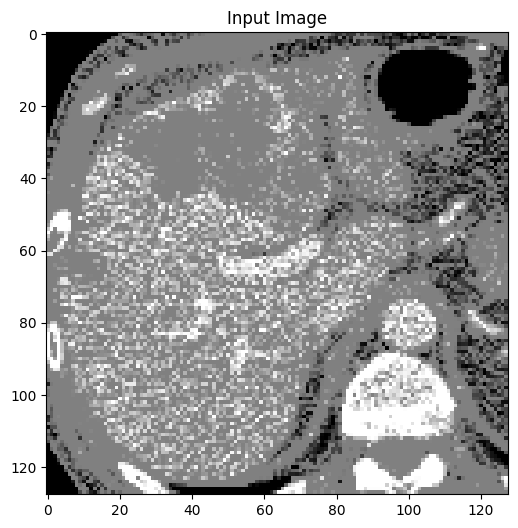

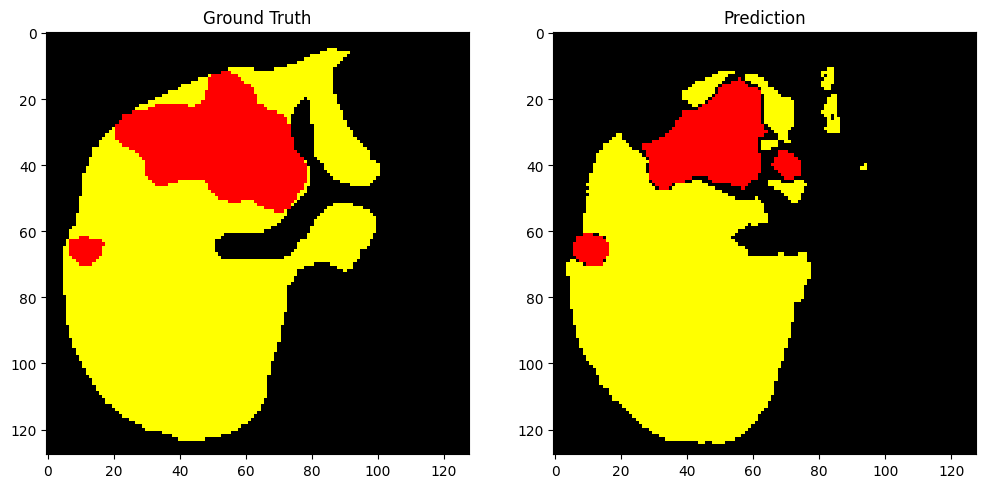

In [14]:
num_images = 1
weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT.pth"
visualize_results(model, val_loader, weight_path, num_images, device)